#**Stellar objects - by Jakub Wisniewski, Lukas Lang and Southik Banerjee**

This Machine learning project is -as the title suggests- about stellar/astronomic objects. The goal of this project is to train a model that classifies some input data either as a galaxy, a star or quasar. This model will be trained by quite a huge dataset containing 100.000 samples and 18 attributes.
In Machine learning language, we have to deal with a multiclass classification problem using several classification models, such as knn, logistic regression, decision trees, random forests, extra trees, support vector machines, (gaussian) naive bayes, neural networks and histogram based gradient boosting, compare their perfomance and decide which model predicts best.
Hence, the main question for this project is, given some data of a stellar object, to predict whether the input is a galaxy, star or quasar.


#**Data preparation**

###Imports for data preparation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

###Loading the data and exploring it

First of all, we will load our dataset and have a rough first glance at it.

In [ ]:
url = "https://raw.githubusercontent.com/GezaLang/ML_Project_csv/main/star_classification.csv"
df = pd.read_csv(url)
print(df.info())
print()
print("Describe:")
print(df.describe())
print()
print("Head:")
print(df.head())
print()
print(df.isna().sum())
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

As we can see, we have 18 attributees and 100.000 samples, just as granted. Every feature besides "class" has a numeric data type and -luckily- there is no missing data in the data set. This means that every sample can be used, we don´t have to delete samples or balance missing values in some way.


As the features are not common knowledge, we would like to give a short summary of every feature:

1. obj_ID (Object Identifier):
  This is a unique value that identifies an object in the image catalog used by the Sloan Digital Sky Survey (SDSS) or the Context Access Service (CAS).

2. alpha (Right Ascension angle):
  It represents the celestial longitude of an object in the sky, measured eastward along the celestial equator from the vernal equinox. It's usually given in units of hours, minutes, and seconds.

3. delta (Declination angle):
  It represents the celestial latitude of an object in the sky, measured north or south from the celestial equator. It's usually given in units of degrees, minutes, and seconds.

4. u, g, r, i, z:
  These are filters used in the photometric system of the SDSS. They correspond to different wavelengths of light: ultraviolet (u), green (g), red (r), near-infrared (i), and infrared (z).

4. run_ID (Run Number):
  It's a number used to identify a specific scan or imaging run within the SDSS data. For further information see here: https://www.sdss3.org/dr10/imaging/imaging_basics.php

5. rerun_ID (Rerun Number):
  This number specifies how the image was processed or reprocessed within the SDSS data pipeline.

6. cam_col (Camera column):
  It identifies the scanline within a particular run or imaging session.

7. field_ID (Field number):
  It's a number used to identify each field or area observed within a run.

8. spec_obj_ID (Spectroscopic Object Identifier):
  This is a unique identifier used for optical spectroscopic objects within the SDSS data. Different observations with the same spec_obj_ID should share the same output class.

9. class (Object class):
  It specifies the class of the astronomical object, such as galaxy, star, or quasar.

10. redshift:
  It's a measure of how much the light from an object has been stretched by the expansion of the universe. It's given as a dimensionless quantity or a fractional increase in wavelength. It shows how fast objects in space are moving away from us.

11. plate ID (plate):
  It identifies each photographic plate used in the SDSS spectroscopic observations.

12. MJD (Modified Julian Date):
  It's a modified version of the Julian Date used in astronomy to indicate when a particular observation or piece of data was taken.

13. fiber_ID (Fiber Identifier):
  It identifies the optical fiber that pointed at the focal plane in each spectroscopic observation, capturing the light from the object of interest.


As a matter of fact, we can now drop several in relation to "class" uncorrelated features. In total, we are dropping 11 features, 7 of them are ID´s which are trivially uncorrelated. Alpha and Delta are basically just angles between the earth and the discovered object, as the earth rotates and the position of an object doesn´t classify its type, this is also uncorrelated to the problem. Cam_col is used for SDSS data (c.f. https://www.sdss3.org/dr10/imaging/imaging_basics.php), it doesn´t help solving the problem. MJD should not help us either, as the date of a picture is trivially uncorrelated to the object. If we would depict one object a thousand times, the date would be interesting as we could see e.g. that the distance to earth increases over time. As this is not the case (c.f. duplicate check), we may just drop it.

In [ ]:
df = df.drop(['obj_ID',
              'alpha',
              'delta',
              'run_ID',
              'rerun_ID',
              'cam_col',
              'field_ID',
              'spec_obj_ID',
              'plate',
              'fiber_ID',
              'MJD'],axis = 1)

After we dropped uncorrelated features, our features of main concern are 'u', 'g', 'r', 'i', 'z', 'class', 'redshift' and 'MJD'.

After dropping the ID´s, we can also check whether there are any duplicates in our dataset:

In [ ]:
if df.duplicated().any():
    print("There are duplicates")
else:
    print("No duplicates")

No duplicates


Now we want to have a further look at the "class" feature, as it will be our target feature and is the only object-type feature in our dataset.
To visualize the proportions of Galaxies, Stars and Quasars, we used a "pie" plot. Additionally, we replaced the "string"- names by numerical indices.

class
0    59445
1    21594
2    18961
Name: count, dtype: int64


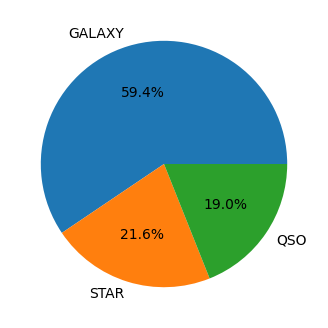

In [ ]:
df["class"] = df["class"].replace({"GALAXY": 0, "STAR": 1, "QSO": 2})
print(df["class"].value_counts())
plt.figure(num=1, figsize=(4, 4))
plt.pie(df["class"].value_counts(), labels = ["GALAXY", "STAR", "QSO"], autopct='%1.1f%%')
plt.show()

As we can see, approximately 60% of the samples are indeed galaxies, whereas stars and quasars appear at approximately 20% probability. As Galaxies occur 3 times more often than the other 2 categories, this is a quite imbalancend problem, which should be considered in later steps.

Of course, we need some train/test-splits of our dataset in order to train our later models. At first we did a naive approach without stratify, just to show the difference between the stratified and not stratisified version.
Additionally, as our dataset is quite big, we might consider different splits such as 90/10 and 95/5. As in absolute numbers the test set is still reasonably large, these spilts might improve the accuracy for later models.

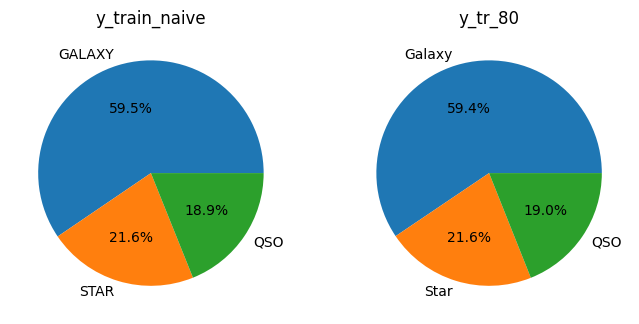

In [ ]:
X = df.drop(["class"],axis=1)
y = df["class"]

X_train_naive, X_test_naive, y_train_naive, y_test_naive = train_test_split(
    X,
    y,
    train_size = 0.8
)

X_tr_80, X_te_80, y_tr_80, y_te_80 = train_test_split(
    X,
    y,
    train_size = 0.8,
    stratify = y #imbalanced dataset
)

X_tr_90, X_te_90, y_tr_90, y_te_90 = train_test_split(
    X,
    y,
    train_size = 0.9,
    stratify = y
)

X_tr_95, X_te_95, y_tr_95, y_te_95 = train_test_split(
    X,
    y,
    train_size = 0.95,
    stratify = y
)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].pie(y_train_naive.value_counts(), labels = ["GALAXY", "STAR", "QSO"], autopct='%1.1f%%')
axs[0].set_title('y_train_naive')

axs[1].pie(y_tr_80.value_counts(), labels = ["Galaxy", "Star", "QSO"], autopct='%1.1f%%')
axs[1].set_title('y_tr_80')
plt.show()

As we can see, the difference between the stratified and not stratified train/test-split is marginal. From this we can deduce that the data set is not too imbalanced. Still it is advisable to use stratify, so we will use it, of course.

On our internet research we also discovered a quite interesting method called SMOTE( Synthetic Minority Over-sampling Technique) to balance our dataset, which we also wanted to share. It basically resamples, respectively upsamples our dataset in such a way that it is balanced.

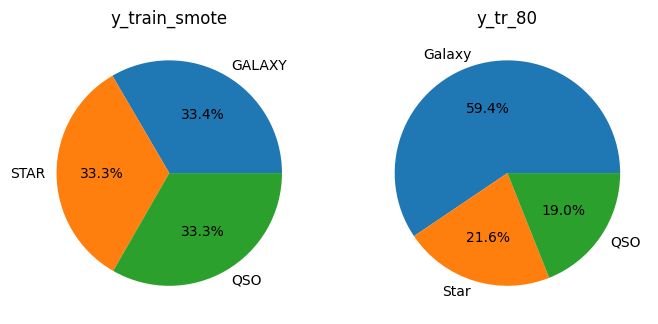

In [ ]:
sm = SMOTE()
X, y= sm.fit_resample(X, y)

X_tr_smote, X_te_smote, y_tr_smote, y_te_smote = train_test_split(
    X,
    y,
    train_size = 0.8,)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].pie(y_tr_smote.value_counts(), labels = ["GALAXY", "STAR", "QSO"], autopct='%1.1f%%')
axs[0].set_title('y_train_smote')

axs[1].pie(y_tr_80.value_counts(), labels = ["Galaxy", "Star", "QSO"], autopct='%1.1f%%')
axs[1].set_title('y_tr_80')
plt.show()

As we can see, the "SMOTED" train/test-split consists of equally distributed classes. This could possibly change a few things, such as the metric that is being analyzed in later steps.

###Removing outliers

Although we did not consider removing outliers in the lecture, we wanted to include the topic as it is pretty important. There are several possible ways to properly detect outliers, for example the IQR (Interquartile Range) which we have covered in last years statistic course. However, it is not the optimal way of detecting outliers for our dataset, as IQR handles every feature separately. Hence, IQR is optimal for univariate datasets, so datasets depending on one variable. Using one example from the lecture, IQR can be used for the correlation between height and mass of a person. If your datasets consists of multiple variables, two features for one sample might be considered as "normal" by IQR, but in combination, they should definitely be considered as outliers.
We also want to show that behavior in a small example:


class
0    47305
1    17214
2     8007
Name: count, dtype: int64



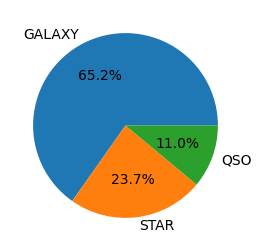

In [ ]:
def remove_outliers(df, target):
    Q1 = df.quantile(.25)
    Q3 = df.quantile(.75)

    IQR = Q3 - Q1

    lower = Q1 - IQR*1.5
    upper = Q3 + IQR*1.5

    mask = (df >= lower) & (df <= upper)
    mask = mask.all(axis=1) #as y_train is a series => axis=1 is necessary

    return df[mask], target[mask]

X_tr_80 = X_tr_80.copy()
y_tr_80 = y_tr_80.copy()

X_tr_80, y_tr_80 = remove_outliers(X_tr_80, y_tr_80)

print(y_tr_80.value_counts())
print()
plt.figure(num=1, figsize=(3,3))
plt.pie(y_tr_80.value_counts(), labels = ["GALAXY", "STAR", "QSO"], autopct='%1.1f%%')
plt.show()



As we can see, mostly quasars are beeing deleted.This phenomenon occurs because Quasars tend to be 'further away' in space as stars or galaxies(c.f. in the further data exploration). Hence, IQR detects them as outliers, which is trivially not correct. As anticipated, IQR does not work really well, we will not consider it using for later purposes.
There are also other more sophisticated methods to detect outliers, such as LOF (LocalOutlierFactor). As it might be very tricky to obtain a good threshold value and implement the function correctly, we decided to leave our data set like it is and not use any outlier removal method.

### Pair plots between features and classes(Stars, Galaxys, Quasar)

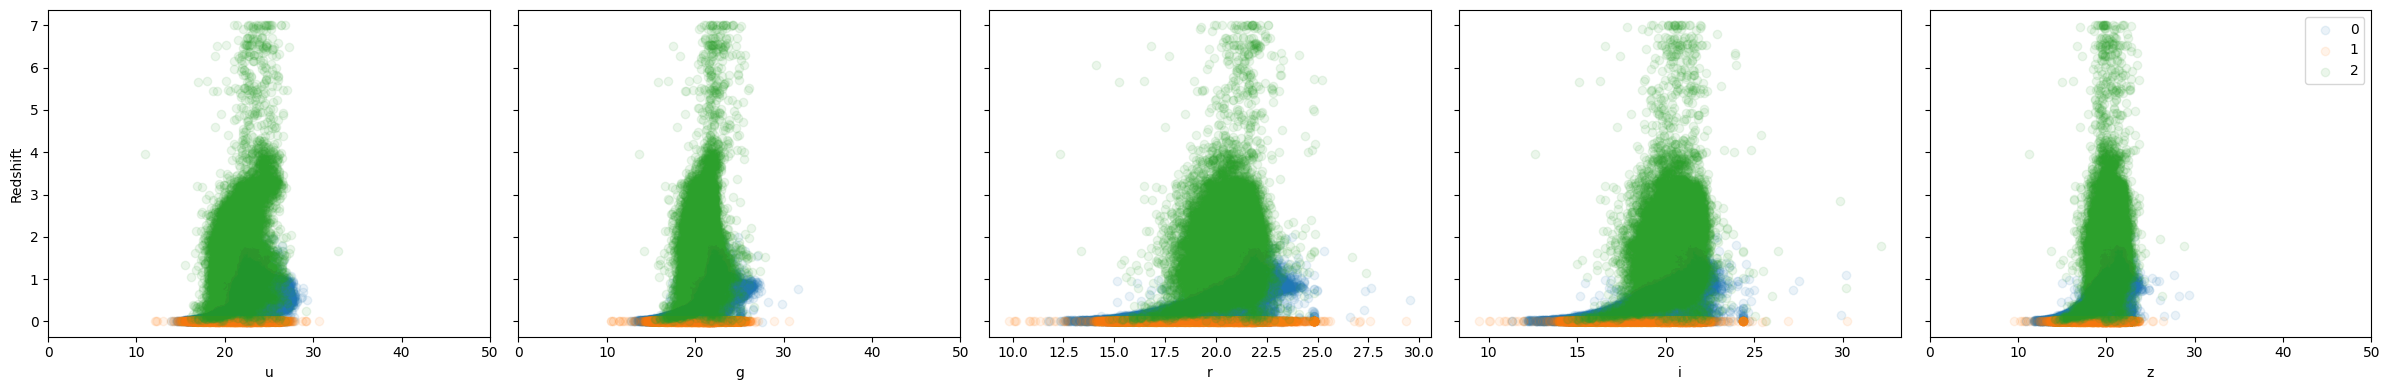

In [ ]:
filtered_data = df[['class', 'redshift', 'u', 'g', 'r', 'i', 'z']]
classes = [0, 1, 2]

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(24, 4), sharey=True)

features = ['u', 'g', 'r', 'i', 'z']
features_to_adjust = ['u', 'g', 'z']

for idx, feature in enumerate(features):
    ax = axes[idx]
    for cls in classes:
        cls_data = filtered_data[filtered_data['class'] == cls]
        ax.scatter(cls_data[feature], cls_data['redshift'], label=cls, alpha=0.09)
    ax.set_xlabel(feature)
    if feature in features_to_adjust:
        ax.set_xlim(0, 50)
    if idx == 0:
        ax.set_ylabel('Redshift')
    if idx == len(features) - 1:
        ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


----------------------------------


##Further Data Exploration

In the following you can find deeper information about the data set. This might be interesting if you are not only interested in the models and algorithms but also want to get some information about the actual topic of this project, stellar obejcts.

First of all we will have a look at the redshift in relation to each of the classes as this impacts the performance of our models positively as it will turn out later:

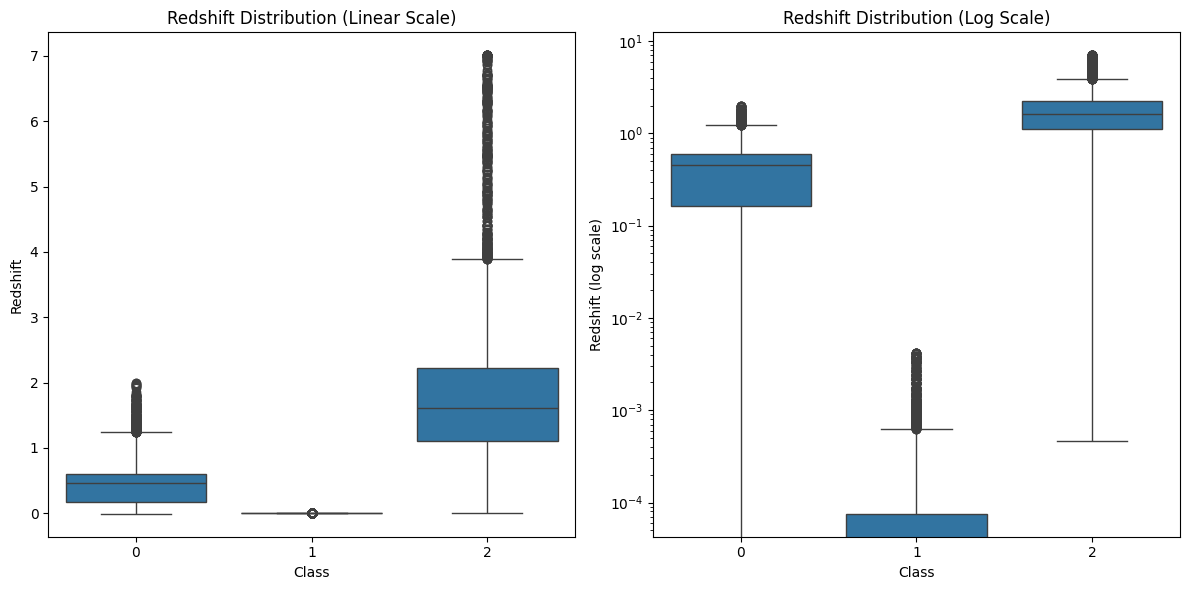

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

#linear y
sns.boxplot(x="class", y="redshift", data=df, ax=axes[0])
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Redshift")
axes[0].set_title("Redshift Distribution (Linear Scale)")
#log y
sns.boxplot(x="class", y="redshift", data=df, ax=axes[1])
axes[1].set_yscale("log")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Redshift (log scale)")
axes[1].set_title("Redshift Distribution (Log Scale)")

plt.tight_layout()
plt.show()

As we can again see here, the 3 classes can be classified pretty well just by looking at their redshift distribution. Each of the classes has an unique IQR, which will lead to very good results for some models.

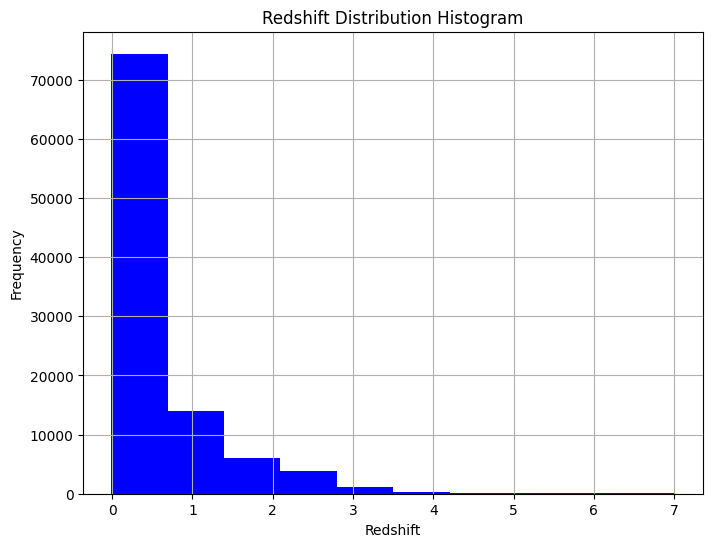

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df['redshift'], bins=10, color='blue', alpha=1)
plt.xlabel('Redshift')
plt.ylabel('Frequency')
plt.title('Redshift Distribution Histogram')
plt.grid(True)
plt.show()

There are more than 70000 observed object at a intermediate distance (from 0 to about 0.8), and the frequence rapidly drops as the redshift approaches 1 (redshift of 1 is considered to be very far).

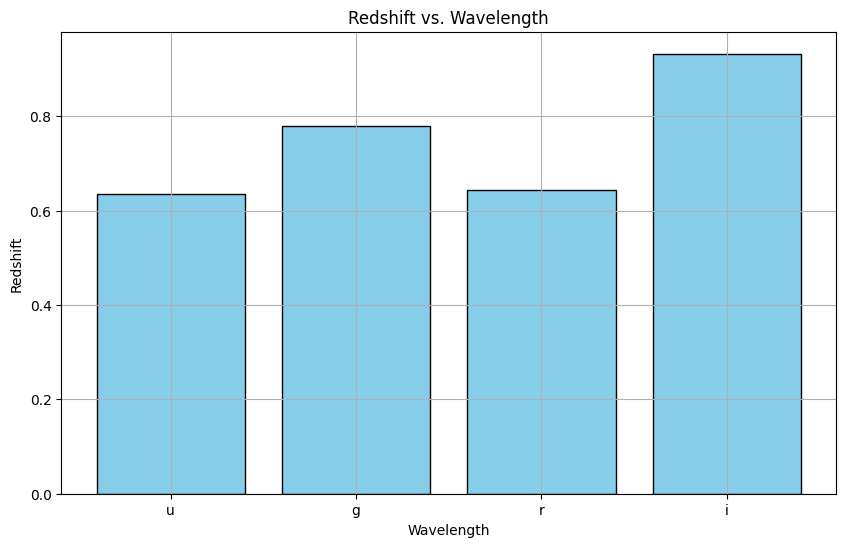

In [ ]:
wavelengths = ['u', 'g', 'r', 'i']
redshifts = df['redshift'][:4]

plt.figure(figsize=(10, 6))
plt.bar(wavelengths, redshifts, color='skyblue', edgecolor='black')

plt.xlabel('Wavelength')
plt.ylabel('Redshift')
plt.title('Redshift vs. Wavelength')
plt.grid(True)

plt.show()


As the light from the object travels further the light's wavelength gets "streched". Galaxies and Quasars produce high ammounts of ultra violet light, which slowly gets redshifted into green/red then to near-inferred. And redshift mesures the distance to the steller object by looking at how streched the wave length is (redshift). Which is why we see a increase in redshift as we move along u, g, r and i. But the redshift for red is the same for UV eventhough red has a longer wavelength than UV. From my research, this could be because of space dust making it harder to detect higher redshift objects whereas near-infered is able to penetrate dust more effectively  

 Scatter plots between diffrent wavelength and effect of Redshift

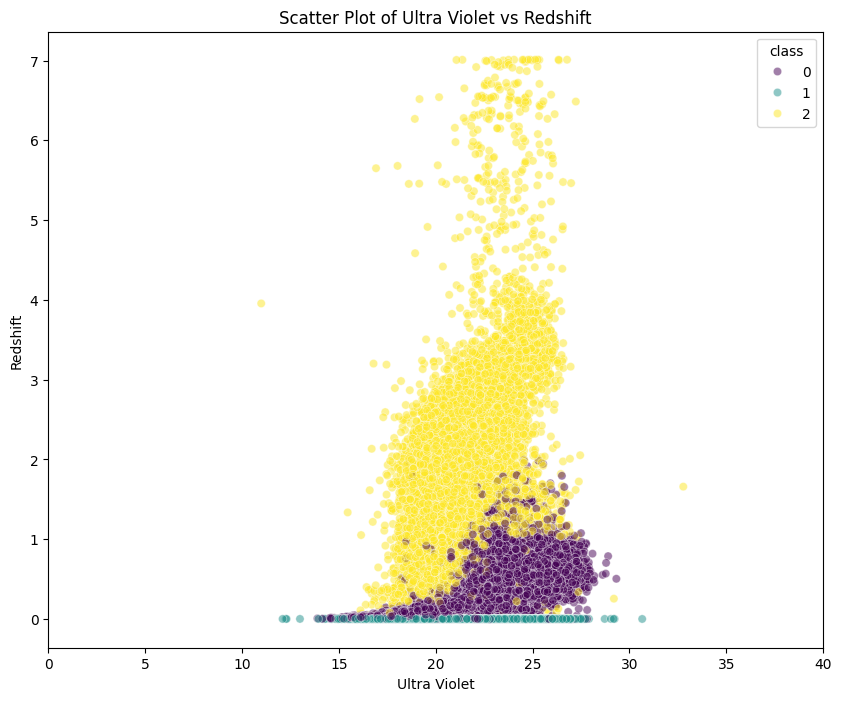

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='u', y='redshift', hue='class', data=df, palette='viridis', alpha=0.5)

plt.title('Scatter Plot of Ultra Violet vs Redshift')
plt.xlabel("Ultra Violet")
plt.ylabel("Redshift")

plt.xlim(0, 40)

plt.show()

Again, as already mentioned,this shows that in general stars are closer to us than galaxies and galaxies are usually closer than quasars. Considering that the sun is a star, this makes quite a lot of sense. Also notice that the overlap of points between galaxies and quasars is much more significant compared to the overlap between Stars and Galaxies. Later we can see that this caused misclassification between Galaxies and Quasars.

---------------------------

#**Models**

In [ ]:
#@title **Imports for models**
# sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, cross_val_score, RandomizedSearchCV, cross_val_predict, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, ConfusionMatrixDisplay, roc_curve, precision_score, recall_score, f1_score
from sklearn.tree import export_graphviz
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

# Other
from graphviz import Source
from mlxtend.plotting import plot_decision_regions
import time

##**The kNN-classification algorithm**





At first we will start with one of the simplest classifier algorithms, namely kNN. As we have an imbalanced dataset we have to think about which metric should be optimized. There is no unique solution for any problem, we talked several times about optimizing metrics for the cancer patient example. However, as we only strive to classify a stellar object and do not really care whether a star is misclassified as galaxy or quasar -both should be equally bad-, we really only want to optimize the F1-score. Additionaly, we could also think of Cohen´s kappa or Average Precision.

Remark: Model 1 = (80/20), Model 2 = (90/10), Model 3 = (95/5), Model 4 = (SMOTE)

----------------------------------


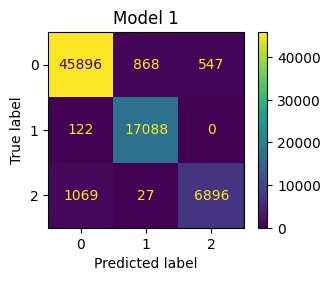

----------------------------------


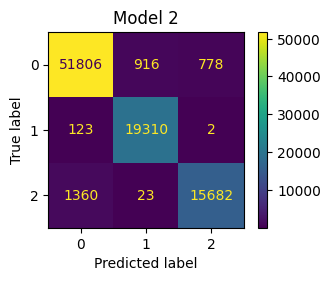

----------------------------------


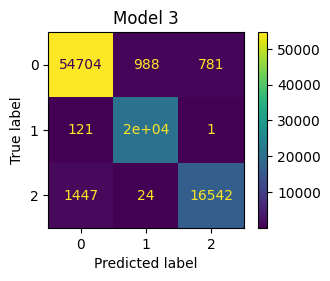

----------------------------------


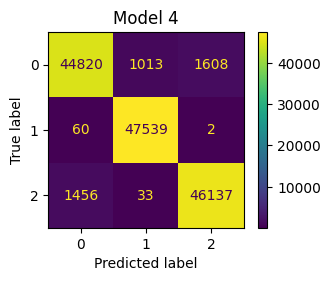

model_1 - Best parameters: {'knn__n_neighbors': 6, 'knn__weights': 'distance'}
model_1 - Best CV f1-score (train): 0.9633977803981658
model_1 - Cohen's Kappa Score (train): 0.9282616064344645
---------------------------
model_2 - Best parameters: {'knn__n_neighbors': 6, 'knn__weights': 'distance'}
model_2 - Best CV f1-score (train): 0.9642959640758709
model_2 - Cohen's Kappa Score (train): 0.937003986111143
---------------------------
model_3 - Best parameters: {'knn__n_neighbors': 8, 'knn__weights': 'distance'}
model_3 - Best CV f1-score (train): 0.9644760498042363
model_3 - Cohen's Kappa Score (train): 0.9373255066575704
---------------------------
model_4 - Best parameters: {'knn__n_neighbors': 5, 'knn__weights': 'distance'}
model_4 - Best CV f1-score (train): 0.970641574010758
model_4 - Cohen's Kappa Score (train): 0.9561352775218647
---------------------------


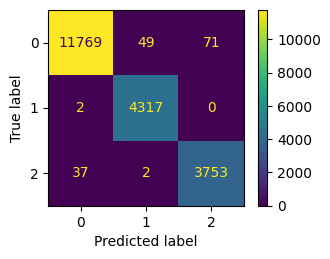

Test set f1-score for split 1: 99.195%

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     11889
           1       0.99      1.00      0.99      4319
           2       0.98      0.99      0.99      3792

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



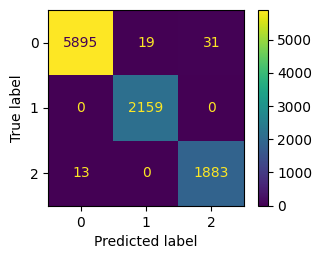

Test set f1-score for split 2: 99.37%

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5945
           1       0.99      1.00      1.00      2159
           2       0.98      0.99      0.99      1896

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



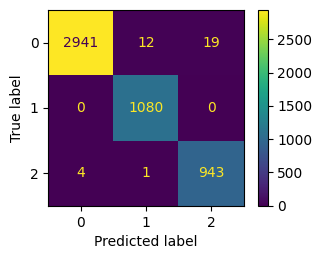

Test set f1-score for split 3: 99.28%

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2972
           1       0.99      1.00      0.99      1080
           2       0.98      0.99      0.99       948

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



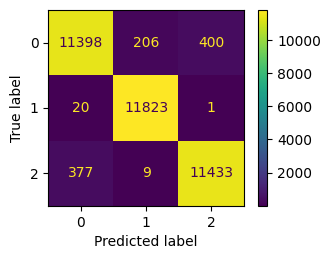

Test set f1-score for split 4: 97.1598%

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     12004
           1       0.98      1.00      0.99     11844
           2       0.97      0.97      0.97     11819

    accuracy                           0.97     35667
   macro avg       0.97      0.97      0.97     35667
weighted avg       0.97      0.97      0.97     35667

model_1 - Cohen's Kappa Score (test): 0.9857678732704961
-----------------
model_2 - Cohen's Kappa Score (test): 0.9888585680812406
-----------------
model_3 - Cohen's Kappa Score (test): 0.9872836848829294
-----------------
model_4 - Cohen's Kappa Score (test): 0.9573982808427939
-----------------
elapsed time: 44.32608629067739 minutes


In [ ]:
t0 = time.time()
print("Remark: Model 1 = (80/20), Model 2 = (90/10), Model 3 = (95/5), Model 4 = (SMOTE)")
print()
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())])

param_grid = {
    "knn__n_neighbors": list(range(1, 45)),
    "knn__weights": ["uniform", "distance"]
}

pipes_individual = [] #for the individual test set evaluations
pipes_individual_params = [] #maybe we will need it; better have it then need it

train_results = {}
trainsets = [(X_tr_80, y_tr_80), #model1
             (X_tr_90, y_tr_90), #2
             (X_tr_95, y_tr_95), #3
             (X_tr_smote, y_tr_smote)] #4

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='f1_weighted')

for i, (X, y) in enumerate(trainsets):
    grid_search.fit(X,y)
    pipes_individual_params.append(pipe.set_params(**grid_search.best_params_)) #due to some positional error thing
    pipe_i = pipe.set_params(**grid_search.best_params_)
    pipe_i.fit(X, y)
    pipes_individual.append(pipe_i)
    predictions = cross_val_predict(pipe_i, X, y, cv=5)
    cm = confusion_matrix(y, predictions)
    print("----------------------------------")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.subplot(2, 2, i + 1))
    plt.tight_layout()
    plt.title(f"Model {i + 1}")
    plt.show()
    kappa_score = cohen_kappa_score(y, predictions)
    train_results[f'model_{i+1}'] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'kappa_score': kappa_score }

for model, result in train_results.items():
    print(f"{model} - Best parameters: {result['best_params']}")
    print(f"{model} - Best CV f1-score (train): {result['best_score']}")
    print(f"{model} - Cohen's Kappa Score (train): {result['kappa_score']}")
    print("---------------------------")

kappa_results_test={}
f1_scores_test = []
testsets= [
    (X_te_80,y_te_80),
    (X_te_90, y_te_90),
    (X_te_95, y_te_95),
    (X_te_smote, y_te_smote)]

for i, (X_te, y_te) in enumerate(testsets):
    pipe_i = pipes_individual[i]
    predictions_te = pipe_i.predict(X_te)
    cm = confusion_matrix(y_te, predictions_te)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.subplot(2, 2, i + 1))
    plt.tight_layout()
    plt.show()
    report = classification_report(y_te, predictions_te)
    print(f"Test set f1-score for split {i+1}: {round(pipe_i.score(X_te,y_te) * 100, 4)}%\n")
    f1_scores_test.append(pipe_i.score(X_te,y_te))
    print("Classification report:")
    print(report)
    kappa_score = cohen_kappa_score(y_te, predictions_te)
    kappa_results_test[f'model_{i+1}'] = {'kappa_score': kappa_score }

for model, result in kappa_results_test.items():
    print(f"{model} - Cohen's Kappa Score (test): {result['kappa_score']}")
    print("-----------------")

t1 = time.time()
print("elapsed time:", (t1-t0) / 60, "minutes")

As we can see from the results, this cell runs for almost an hour; we will try to optimize that later on. The train-scores are overall pretty good, the "SMOTED"-trainset seems to performe worst in that case. Overall, the Confusion Matrices have more or less the same proportions. Indeed, they are also quite reasonable, we can deduct that a lot of galaxies are misclassified as quasars or stars, which makes sense from a physics sight as galaxies are the objects that are in between both objects regarding its distance. Quasars shouldn´t be classified as stars, which covers with the matrices.

However, the test results are actually too good to be true, which made us suspicious about test data leakage. We will discuss this in the following process as we do PCA-dimension reduction, simply because it is the same code with less computational time.

A small visualization of the best f1-score for every test set.

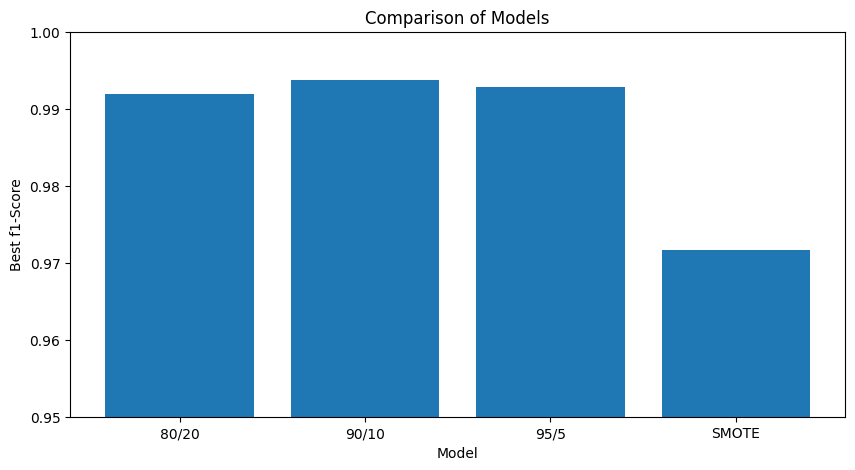

In [ ]:
model_names = ['80/20', '90/10', '95/5', 'SMOTE']
plt.figure(figsize=(10, 5))
plt.bar(range(len(f1_scores_test)), f1_scores_test)
plt.xlabel('Model')
plt.ylabel('Best f1-Score')
plt.ylim(0.95,1)
plt.title('Comparison of Models')
plt.xticks(range(len(f1_scores_test)), model_names)
plt.show()

However, the computation time is quite long for the 3 cells (roughly an hour); we will try some PCA in order to minimize the computation time with still reasonable results.

### Optimizing Time Efficiency Using PCA

As our kNN model takes almost one hour to train,it is quite reasonable to use PCA, so basically dimension reduction, in order to obtain much faster results than with our original high-dimensional dataset. KNN is known to take a lot of time in higher dimensional datasets as is becomes more and more advanced to determine the distance to the next partner etc. Hence, computational cost and also computational time rises a lot for higher dimensions.

Firstly, we will do a concrete example with n_components=3 which means that we reduced the dimension of the dataset to 3 and see how it will affect our train/test accuracy as well as the computation time.

Remark: Model 1 = (80/20), Model 2 = (90/10), Model 3 = (95/5), Model 4 = (SMOTE)

----------------------------------


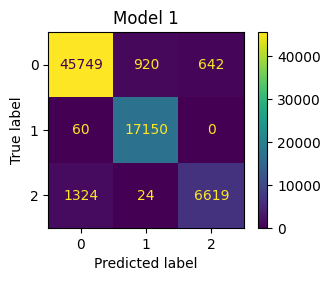

----------------------------------


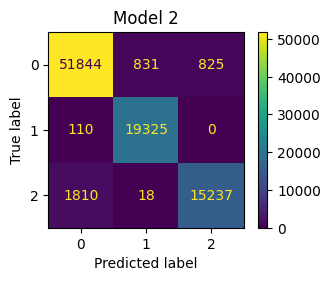

----------------------------------


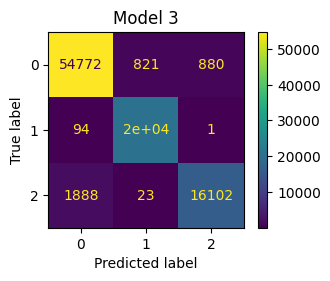

----------------------------------


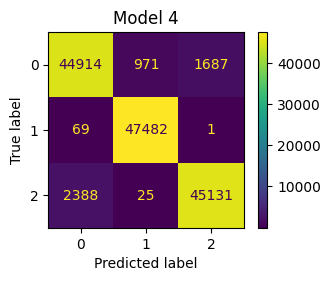

model_1 - Best parameters: {'knn__n_neighbors': 9, 'knn__weights': 'distance'}
model_1 - Best CV f1-score (train): 0.9585278013453878
model_1 - Cohen's Kappa Score (train): 0.9189225591106295
---------------------------
model_2 - Best parameters: {'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
model_2 - Best CV f1-score (train): 0.9597704954126767
model_2 - Cohen's Kappa Score (train): 0.9290260421895746
---------------------------
model_3 - Best parameters: {'knn__n_neighbors': 7, 'knn__weights': 'distance'}
model_3 - Best CV f1-score (train): 0.9606857253229585
model_3 - Cohen's Kappa Score (train): 0.9306465201617408
---------------------------
model_4 - Best parameters: {'knn__n_neighbors': 8, 'knn__weights': 'distance'}
model_4 - Best CV f1-score (train): 0.9638555882577877
model_4 - Cohen's Kappa Score (train): 0.9459479263185504
---------------------------


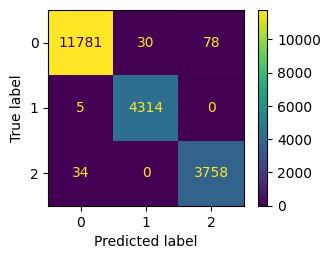

Test set f1-score for split 1: 99.265%

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     11889
           1       0.99      1.00      1.00      4319
           2       0.98      0.99      0.99      3792

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000

model_1 - Cohen's Kappa Score (test): 0.9870005935334444
-----------------


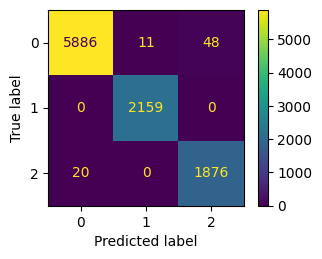

Test set f1-score for split 2: 99.21%

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5945
           1       0.99      1.00      1.00      2159
           2       0.98      0.99      0.98      1896

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

model_1 - Cohen's Kappa Score (test): 0.9870005935334444
-----------------
model_2 - Cohen's Kappa Score (test): 0.9860315182699961
-----------------


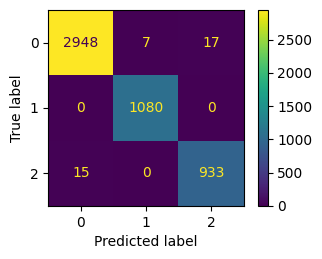

Test set f1-score for split 3: 99.22%

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2972
           1       0.99      1.00      1.00      1080
           2       0.98      0.98      0.98       948

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000

model_1 - Cohen's Kappa Score (test): 0.9870005935334444
-----------------
model_2 - Cohen's Kappa Score (test): 0.9860315182699961
-----------------
model_3 - Cohen's Kappa Score (test): 0.9861892187517264
-----------------


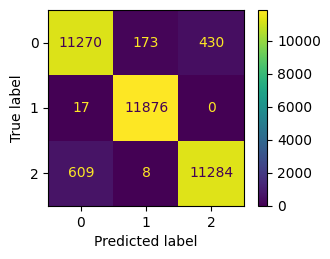

Test set f1-score for split 4: 96.5318%

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     11873
           1       0.98      1.00      0.99     11893
           2       0.96      0.95      0.96     11901

    accuracy                           0.97     35667
   macro avg       0.97      0.97      0.97     35667
weighted avg       0.97      0.97      0.97     35667

model_1 - Cohen's Kappa Score (test): 0.9870005935334444
-----------------
model_2 - Cohen's Kappa Score (test): 0.9860315182699961
-----------------
model_3 - Cohen's Kappa Score (test): 0.9861892187517264
-----------------
model_4 - Cohen's Kappa Score (test): 0.947977216174464
-----------------
elapsed time: 26.616080685456595 minutes


In [ ]:
t0 =time.time()

print("Remark: Model 1 = (80/20), Model 2 = (90/10), Model 3 = (95/5), Model 4 = (SMOTE)")
print()
pca = PCA(n_components=3)
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("PCA", pca),
    ("knn", KNeighborsClassifier())])

pipes_individual = [] #for the individual test set evaluations
pipes_individual_params = [] #maybe we will need it; better have it then need it

param_grid = {
    "knn__n_neighbors": list(range(1,45)),
    "knn__weights": ["uniform", "distance"]}

train_results = {}
trainsets = [
            (X_tr_80, y_tr_80),
            (X_tr_90, y_tr_90),
            (X_tr_95, y_tr_95),
            (X_tr_smote, y_tr_smote)
            ]

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='f1_weighted')

for i, (X, y) in enumerate(trainsets):
    grid_search.fit(X,y)
    pipes_individual_params.append(pipe.set_params(**grid_search.best_params_)) #due to some positional error thing
    pipe_i = pipe.set_params(**grid_search.best_params_)
    pipe_i.fit(X, y)
    pipes_individual.append(pipe_i)
    predictions = cross_val_predict(pipe_i, X, y, cv=5)
    cm = confusion_matrix(y, predictions)
    print("----------------------------------")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.subplot(2, 2, i + 1))
    plt.tight_layout()
    plt.title(f"Model {i + 1}")
    plt.show()
    kappa_score = cohen_kappa_score(y, predictions)
    train_results[f'model_{i+1}'] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'kappa_score': kappa_score }

for model, result in train_results.items():
    print(f"{model} - Best parameters: {result['best_params']}")
    print(f"{model} - Best CV f1-score (train): {result['best_score']}")
    print(f"{model} - Cohen's Kappa Score (train): {result['kappa_score']}")
    print("---------------------------")


testsets= [
    (X_te_80,y_te_80),
    (X_te_90, y_te_90),
    (X_te_95, y_te_95),
    (X_te_smote, y_te_smote)]

f1_scores_test = []
kappa_results_test={}

for i, (X_te, y_te) in enumerate(testsets):
    pipe_i = pipes_individual[i]
    predictions_te = pipe_i.predict(X_te)
    cm = confusion_matrix(y_te, predictions_te)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.subplot(2, 2, i + 1))
    plt.tight_layout()
    plt.show()
    report = classification_report(y_te, predictions_te)
    print(f"Test set f1-score for split {i+1}: {round(pipe_i.score(X_te,y_te) * 100, 4)}%\n")
    f1_scores_test.append(pipe_i.score(X_te,y_te))
    print("Classification report:")
    print(report)
    kappa_score = cohen_kappa_score(y_te, predictions_te)
    kappa_results_test[f'model_{i+1}'] = {'kappa_score': kappa_score }

    for model, result in kappa_results_test.items():
        print(f"{model} - Cohen's Kappa Score (test): {result['kappa_score']}")
        print("-----------------")

t1 = time.time()
print("elapsed time:", (t1-t0) / 60, "minutes")

The test scores seem way too good to be true. As the train scores are lower than the test scores, one can think of for example data leakage. To validate the scores and the looped implementation, we will perform a naive test set evaluation with very simple and understandable steps and see whether we obtain similar results.

Naive Test Set Evaluation:

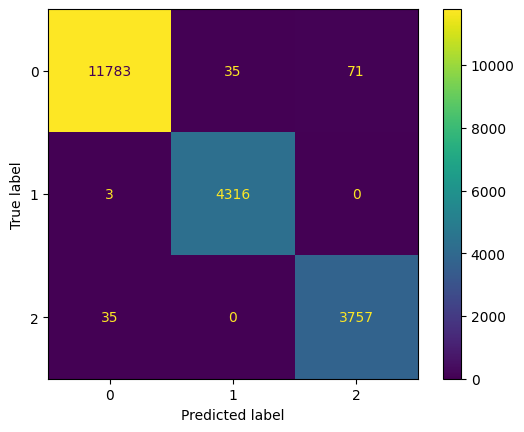

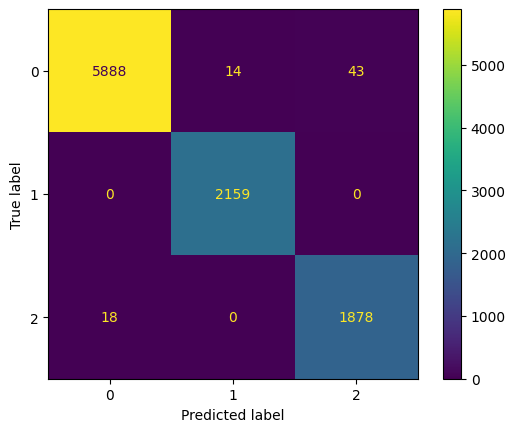

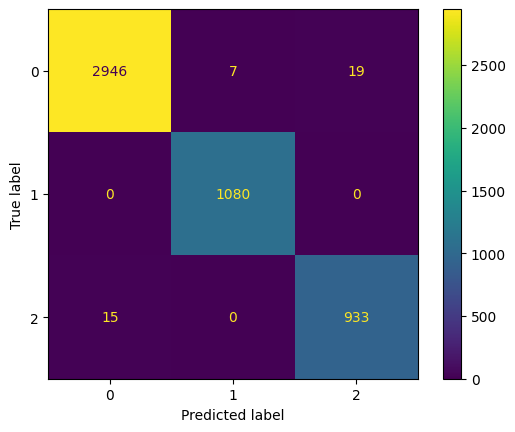

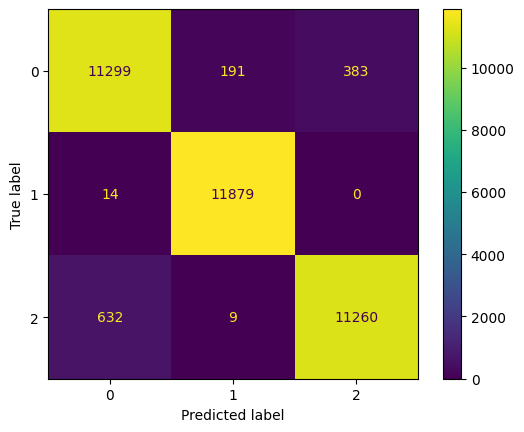

Test set f1-score for split 80/20:  99.28 %
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     11889
           1       0.99      1.00      1.00      4319
           2       0.98      0.99      0.99      3792

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000

------------
Test set f1-score for split 90/10:  99.25 %
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5945
           1       0.99      1.00      1.00      2159
           2       0.98      0.99      0.98      1896

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

------------
Test set f1-score for split 95/5:  99.18 %
Classification report:
            

In [ ]:
pca = PCA(n_components=3)
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("PCA", pca),
    ("knn", KNeighborsClassifier())])

pipe_80= pipe.set_params(**{'knn__n_neighbors': 11, 'knn__weights': 'distance'})
pipe_90= pipe.set_params(**{'knn__n_neighbors': 9, 'knn__weights': 'distance'})
pipe_95= pipe.set_params(**{'knn__n_neighbors': 12, 'knn__weights': 'distance'})
pipe_smote= pipe.set_params(**{'knn__n_neighbors': 14, 'knn__weights': 'distance'})

pipe_80.fit(X_tr_80, y_tr_80)
pipe_90.fit(X_tr_90, y_tr_90)
pipe_95.fit(X_tr_95, y_tr_95)
pipe_smote.fit(X_tr_smote, y_tr_smote)

pipe_80.predict(X_te_80)
pipe_90.predict(X_te_90)
pipe_95.predict(X_te_95)
pipe_smote.predict(X_te_smote)

cm_80 = confusion_matrix(y_te_80, pipe_80.predict(X_te_80))
cm_90 = confusion_matrix(y_te_90, pipe_90.predict(X_te_90))
cm_95 = confusion_matrix(y_te_95, pipe_95.predict(X_te_95))
cm_smote = confusion_matrix(y_te_smote, pipe_smote.predict(X_te_smote))

disp_80 = ConfusionMatrixDisplay(confusion_matrix=cm_80)
disp_90 = ConfusionMatrixDisplay(confusion_matrix=cm_90)
disp_95 = ConfusionMatrixDisplay(confusion_matrix=cm_95)
disp_smote = ConfusionMatrixDisplay(confusion_matrix=cm_smote)

disp_80.plot()
disp_90.plot()
disp_95.plot()
disp_smote.plot()
plt.show()

report_80 = classification_report(y_te_80, pipe_80.predict(X_te_80))
report_90 = classification_report(y_te_90, pipe_90.predict(X_te_90))
report_95 = classification_report(y_te_95, pipe_95.predict(X_te_95))
report_smote = classification_report(y_te_smote, pipe_smote.predict(X_te_smote))

print("Test set f1-score for split 80/20: ", round(pipe_80.score(X_te_80,y_te_80) * 100, 4),"%")
print("Classification report:")
print(report_80)
print("------------")
print("Test set f1-score for split 90/10: ", round(pipe_90.score(X_te_90,y_te_90) * 100, 4),"%")
print("Classification report:")
print(report_90)
print("------------")
print("Test set f1-score for split 95/5: ", round(pipe_95.score(X_te_95,y_te_95) * 100, 4),"%")
print("Classification report:")
print(report_95)
print("------------")
print("Test set f1-score for split SMOTE: ", round(pipe_smote.score(X_te_smote,y_te_smote) * 100, 4),"%")
print("Classification report:")
print(report_smote)

As we obtained similar results for the naive approach and there is definitely no data leakage in the naive way, we just have to accept these scores. The reason for the remarkable results might be the fact that is quite easy to classfiy the objects just by looking at the redshift, as we can see in the "Further Data Exploration" section of this project. The boxplot that is contained in this section indicated that each of the classes have more or less unique redshift. As our test sets are significantly smaller than the train sets, this more or less naive approach generalizes quite good for the test sets. However, this is not a really good generalization as the lower cross val scores and the worse performance of the larger SMOTE-test set indicate. (Doesn´t generalize that exceptional for larger sets). We will continue with the usual process:

Again, just as without PCA, we will visualize the performance of the individual test sets.

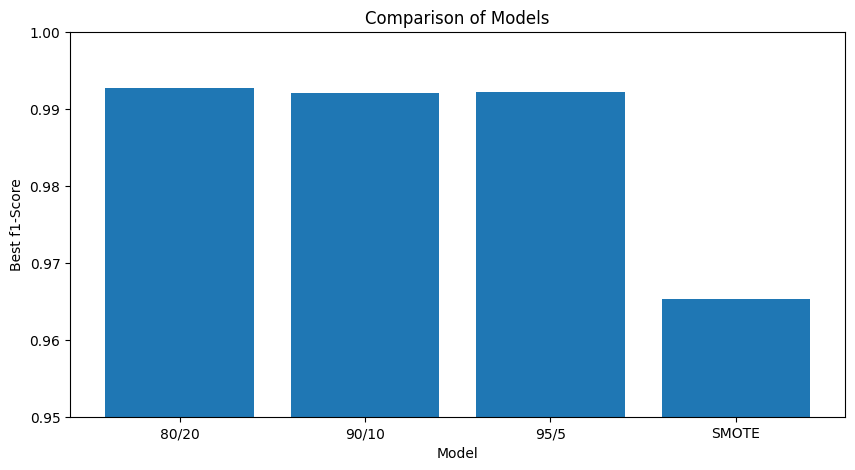

In [ ]:
model_names = ['80/20', '90/10', '95/5', 'SMOTE']
plt.figure(figsize=(10, 5))
plt.bar(range(len(f1_scores_test)), f1_scores_test)
plt.xlabel('Model')
plt.ylabel('Best f1-Score')
plt.ylim(0.95,1)
plt.title('Comparison of Models')
plt.xticks(range(len(f1_scores_test)), model_names)
plt.show()

As a matter of fact, the scores are only slightly worse than without PCA, but we saved almost 25% time in relation to the original model. In terms of efficiency, this is quite reasonable.

Now we want to find a good value for n_components using a plot. For the sake of efficiency and readability, we will only plot it for one train/test-split.

In [ ]:
t0 =time.time()
mean_scores = []
for n_components in range(1, 8):
    pca = PCA(n_components=n_components)
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", pca),
        ("knn", KNeighborsClassifier())
    ])
    param_grid = {
        "knn__n_neighbors": list(range(1, 45)),
        "knn__weights": ["uniform", "distance"]
    }
    grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='f1_weighted')
    grid_search.fit(X_tr_80, y_tr_80)
    scores = grid_search.cv_results_['mean_test_score']
    mean_scores.append(np.mean(scores))
    print(f"Scores for n_components={n_components}: {scores}")
    print("-----")

    print(f"Mean test score for n_components: {round(mean_scores,4)}")
t1 = time.time()
print("Elapsed time:",(t1-t0)/60,"minutes")

Mean test score for n_components: [0.5501507529407289]
-----
Here more detailed: 
Scores for n_components=1: [0.51029457 0.51029457 0.51461928 0.51029457 0.54290884 0.52120559
 0.53777708 0.52650781 0.55226169 0.52972987 0.54710843 0.53214139
 0.55571326 0.5342673  0.55354251 0.53601222 0.55807994 0.53713671
 0.55537067 0.53801026 0.5609813  0.53907789 0.55720871 0.53985616
 0.56233142 0.54064151 0.55856553 0.54137399 0.56254132 0.54176393
 0.55940809 0.54255306 0.56228216 0.54308316 0.56147565 0.54319604
 0.56300073 0.54352198 0.56135954 0.54356611 0.56429617 0.54414777
 0.56318889 0.5441835  0.56339076 0.54453142 0.56306058 0.545104
 0.56382612 0.545582   0.56320768 0.54586532 0.56442254 0.54614053
 0.56398117 0.54635146 0.56527867 0.54665346 0.56444637 0.54714301
 0.56453539 0.54718481 0.5646999  0.54766585 0.56494885 0.54782754
 0.56390045 0.5478031  0.56495273 0.54800176 0.56417685 0.54826771
 0.56469172 0.54877194 0.56477774 0.54861909 0.56463131 0.54899552
 0.56522482 0.54903583

Mean test score for n_components:
[0.5501507529407289,
0.7443162647568239,
0.9374822818182525,
0.9426983306804295,
0.9499182521533002,
0.9503172827231215,
0.9503971472641798]

We can see a significant rise in the Mean Test Score as for n_components larger equal 3. We will visualize that in a plotting:

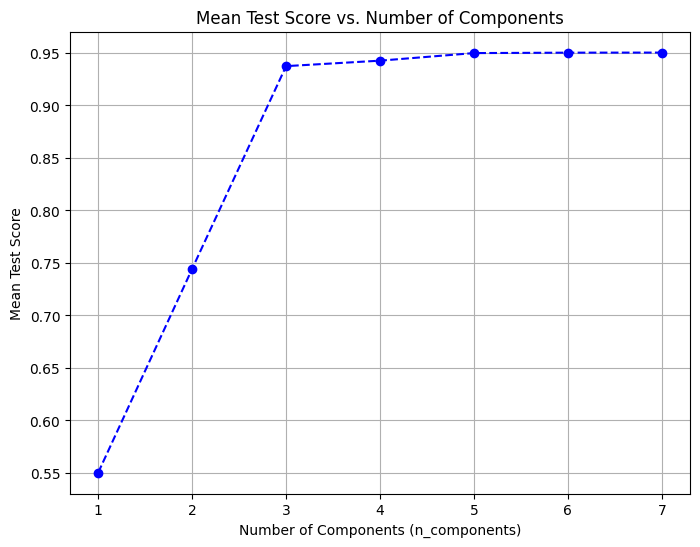

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 8), mean_scores, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components (n_components)')
plt.ylabel('Mean Test Score')
plt.title('Mean Test Score vs. Number of Components')
plt.grid(True)
plt.show()

As we can see, the mean scores start to be reasonably good after n_components =3. However, there is basically no change after n_components=5. This could help reducing the computation time for kNN a lot without having a deficit in accuracy.

It is obviously impossible to plot decision regions for our "original" 8-dimensional dataset. However, PCA can reduce our dataset to a 3 dimensional one, with still reasonable scores. After several more or less sucessful tries, we concluded that it is not particularly nice to plot decision regions for 3 dimensions. We could still do it for the 2-dimensional kNN, but the scores are too low hence it would not be meaningful for the actual classifier.

##**The logistic regression algorithm**

We could also like to look into how well logistic regression performs in classifying the three classes. We will start by first implementing the standard logistic regression with the use of pipelines. We will evaluate the performance by looking into the test accuracy, f1 score and Cohen´s kappa score.


**Advantages**

- Efficient: It is computationally efficient and can be trained relatively quickly, even with large datasets.

- Probabilistic Output: Logistic regression outputs probabilities for the different classes, which can be very useful when interpreting results and making decisions.

- Less Prone to Overfitting: It is less prone to overfitting compared to more complex models as we reduced the features and have many observations.

**Disadvantages**

- Doesn't work well with non-linear relationship, later we see that dataset is linearly seperatable.

- Sensitive to outliers

Dataset 1 - Train Accuracy: 0.9547141182150494
Dataset 1 - Test Accuracy: 0.9594
Dataset 1 - Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.96      0.97      0.97     11889
           1       0.96      1.00      0.98      4319
           2       0.95      0.88      0.91      3792

    accuracy                           0.96     20000
   macro avg       0.96      0.95      0.95     20000
weighted avg       0.96      0.96      0.96     20000



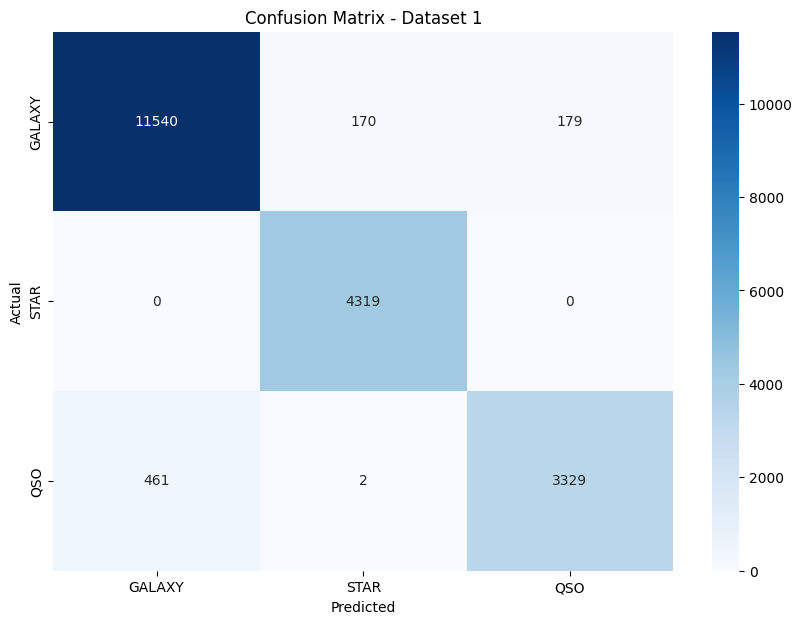

Dataset 2 - Train Accuracy: 0.9545666666666667
Dataset 2 - Test Accuracy: 0.955
Dataset 2 - Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      5945
           1       0.95      1.00      0.97      2159
           2       0.95      0.87      0.91      1896

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



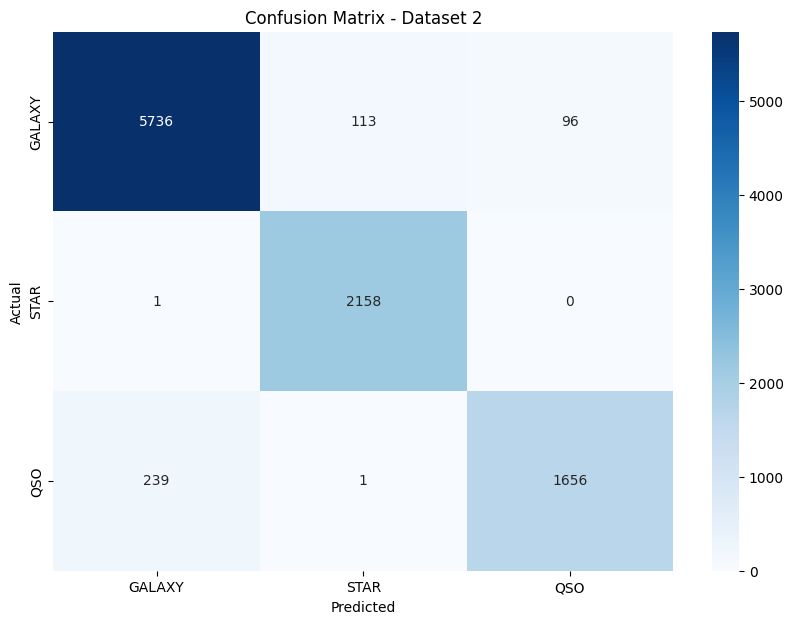

Dataset 3 - Train Accuracy: 0.9547894736842105
Dataset 3 - Test Accuracy: 0.9534
Dataset 3 - Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      2972
           1       0.95      1.00      0.97      1080
           2       0.94      0.88      0.91       948

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



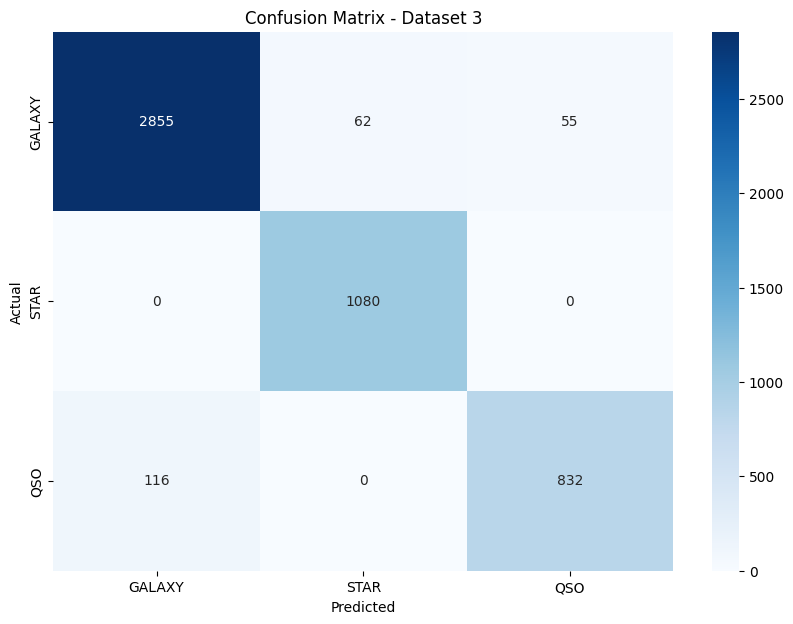

Dataset 4 - Train Accuracy: 0.9479631031485687
Dataset 4 - Test Accuracy: 0.9504584069307763
Dataset 4 - Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.93      0.92      0.93     11903
           1       0.97      1.00      0.98     12096
           2       0.95      0.93      0.94     11668

    accuracy                           0.95     35667
   macro avg       0.95      0.95      0.95     35667
weighted avg       0.95      0.95      0.95     35667



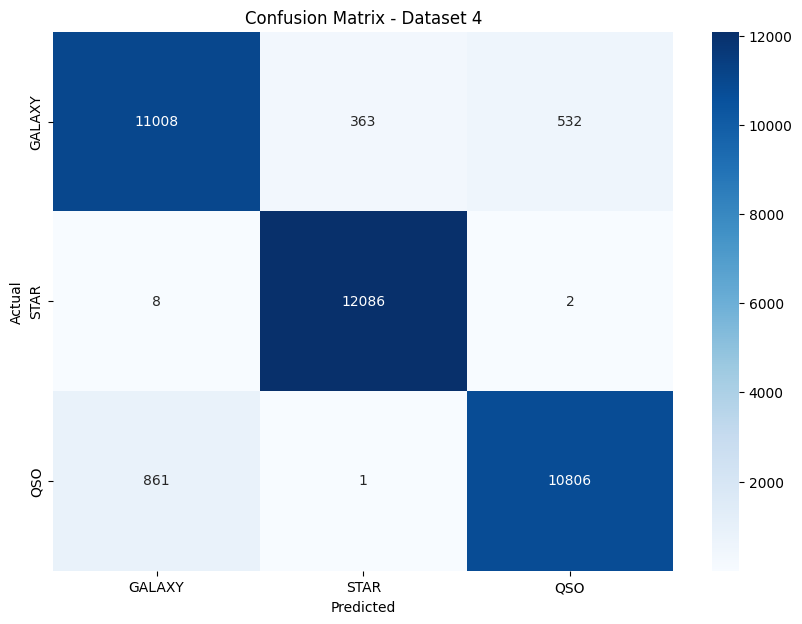

dataset_1 - Train Accuracy: 0.9547141182150494
dataset_1 - Test Accuracy: 0.9594
dataset_1 - Cohen's Kappa Score: 0.9277004846195558
dataset_1 - Confusion Matrix: 
[[11540   170   179]
 [    0  4319     0]
 [  461     2  3329]]

dataset_2 - Train Accuracy: 0.9545666666666667
dataset_2 - Test Accuracy: 0.955
dataset_2 - Cohen's Kappa Score: 0.9199937986304361
dataset_2 - Confusion Matrix: 
[[5736  113   96]
 [   1 2158    0]
 [ 239    1 1656]]

dataset_3 - Train Accuracy: 0.9547894736842105
dataset_3 - Test Accuracy: 0.9534
dataset_3 - Cohen's Kappa Score: 0.9173521589744347
dataset_3 - Confusion Matrix: 
[[2855   62   55]
 [   0 1080    0]
 [ 116    0  832]]

dataset_4 - Train Accuracy: 0.9479631031485687
dataset_4 - Test Accuracy: 0.9504584069307763
dataset_4 - Cohen's Kappa Score: 0.9256668126330698
dataset_4 - Confusion Matrix: 
[[11008   363   532]
 [    8 12086     2]
 [  861     1 10806]]

elapsed time: 0.32719335953394574 minutes


In [ ]:
t0 = time.time()

datasets = [
    (X_tr_80, y_tr_80, X_te_80, y_te_80),
    (X_tr_90, y_tr_90, X_te_90, y_te_90),
    (X_tr_95, y_tr_95, X_te_95, y_te_95),
    (X_tr_smote, y_tr_smote, X_te_smote, y_te_smote )
]

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500))
])

results = {}

for i, (X_train, y_train, X_test, y_test) in enumerate(datasets):
    pipeline.fit(X_train, y_train)

    y_test_pred = pipeline.predict(X_test)
    y_train_pred = pipeline.predict(X_train)

    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    print(f"Dataset {i+1} - Train Accuracy: {train_accuracy}")
    print(f"Dataset {i+1} - Test Accuracy: {test_accuracy}")
    print(f"Dataset {i+1} - Classification Report (Test Set):\n", classification_report(y_test, y_test_pred))

    conf_matrix = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['GALAXY', 'STAR', 'QSO'], yticklabels=['GALAXY', 'STAR', 'QSO'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - Dataset {i+1}')
    plt.show()

    kappa_score = cohen_kappa_score(y_test, y_test_pred)

    results[f'dataset_{i+1}'] = {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'kappa_score': kappa_score,
        'confusion_matrix': conf_matrix
    }

for dataset, result in results.items():
    print(f"{dataset} - Train Accuracy: {result['train_accuracy']}")
    print(f"{dataset} - Test Accuracy: {result['test_accuracy']}")
    print(f"{dataset} - Cohen's Kappa Score: {result['kappa_score']}")
    print(f"{dataset} - Confusion Matrix: \n{result['confusion_matrix']}")
    print()
t1 = time.time()
print("elapsed time:", (t1-t0) / 60, "minutes")



From the 4 different test-splits, the best performing one is the 80/20-split (model 1) with a test accuracy of 0.9594

Now, we would like to optimize the best value for the hyper parameter C, which the regularization value, the best solver (newton-cg, lbfgs, sag or saga) for each train set, and the max iterations.


We also see that the model has difficulty in classifying between Galaxy and Quasars or Galaxy and Star.

### Optimization with grid search

Dataset 1 - Best Parameters: {'C': 10, 'max_iter': 100, 'solver': 'lbfgs'}
Dataset 1 - Train Accuracy: 0.9575556934961031
Dataset 1 - Test Accuracy: 0.9621
Dataset 1 - Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     11889
           1       0.97      1.00      0.99      4319
           2       0.95      0.88      0.91      3792

    accuracy                           0.96     20000
   macro avg       0.96      0.95      0.96     20000
weighted avg       0.96      0.96      0.96     20000



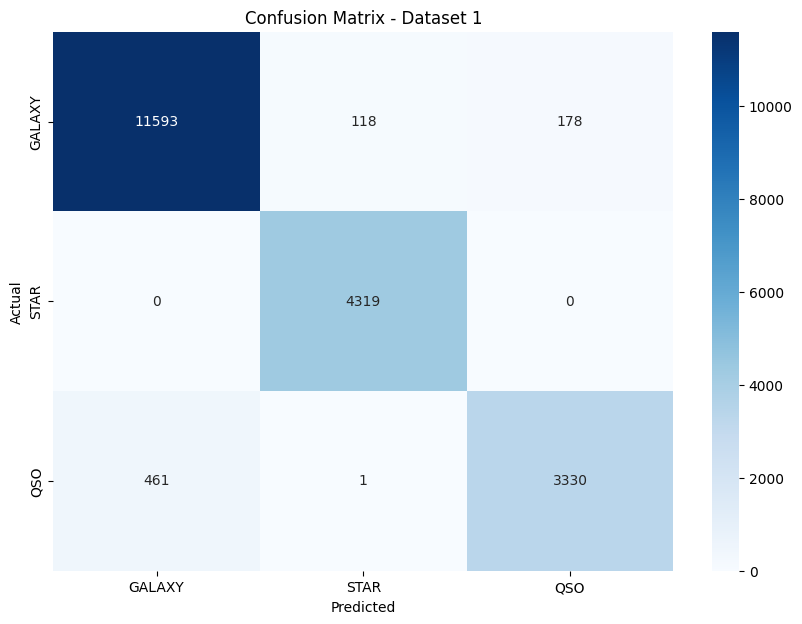

Dataset 2 - Best Parameters: {'C': 10, 'max_iter': 100, 'solver': 'newton-cg'}
Dataset 2 - Train Accuracy: 0.9589666666666666
Dataset 2 - Test Accuracy: 0.9582
Dataset 2 - Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      5945
           1       0.96      1.00      0.98      2159
           2       0.94      0.88      0.91      1896

    accuracy                           0.96     10000
   macro avg       0.96      0.95      0.95     10000
weighted avg       0.96      0.96      0.96     10000



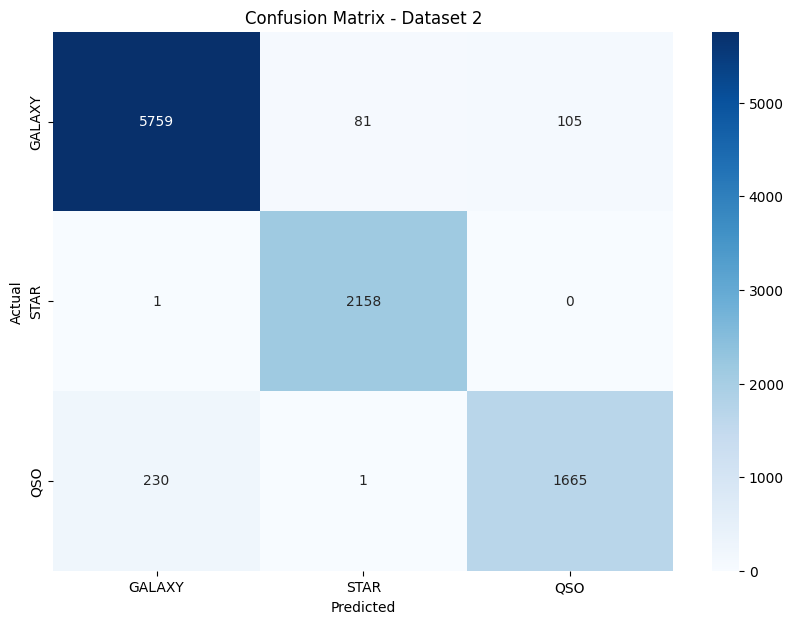

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Dataset 3 - Best Parameters: {'C': 10, 'max_iter': 200, 'solver': 'lbfgs'}
Dataset 3 - Train Accuracy: 0.9590526315789474
Dataset 3 - Test Accuracy: 0.959
Dataset 3 - Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      2972
           1       0.97      1.00      0.98      1080
           2       0.94      0.88      0.91       948

    accuracy                           0.96      5000
   macro avg       0.96      0.95      0.95      5000
weighted avg       0.96      0.96      0.96      5000



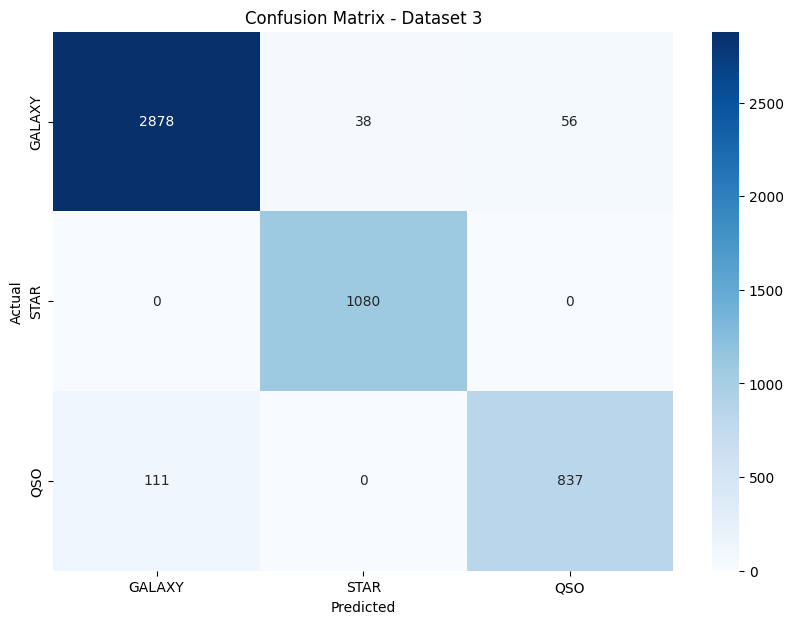

Dataset 4 - Best Parameters: {'C': 10, 'max_iter': 100, 'solver': 'newton-cg'}
Dataset 4 - Train Accuracy: 0.9530728684778647
Dataset 4 - Test Accuracy: 0.9556452743432304
Dataset 4 - Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.93      0.94      0.93     11903
           1       0.98      1.00      0.99     12096
           2       0.95      0.93      0.94     11668

    accuracy                           0.96     35667
   macro avg       0.96      0.96      0.96     35667
weighted avg       0.96      0.96      0.96     35667



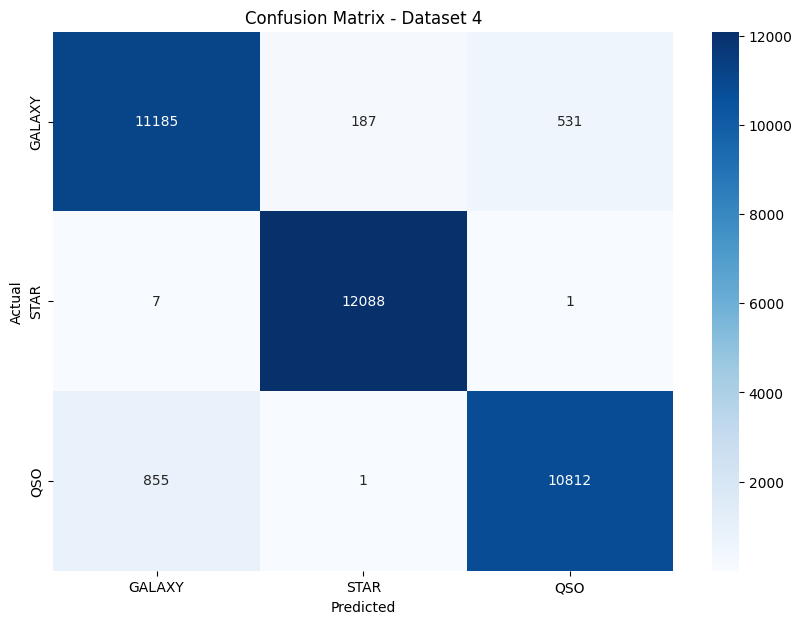

dataset_1 - Best Parameters: {'C': 10, 'max_iter': 100, 'solver': 'lbfgs'}
dataset_1 - Train Accuracy: 0.9575556934961031
dataset_1 - Test Accuracy: 0.9621
dataset_1 - Cohen's Kappa Score: 0.9323878140791192
dataset_1 - Confusion Matrix: 
[[11593   118   178]
 [    0  4319     0]
 [  461     1  3330]]

dataset_2 - Best Parameters: {'C': 10, 'max_iter': 100, 'solver': 'newton-cg'}
dataset_2 - Train Accuracy: 0.9589666666666666
dataset_2 - Test Accuracy: 0.9582
dataset_2 - Cohen's Kappa Score: 0.9256192949954776
dataset_2 - Confusion Matrix: 
[[5759   81  105]
 [   1 2158    0]
 [ 230    1 1665]]

dataset_3 - Best Parameters: {'C': 10, 'max_iter': 200, 'solver': 'lbfgs'}
dataset_3 - Train Accuracy: 0.9590526315789474
dataset_3 - Test Accuracy: 0.959
dataset_3 - Cohen's Kappa Score: 0.9271120855415409
dataset_3 - Confusion Matrix: 
[[2878   38   56]
 [   0 1080    0]
 [ 111    0  837]]

dataset_4 - Best Parameters: {'C': 10, 'max_iter': 100, 'solver': 'newton-cg'}
dataset_4 - Train Accura

In [ ]:
t0 = time.time()

datasets = [
    (X_tr_80, y_tr_80, X_te_80, y_te_80),
    (X_tr_90, y_tr_90, X_te_90, y_te_90),
    (X_tr_95, y_tr_95, X_te_95, y_te_95),
    (X_tr_smote, y_tr_smote, X_te_smote, y_te_smote )
]

param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'max_iter': [100, 200, 300]
}

results = {}

for i, (X_train, y_train, X_test, y_test) in enumerate(datasets):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression(multi_class='multinomial', max_iter=1000)

    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1, error_score='raise')

    try:
        grid_search.fit(X_train_scaled, y_train)
    except Exception as e:
        print(f"GridSearchCV failed for dataset {i+1}: {e}")
        continue

    best_model = grid_search.best_estimator_

    y_test_pred = best_model.predict(X_test_scaled)
    y_train_pred = best_model.predict(X_train_scaled)

    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    print(f"Dataset {i+1} - Best Parameters: {grid_search.best_params_}")
    print(f"Dataset {i+1} - Train Accuracy: {train_accuracy}")
    print(f"Dataset {i+1} - Test Accuracy: {test_accuracy}")
    print(f"Dataset {i+1} - Classification Report (Test Set):\n", classification_report(y_test, y_test_pred))

    conf_matrix = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['GALAXY', 'STAR', 'QSO'], yticklabels=['GALAXY', 'STAR', 'QSO'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - Dataset {i+1}')
    plt.show()

    kappa_score = cohen_kappa_score(y_test, y_test_pred)

    results[f'dataset_{i+1}'] = {
        'best_params': grid_search.best_params_,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'kappa_score': kappa_score,
        'confusion_matrix': conf_matrix
    }

for dataset, result in results.items():
    print(f"{dataset} - Best Parameters: {result['best_params']}")
    print(f"{dataset} - Train Accuracy: {result['train_accuracy']}")
    print(f"{dataset} - Test Accuracy: {result['test_accuracy']}")
    print(f"{dataset} - Cohen's Kappa Score: {result['kappa_score']}")
    print(f"{dataset} - Confusion Matrix: \n{result['confusion_matrix']}")
    print()
t1 = time.time()
print("elapsed time:", (t1-t0) / 60, "minutes")



Here again the most optimal test split is dataset_1 with a test accuracy of 0.9621. We see that the optimal value for C is 10, and we see that across every train test the Cohen kappa score is pretty good. This means that the classifier is working well for all the classes considering the imbalanced dataset. For the majority of the test sets, we see the best selected solver is lbfgs as it is efficient on larger datasets.


### Optimizing using Ridge regression

Dataset 1 - Best Parameters for Ridge: {'C': 100}
Dataset 1 - Train Accuracy: 0.9585074832747086
Dataset 1 - Test Accuracy: 0.96285
Dataset 1 - Ridge Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     11889
           1       0.98      1.00      0.99      4319
           2       0.95      0.88      0.91      3792

    accuracy                           0.96     20000
   macro avg       0.96      0.95      0.96     20000
weighted avg       0.96      0.96      0.96     20000



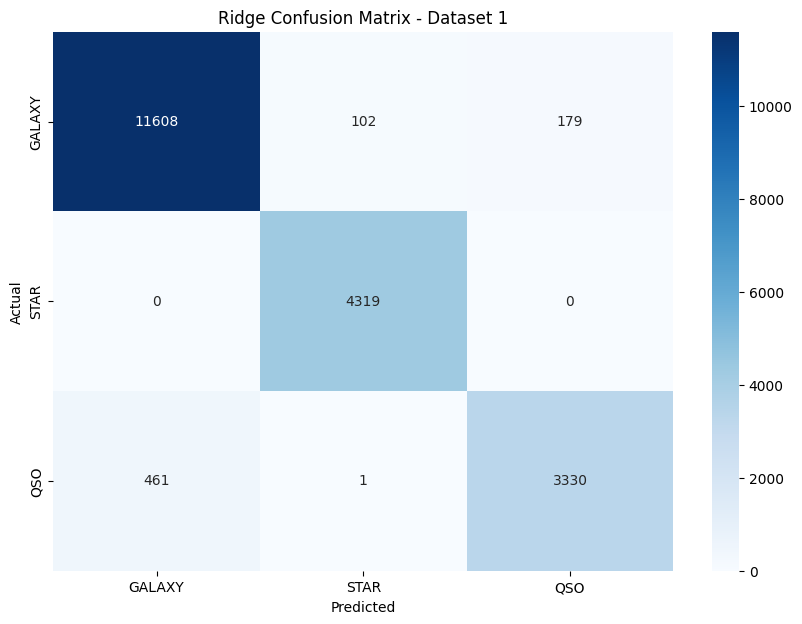

Dataset 2 - Best Parameters for Ridge: {'C': 100}
Dataset 2 - Train Accuracy: 0.9607333333333333
Dataset 2 - Test Accuracy: 0.9603
Dataset 2 - Ridge Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      5945
           1       0.97      1.00      0.99      2159
           2       0.94      0.88      0.91      1896

    accuracy                           0.96     10000
   macro avg       0.96      0.95      0.95     10000
weighted avg       0.96      0.96      0.96     10000



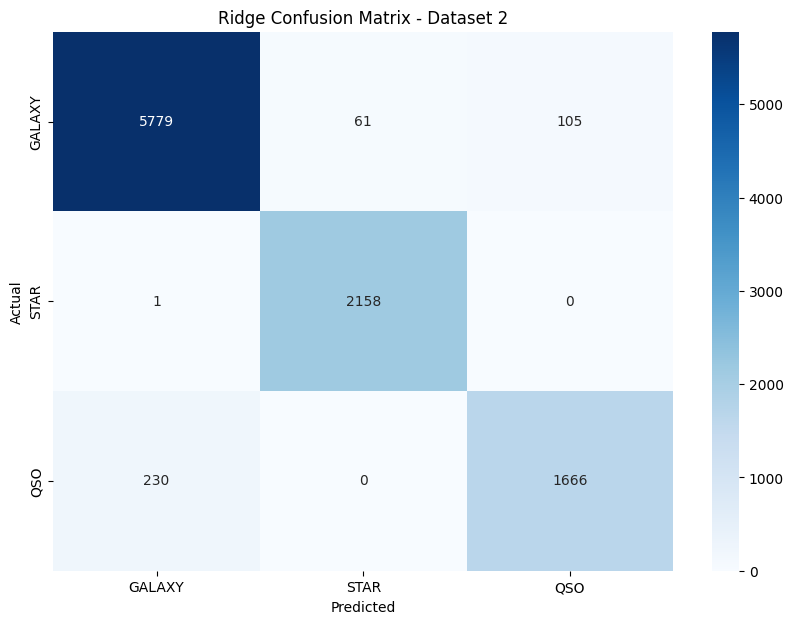

Dataset 3 - Best Parameters for Ridge: {'C': 100}
Dataset 3 - Train Accuracy: 0.9607157894736842
Dataset 3 - Test Accuracy: 0.9616
Dataset 3 - Ridge Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      2972
           1       0.97      1.00      0.99      1080
           2       0.94      0.89      0.91       948

    accuracy                           0.96      5000
   macro avg       0.96      0.95      0.96      5000
weighted avg       0.96      0.96      0.96      5000



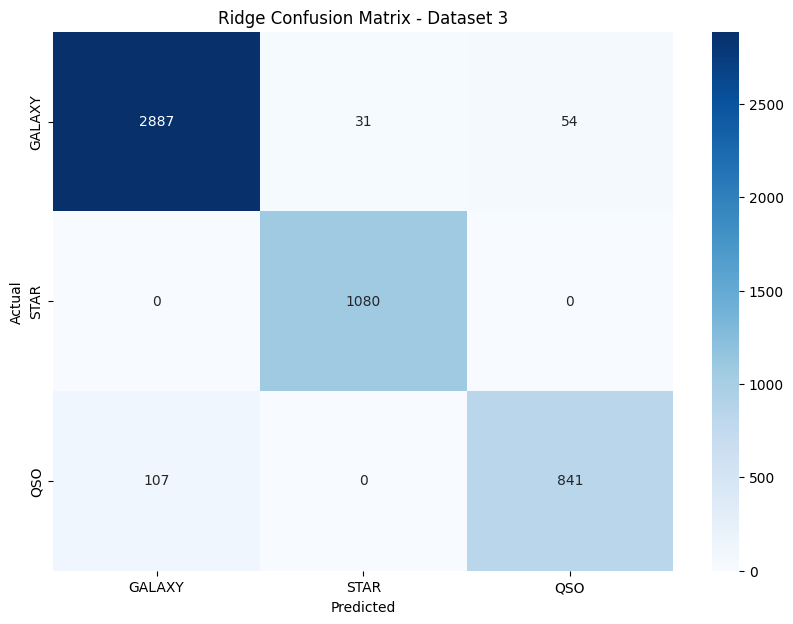

Dataset 4 - Best Parameters for Ridge: {'C': 100}
Dataset 4 - Train Accuracy: 0.9550004205568172
Dataset 4 - Test Accuracy: 0.9572153531275409
Dataset 4 - Ridge Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.93      0.94      0.94     11903
           1       0.99      1.00      0.99     12096
           2       0.95      0.93      0.94     11668

    accuracy                           0.96     35667
   macro avg       0.96      0.96      0.96     35667
weighted avg       0.96      0.96      0.96     35667



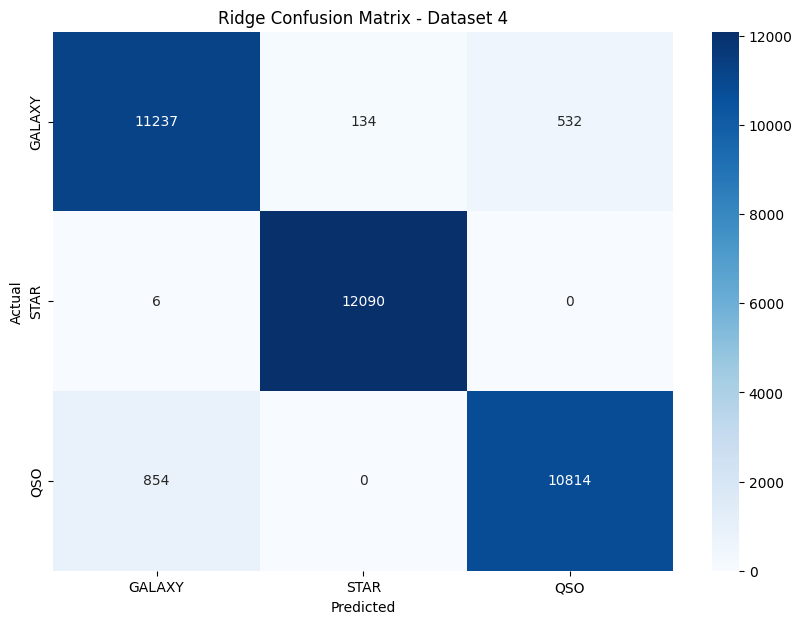

dataset_1 - Best Parameters: {'C': 100}
dataset_1 - Train Accuracy: 0.9585074832747086
dataset_1 - Test Accuracy: 0.96285
dataset_1 - Cohen's Kappa Score: 0.9336923622699671
dataset_1 - Confusion Matrix: 
[[11608   102   179]
 [    0  4319     0]
 [  461     1  3330]]
dataset_1 - Test F1 Score: 0.9623985534731695

dataset_2 - Best Parameters: {'C': 100}
dataset_2 - Train Accuracy: 0.9607333333333333
dataset_2 - Test Accuracy: 0.9603
dataset_2 - Cohen's Kappa Score: 0.9292611426128685
dataset_2 - Confusion Matrix: 
[[5779   61  105]
 [   1 2158    0]
 [ 230    0 1666]]
dataset_2 - Test F1 Score: 0.959879439886365

dataset_3 - Best Parameters: {'C': 100}
dataset_3 - Train Accuracy: 0.9607157894736842
dataset_3 - Test Accuracy: 0.9616
dataset_3 - Cohen's Kappa Score: 0.9316895758008046
dataset_3 - Confusion Matrix: 
[[2887   31   54]
 [   0 1080    0]
 [ 107    0  841]]
dataset_3 - Test F1 Score: 0.9612516673407515

dataset_4 - Best Parameters: {'C': 100}
dataset_4 - Train Accuracy: 0.955

In [ ]:
t0 = time.time()

datasets = [
    (X_tr_80, y_tr_80, X_te_80, y_te_80),
    (X_tr_90, y_tr_90, X_te_90, y_te_90),
    (X_tr_95, y_tr_95, X_te_95, y_te_95),
    (X_tr_smote, y_tr_smote, X_te_smote, y_te_smote )
]

param_grid_ridge = {'C': [0.01, 0.1, 1, 10, 100]}

results = {}
f1_scores_test = []

for i, (X_train, y_train, X_test, y_test) in enumerate(datasets):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    ridge = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)
    grid_search_ridge = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='accuracy')

    try:
        grid_search_ridge.fit(X_train_scaled, y_train)
    except Exception as e:
        print(f"GridSearchCV failed for dataset {i+1}: {e}")
        continue

    best_ridge_model = grid_search_ridge.best_estimator_

    y_test_pred_ridge = best_ridge_model.predict(X_test_scaled)
    y_train_pred_ridge = best_ridge_model.predict(X_train_scaled)

    test_accuracy_ridge = accuracy_score(y_test, y_test_pred_ridge)
    train_accuracy_ridge = accuracy_score(y_train, y_train_pred_ridge)
    f1_score_test_ridge = f1_score(y_test, y_test_pred_ridge, average='weighted')

    print(f"Dataset {i+1} - Best Parameters for Ridge: {grid_search_ridge.best_params_}")
    print(f"Dataset {i+1} - Train Accuracy: {train_accuracy_ridge}")
    print(f"Dataset {i+1} - Test Accuracy: {test_accuracy_ridge}")
    print(f"Dataset {i+1} - Ridge Classification Report (Test Set):\n", classification_report(y_test, y_test_pred_ridge))

    conf_matrix = confusion_matrix(y_test, y_test_pred_ridge)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['GALAXY', 'STAR', 'QSO'], yticklabels=['GALAXY', 'STAR', 'QSO'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Ridge Confusion Matrix - Dataset {i+1}')
    plt.show()

    kappa_score = cohen_kappa_score(y_test, y_test_pred_ridge)

    results[f'dataset_{i+1}'] = {
        'best_params': grid_search_ridge.best_params_,
        'train_accuracy': train_accuracy_ridge,
        'test_accuracy': test_accuracy_ridge,
        'kappa_score': kappa_score,
        'confusion_matrix': conf_matrix,
        'f1_score_test': f1_score_test_ridge
    }

    f1_scores_test.append(f1_score_test_ridge)

for dataset, result in results.items():
    print(f"{dataset} - Best Parameters: {result['best_params']}")
    print(f"{dataset} - Train Accuracy: {result['train_accuracy']}")
    print(f"{dataset} - Test Accuracy: {result['test_accuracy']}")
    print(f"{dataset} - Cohen's Kappa Score: {result['kappa_score']}")
    print(f"{dataset} - Confusion Matrix: \n{result['confusion_matrix']}")
    print(f"{dataset} - Test F1 Score: {result['f1_score_test']}")
    print()

t1 = time.time()
print("elapsed time:", (t1-t0) / 60, "minutes")



Again the first train-test split has the best performance with a test accuracy of 0.96285. For the ridge regression, we see that here the best value for C is 100 across all on the train tests. The Cohen kappa score is also basically the same across all the train cases, except for dataset 2, where we also that the test accuracy is lower compared to the rest.

Eventually after all the test we deduct that the model is able to perform better when it predicts STAR when it is acutally a GALAXY, but performs worse when the model predicts GALAXY but it is actually STAR.

Here is a visual of how the best f1 score compared with each train split.

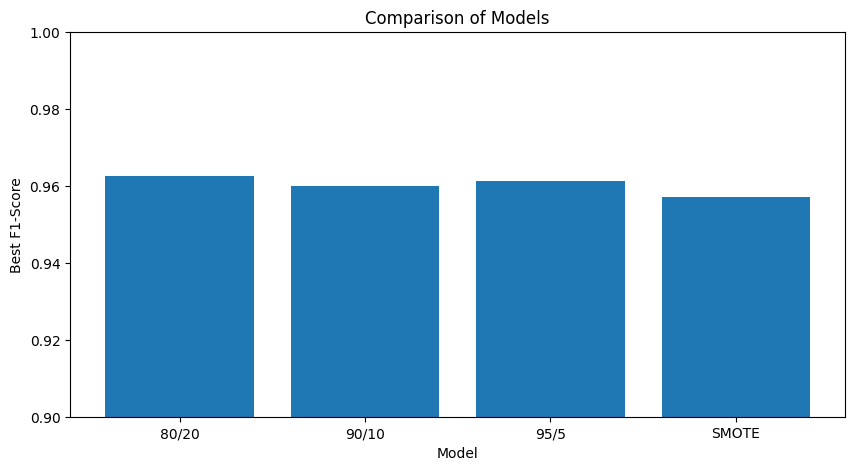

In [ ]:
model_names = ['80/20', '90/10', '95/5', 'SMOTE']
plt.figure(figsize=(10, 5))
plt.bar(range(len(f1_scores_test)), f1_scores_test)
plt.xlabel('Model')
plt.ylabel('Best F1-Score')
plt.ylim(0.9, 1)
plt.title('Comparison of Models')
plt.xticks(range(len(f1_scores_test)), model_names)
plt.show()

We see 80/20 and 95/5 performed slightly better than 90/10 and SMOTE

Now, we can have a look at which feature was the most importaint during the classifying training

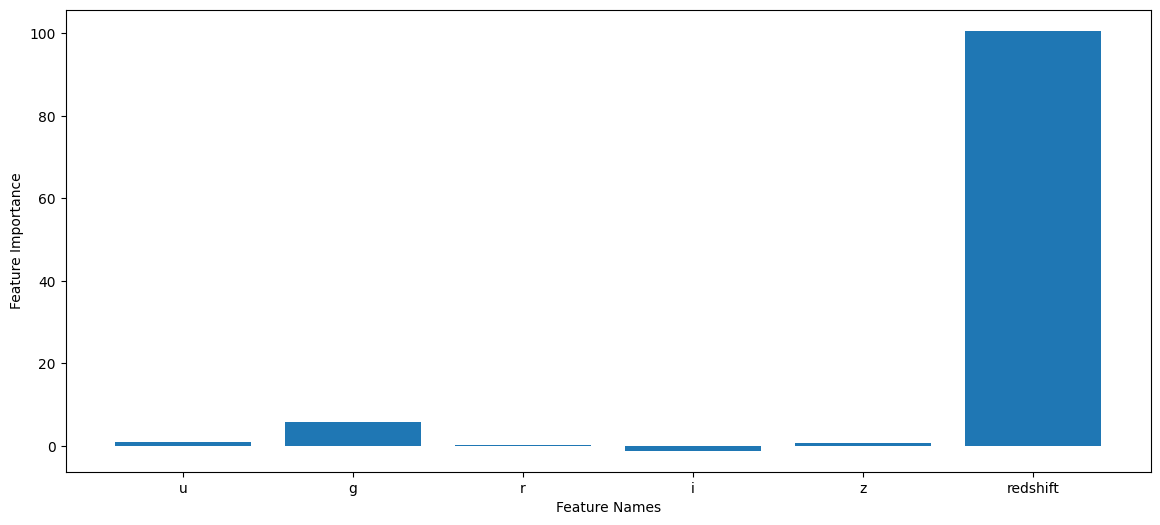

In [ ]:
plt.figure(figsize=(14, 6))
plt.bar(list(X_train.columns), best_ridge_model.coef_[0])
plt.xlabel("Feature Names")
plt.ylabel("Feature Importance")
plt.show()

Here we see th most importaint feature was redshift, followed by green and ultra violet light, with minimal contributions from red, near-infered and infered

##**The Decision-tree algorithm**

Now we want to implement a decisison-tree classifier. Firstly, decision-trees tend to overfit the train data massively, which can somehow be reduced by limiting the overall depth of the tree. In that way, the trees "have to decide" more rigorously and may generalize better. Being aware of that problem, we will firstly do some hyperparameter tuning.

In [ ]:
t0 = time.time()

train_sets = [
    (X_tr_80, y_tr_80),
    (X_tr_90, y_tr_90),
    (X_tr_95, y_tr_95),
    (X_tr_smote, y_tr_smote)
]
test_sets = [
    (X_te_80, y_te_80),
    (X_te_90, y_te_90),
    (X_te_95, y_te_95),
    (X_te_smote, y_te_smote)
]

param_grid = {'max_depth': list(range(1, 21))}

pipes_individual = []

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='f1_weighted')

best_pipe = None
best_score = float('-inf')

for i, (X, y) in enumerate(train_sets):
    grid_search.fit(X, y)
    print(f"Best max_depth for split {i + 1}:", grid_search.best_params_)
    print('Best CV score:' , grid_search.best_score_)
    pipe_i =Pipeline([
      ('scaler', StandardScaler()),
      ('tree', DecisionTreeClassifier(max_depth=grid_search.best_params_['max_depth']))])
    pipe_i.fit(X, y)
    pipes_individual.append(pipe_i)
    print(f"Train set f1-score for split {i}: {round(pipe_i.score(X,y) * 100, 4)}%")
    print()
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_pipe = pipe_i

if best_pipe:
    export_graphviz(best_pipe.named_steps['tree'],
                    out_file="stellar_objects_tree.dot", # name of the DOT file
                    feature_names=["u", "g", "r","i","z","redshift"],
                    class_names=["Galaxy", "Star","Quasar"],
                    rounded=True,
                    filled=True)

for i ,(X,y) in enumerate(test_sets):
    pipe = pipes_individual[i]
    pipe.predict(X)
    report = classification_report(y,pipe.predict(X) )
    print(f"Test set f1-score for split {i+1}: {round(pipe.score(X,y) * 100, 4)}%")
    print("Classification report:")
    print(report)
    print("----------")
    print()

t1 = time.time()
print("Elapsed time:", (t1 - t0)/60, "minutes")


Best max_depth for split 1: {'max_depth': 9}
Best CV score: 0.9710255391441184
Train set f1-score for split 0: 97.9621%

Best max_depth for split 2: {'max_depth': 9}
Best CV score: 0.9744862359121397
Train set f1-score for split 1: 98.0078%

Best max_depth for split 3: {'max_depth': 9}
Best CV score: 0.9742604828229672
Train set f1-score for split 2: 97.9705%

Best max_depth for split 4: {'max_depth': 11}
Best CV score: 0.9730615910304623
Train set f1-score for split 3: 98.1958%

Test set f1-score for split 1: 97.215%
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     11889
           1       0.99      1.00      1.00      4319
           2       0.95      0.90      0.93      3792

    accuracy                           0.97     20000
   macro avg       0.97      0.96      0.97     20000
weighted avg       0.97      0.97      0.97     20000

----------

Test set f1-score for split 2: 97.34%
Classification report:

Overall we can say that for every split, our model works really good. However, the 95/5-split performes best on the test set, so we will visualize this tree in the next step.

Visualizing the tree

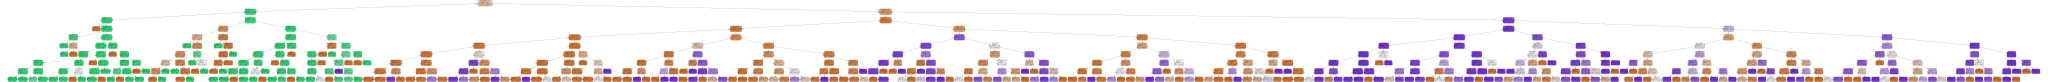

In [ ]:
Source.from_file("stellar_objects_tree.dot")

It is also quite interesting to show which features are important and which are not.

[0.01311536 0.04836229 0.00345795 0.00736257 0.0050644  0.92263742]


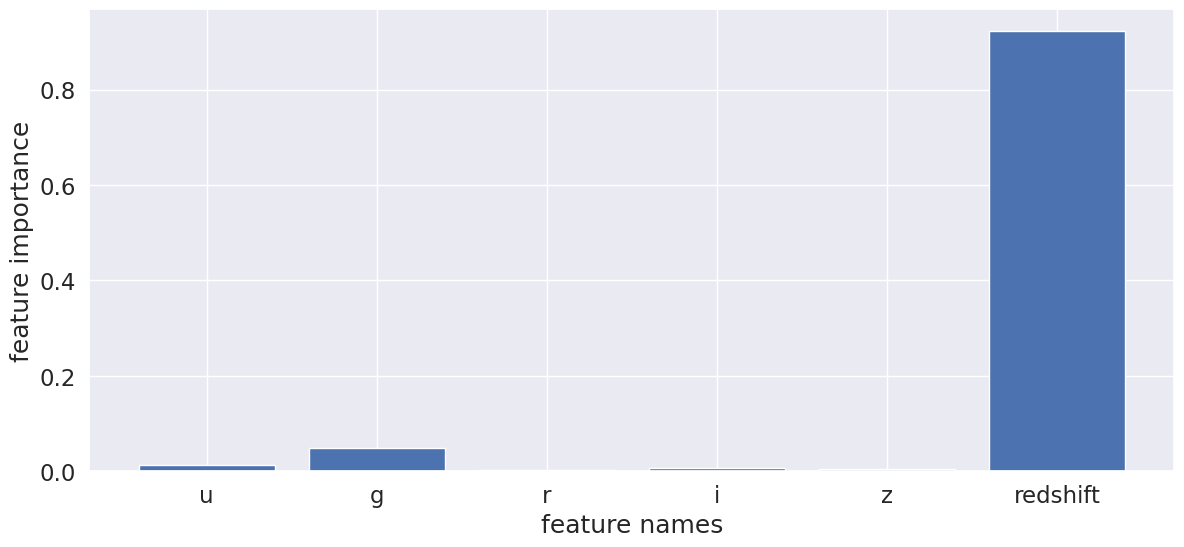

In [ ]:
sns.set(font_scale=1.5)
print(best_pipe.named_steps['tree'].feature_importances_)

plt.figure(figsize=(14,6))
plt.bar(list(X_tr_smote.columns),
        best_pipe.named_steps['tree'].feature_importances_)
plt.xlabel("feature names")
plt.ylabel("feature importance")
plt.show()

As we can see, the redshift is by far the most important feature in order to classify stars, galaxies or quasars. This makes quite a lot of sense, because the redshift indicates the distance to our earth, which can potentially a good indicator of the class of the object, as we already pointed out in the first part of the project.

But still, there are known to be better classifiers, such as the following random-forest algorithm or HGB.

##**The Random-forest algorithm**


Random Forest is an ensemble learning method used for classification and regression tasks. It builds multiple decision trees during training and merges their results to improve accuracy and control overfitting. Each tree in the forest is trained on a different subset of the data, and the final prediction is based on the majority vote for classification or average prediction for regression.

Performing even bigger grid search would be very costly in terms of time. For some models we will be using the experimental Halving Grid Search which is way faster than the normal one.


In [ ]:
datasets = [
    (X_tr_80, y_tr_80, '80/20 split'),
    (X_tr_90, y_tr_90, '90/10 split'),
    (X_tr_95, y_tr_95, '95/5 split'),
    (X_tr_smote, y_tr_smote, 'SMOTE split')
]

pipeline_rfc = Pipeline([
    ('random_forest', RandomForestClassifier())
])

param_grid_rfc = {
    'random_forest__max_features': ['sqrt', 'log2'],
    'random_forest__max_depth': [1, 5, 10],
    'random_forest__min_samples_split': [2, 5, 10],
    'random_forest__min_samples_leaf': [1, 2, 4],
}

for X, y, split_name in datasets:
    halving_grid_search = HalvingGridSearchCV(pipeline_rfc, param_grid_rfc, cv=5, n_jobs=-1)
    halving_grid_search.fit(X, y)
    print(f"Best parameters for {split_name}:", halving_grid_search.best_params_)
    print('Best CV score:' , halving_grid_search.best_score_)

Best parameters for 80/20 split: {'random_forest__max_depth': 10, 'random_forest__max_features': 'sqrt', 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 5}
Best CV score: 0.9759238830667403
Best parameters for 90/10 split: {'random_forest__max_depth': 10, 'random_forest__max_features': 'log2', 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 2}
Best CV score: 0.9769974441604623
Best parameters for 95/5 split: {'random_forest__max_depth': 10, 'random_forest__max_features': 'sqrt', 'random_forest__min_samples_leaf': 2, 'random_forest__min_samples_split': 5}
Best CV score: 0.9772911512344054
Best parameters for SMOTE split: {'random_forest__max_depth': 10, 'random_forest__max_features': 'log2', 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 5}
Best CV score: 0.9740516472681972


max_features: The number of features to consider when looking for the best
split. Common options are 'sqrt' and 'log2'.

max_depth: The maximum depth of each tree. Limiting the depth prevents overfitting.

min_samples_split: The minimum number of samples required to split an internal node. Higher values prevent overfitting by making the model more general.

min_samples_leaf: The minimum number of samples required to be at a leaf node. Ensures that leaf nodes have enough samples to make reliable predictions.

Now we will evaluate multiple Random Forest Classifier models using different train-test splits.

Model: rfc_80
Cross Validation Scores: [0.97697663 0.97704556 0.97656142 0.97518268 0.97511375]
Average Cross Validation Score: 0.9761760096208991
Train Accuracy: 0.9812634423426901
Test Accuracy: 0.97515


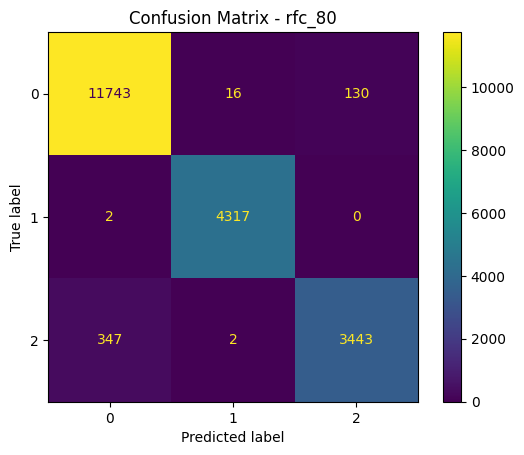

Cohen's Kappa Score: 0.9556183687106357
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     11889
           1       1.00      1.00      1.00      4319
           2       0.96      0.91      0.93      3792

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.97     20000
weighted avg       0.98      0.98      0.97     20000

----------------------------------------
Model: rfc_90
Cross Validation Scores: [0.97838889 0.97733333 0.97761111 0.97616667 0.97733333]
Average Cross Validation Score: 0.9773666666666665
Train Accuracy: 0.9815333333333334
Test Accuracy: 0.9781


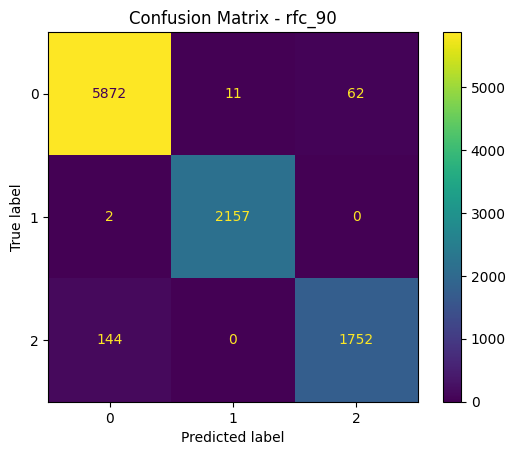

Cohen's Kappa Score: 0.9609646083750272
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5945
           1       0.99      1.00      1.00      2159
           2       0.97      0.92      0.94      1896

    accuracy                           0.98     10000
   macro avg       0.98      0.97      0.97     10000
weighted avg       0.98      0.98      0.98     10000

----------------------------------------
Model: rfc_95
Cross Validation Scores: [0.97794737 0.97773684 0.97647368 0.97742105 0.97657895]
Average Cross Validation Score: 0.9772315789473683
Train Accuracy: 0.9809473684210527
Test Accuracy: 0.9776


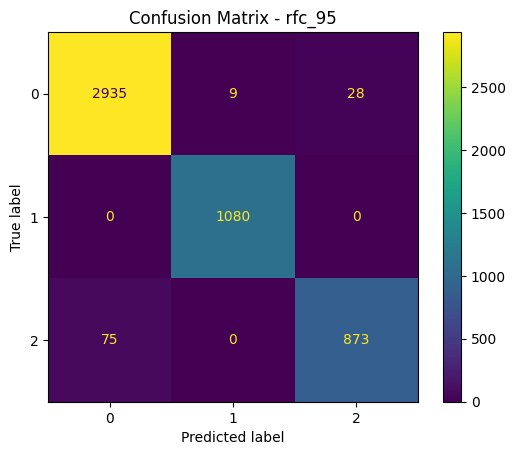

Cohen's Kappa Score: 0.9600684882471578
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2972
           1       0.99      1.00      1.00      1080
           2       0.97      0.92      0.94       948

    accuracy                           0.98      5000
   macro avg       0.98      0.97      0.97      5000
weighted avg       0.98      0.98      0.98      5000

----------------------------------------
Model: rfc_smote
Cross Validation Scores: [0.97276933 0.97420621 0.97406603 0.9760628  0.97262818]
Average Cross Validation Score: 0.9739465107660292
Train Accuracy: 0.9770235792188858
Test Accuracy: 0.9737852917262455


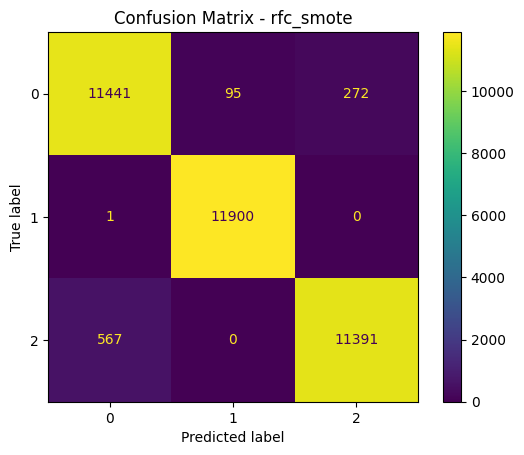

Cohen's Kappa Score: 0.9606790522756725
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     11808
           1       0.99      1.00      1.00     11901
           2       0.98      0.95      0.96     11958

    accuracy                           0.97     35667
   macro avg       0.97      0.97      0.97     35667
weighted avg       0.97      0.97      0.97     35667

----------------------------------------
elapsed time 34.685623383522035 minutes


In [ ]:
t0 = time.time()
models = {
    'rfc_80': RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=5, min_samples_leaf=1, max_features='sqrt', n_jobs=-1),
    'rfc_90': RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features='log2', n_jobs=-1),
    'rfc_95': RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', n_jobs=-1),
    'rfc_smote': RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=5, min_samples_leaf=1, max_features='log2', n_jobs=-1)
}

trained_models = {}

for model_name, model in models.items():
    print(f"Model: {model_name}")

    if model_name == 'rfc_80':
        X_tr, X_te, y_tr, y_te = X_tr_80, X_te_80, y_tr_80, y_te_80
    elif model_name == 'rfc_90':
        X_tr, X_te, y_tr, y_te = X_tr_90, X_te_90, y_tr_90, y_te_90
    elif model_name == 'rfc_95':
        X_tr, X_te, y_tr, y_te = X_tr_95, X_te_95, y_tr_95, y_te_95
    elif model_name == 'rfc_smote':
        X_tr, X_te, y_tr, y_te = X_tr_smote, X_te_smote, y_tr_smote, y_te_smote
    scores = cross_val_score(model, X_tr, y_tr, cv=5)
    print("Cross Validation Scores:", scores)
    print("Average Cross Validation Score:", scores.mean())

    model.fit(X_tr, y_tr)
    trained_models[model_name] = model

    train_accuracy = model.score(X_tr, y_tr)
    print("Train Accuracy:", train_accuracy)

    test_accuracy = model.score(X_te, y_te)
    print("Test Accuracy:", test_accuracy)

    y_pred = model.predict(X_te)
    cm = confusion_matrix(y_te, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format='')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    kappa = cohen_kappa_score(y_te, y_pred)
    print(f"Cohen's Kappa Score: {kappa}")

    report = classification_report(y_te, y_pred)
    print("Classification Report:")
    print(report)

    print("----------------------------------------")
t1 = time.time()
print("elapsed time", (t1 - t0)/60, "minutes")

After 35 minutes we can see that there are very small differences between all rfc models. Although rfc_95 has the best score.

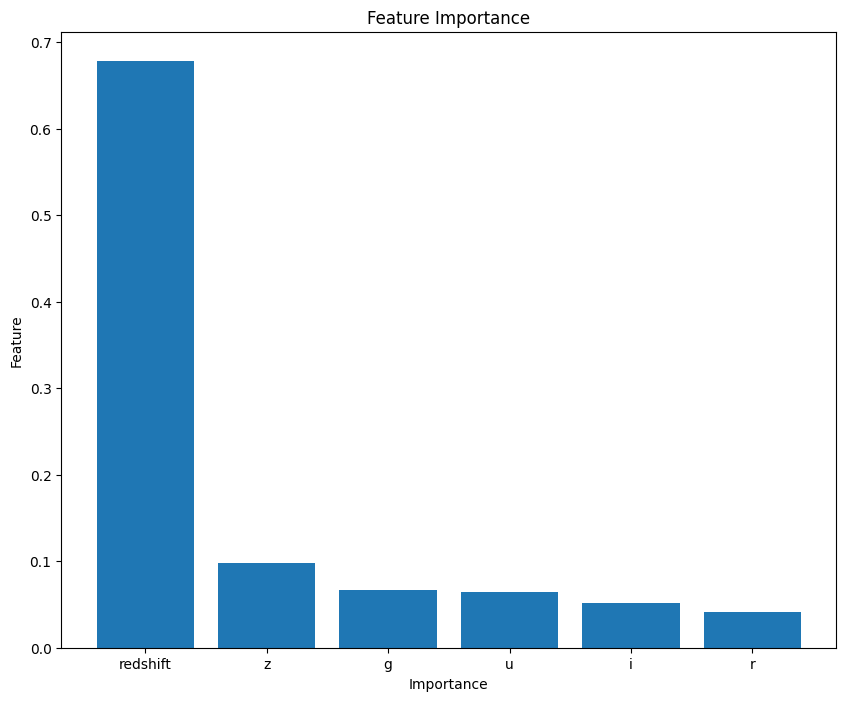

In [ ]:
rfc_95 = trained_models['rfc_95']
feature_importances_rfc = rfc_95.feature_importances_
feature_names = X_tr.columns

feature_importance_df_rfc = pd.DataFrame({
    'Importance': feature_importances_rfc,
    'Feature': feature_names
})

feature_importance_df_rfc = feature_importance_df_rfc.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.bar(feature_importance_df_rfc['Feature'], feature_importance_df_rfc['Importance'])
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

##**Extra Tree**



ExtraTreesClassifier (Extremely Randomized Trees) is an ensemble learning method similar to Random Forest but with some key differences. While Random Forest builds each tree using a bootstrap sample of the data and optimizes splits for each node, ExtraTreesClassifier uses the entire dataset and selects splits at random. This additional randomness typically results in a model that has lower variance but slightly higher bias, often leading to better generalization.

In [ ]:
datasets = [
    (X_tr_80, y_tr_80, '80/20 split'),
    (X_tr_90, y_tr_90, '90/10 split'),
    (X_tr_95, y_tr_95, '95/5 split'),
    (X_tr_smote, y_tr_smote, 'SMOTE split')
]

pipeline_ETC = Pipeline([
    ('extra_tree', ExtraTreesClassifier())
])

param_grid_ETC = {
    'extra_tree__max_features': ['sqrt', 'log2'],
    'extra_tree__max_depth': [1, 5, 10],
    'extra_tree__min_samples_split': [2, 5, 10],
    'extra_tree__min_samples_leaf': [1, 2, 4],
}

for X, y, split_name in datasets:
    halving_grid_search2 = HalvingGridSearchCV(pipeline_ETC, param_grid_ETC, cv=5, n_jobs=-1)
    halving_grid_search2.fit(X, y)
    print(f"Best parameters for {split_name}:", halving_grid_search2.best_params_)
    print('Best CV score:' , halving_grid_search2.best_score_)

Best parameters for 80/20 split: {'extra_tree__max_depth': 10, 'extra_tree__max_features': 'sqrt', 'extra_tree__min_samples_leaf': 1, 'extra_tree__min_samples_split': 2}
Best CV score: 0.9630584666298951
Best parameters for 90/10 split: {'extra_tree__max_depth': 10, 'extra_tree__max_features': 'sqrt', 'extra_tree__min_samples_leaf': 1, 'extra_tree__min_samples_split': 5}
Best CV score: 0.9486609623291477
Best parameters for 95/5 split: {'extra_tree__max_depth': 10, 'extra_tree__max_features': 'sqrt', 'extra_tree__min_samples_leaf': 1, 'extra_tree__min_samples_split': 2}
Best CV score: 0.9527293783228931
Best parameters for SMOTE split: {'extra_tree__max_depth': 10, 'extra_tree__max_features': 'sqrt', 'extra_tree__min_samples_leaf': 1, 'extra_tree__min_samples_split': 10}
Best CV score: 0.9495120868176794


max_features: The number of features to consider when looking for the best
split. Common options are 'sqrt' and 'log2'.

max_depth: The maximum depth of each tree. Limiting the depth prevents overfitting.

min_samples_split: The minimum number of samples required to split an internal node. Higher values prevent overfitting by making the model more general.

min_samples_leaf: The minimum number of samples required to be at a leaf node. Ensures that leaf nodes have enough samples to make reliable predictions.

Evaluation of each Extra Tree Classifier with different train-test splits.

Model: ETC_80
Cross Validation Scores: [0.96360378 0.9644999  0.96339446 0.9616021  0.96380808]
Average Cross Validation Score: 0.9633816613308411
Train Accuracy: 0.9644432802073567
Test Accuracy: 0.9656


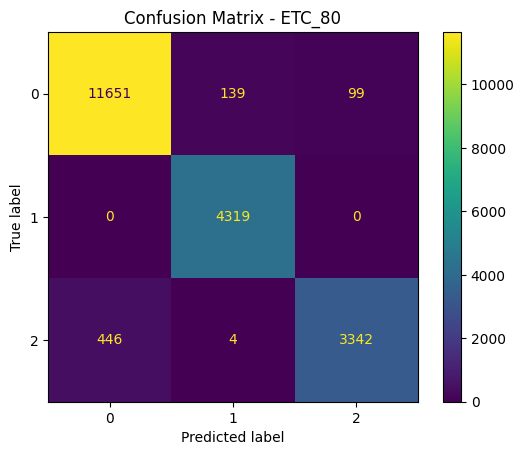

Cohen's Kappa Score: 0.9385327692505818
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     11889
           1       0.97      1.00      0.98      4319
           2       0.97      0.88      0.92      3792

    accuracy                           0.97     20000
   macro avg       0.97      0.95      0.96     20000
weighted avg       0.97      0.97      0.97     20000

----------------------------------------
Model: ETC_90
Cross Validation Scores: [0.94377778 0.94666667 0.95377778 0.94994444 0.94516667]
Average Cross Validation Score: 0.9478666666666665
Train Accuracy: 0.9496333333333333
Test Accuracy: 0.9509


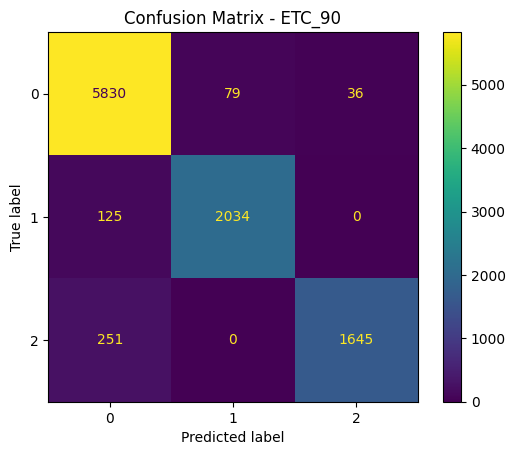

Cohen's Kappa Score: 0.9113016942442225
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      5945
           1       0.96      0.94      0.95      2159
           2       0.98      0.87      0.92      1896

    accuracy                           0.95     10000
   macro avg       0.96      0.93      0.94     10000
weighted avg       0.95      0.95      0.95     10000

----------------------------------------
Model: ETC_95
Cross Validation Scores: [0.94515789 0.948      0.94673684 0.95563158 0.94636842]
Average Cross Validation Score: 0.948378947368421
Train Accuracy: 0.9533684210526315
Test Accuracy: 0.955


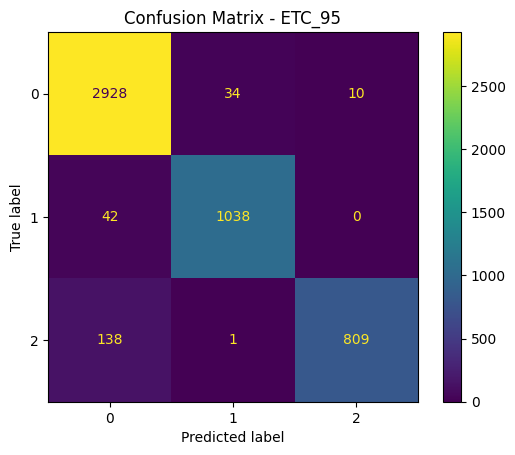

Cohen's Kappa Score: 0.9186419909150947
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2972
           1       0.97      0.96      0.96      1080
           2       0.99      0.85      0.92       948

    accuracy                           0.95      5000
   macro avg       0.97      0.93      0.95      5000
weighted avg       0.96      0.95      0.95      5000

----------------------------------------
Model: ETC_smote
Cross Validation Scores: [0.94774655 0.94928857 0.95044508 0.95216066 0.94697368]
Average Cross Validation Score: 0.9493229069484522
Train Accuracy: 0.9447107970953542
Test Accuracy: 0.9443182773992767


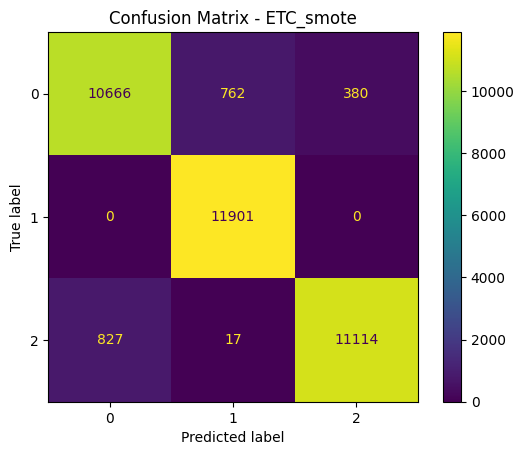

Cohen's Kappa Score: 0.9164760064855207
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92     11808
           1       0.94      1.00      0.97     11901
           2       0.97      0.93      0.95     11958

    accuracy                           0.94     35667
   macro avg       0.94      0.94      0.94     35667
weighted avg       0.94      0.94      0.94     35667

----------------------------------------
elapsed time 5.154664834340413 minutes


In [ ]:
t0 = time.time()
models = {
    'ETC_80': ExtraTreesClassifier(n_estimators=500, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', n_jobs=-1),
    'ETC_90': ExtraTreesClassifier(n_estimators=500, max_depth=10, min_samples_split=5, min_samples_leaf=1, max_features='sqrt', n_jobs=-1),
    'ETC_95': ExtraTreesClassifier(n_estimators=500, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', n_jobs=-1),
    'ETC_smote': ExtraTreesClassifier(n_estimators=500, max_depth=10, min_samples_split=10, min_samples_leaf=1, max_features='sqrt', n_jobs=-1)
}

trained_models = {}

for model_name, model in models.items():
    print(f"Model: {model_name}")

    if model_name == 'ETC_80':
        X_tr, X_te, y_tr, y_te = X_tr_80, X_te_80, y_tr_80, y_te_80
    elif model_name == 'ETC_90':
        X_tr, X_te, y_tr, y_te = X_tr_90, X_te_90, y_tr_90, y_te_90
    elif model_name == 'ETC_95':
        X_tr, X_te, y_tr, y_te = X_tr_95, X_te_95, y_tr_95, y_te_95
    elif model_name == 'ETC_smote':
        X_tr, X_te, y_tr, y_te = X_tr_smote, X_te_smote, y_tr_smote, y_te_smote

    scores = cross_val_score(model, X_tr, y_tr, cv=5)
    print("Cross Validation Scores:", scores)
    print("Average Cross Validation Score:", scores.mean())

    model.fit(X_tr, y_tr)
    trained_models[model_name] = model

    train_accuracy = model.score(X_tr, y_tr)
    print("Train Accuracy:", train_accuracy)

    test_accuracy = model.score(X_te, y_te)
    print("Test Accuracy:", test_accuracy)

    y_pred = model.predict(X_te)
    cm = confusion_matrix(y_te, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format='')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    kappa = cohen_kappa_score(y_te, y_pred)
    print(f"Cohen's Kappa Score: {kappa}")

    report = classification_report(y_te, y_pred)
    print("Classification Report:")
    print(report)

    print("----------------------------------------")
t1 = time.time()
print("elapsed time", (t1 - t0)/60, "minutes")

After just 5 minutes we got our results, Smote has the best performance.
Extra Forest in comparision to Random Forest is a little bit worse but it is way faster.

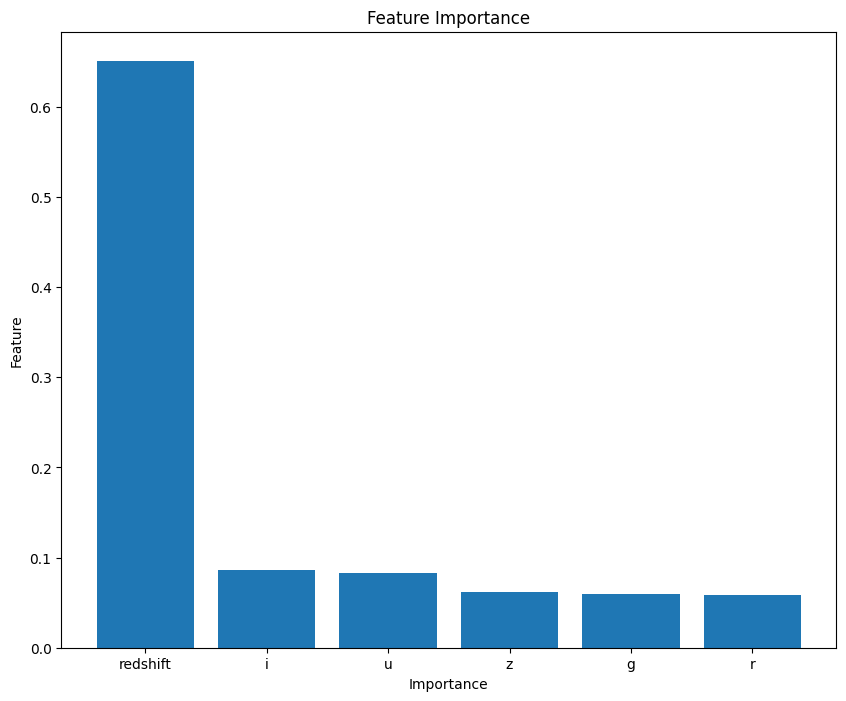

In [ ]:
ETC_80 = trained_models['ETC_80']
feature_importances_ETC = ETC_80.feature_importances_
feature_names = X_tr.columns

feature_importance_df_ETC = pd.DataFrame({
    'Importance': feature_importances_ETC,
    'Feature': feature_names
})

feature_importance_df_ETC = feature_importance_df_ETC.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.bar(feature_importance_df_ETC['Feature'], feature_importance_df_ETC['Importance'])
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

##**The Support Vector Machines algorithm**

Sapport Vector Machines finds the best hyperplane that seperates one class from another. The "best" hyperplane is based on finding the largest margin sepearting the classes. See figure bellow:

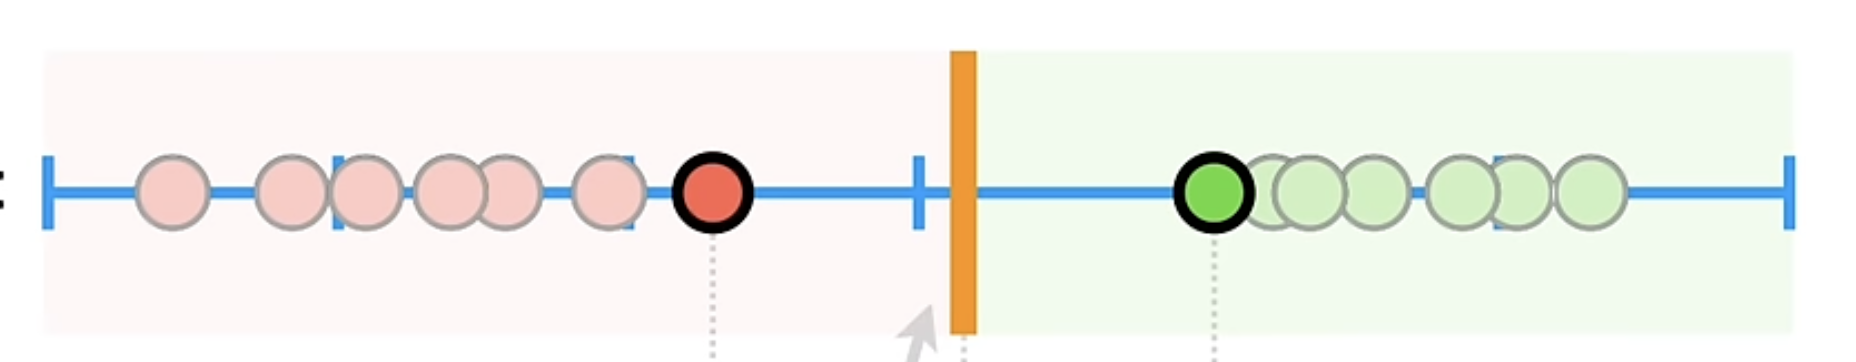

https://www.youtube.com/watch?v=efR1C6CvhmE&t=48s

But one of the issues is that if there is an outlier, then the hyperplane will overfit, reducing the accuracy of the test set:

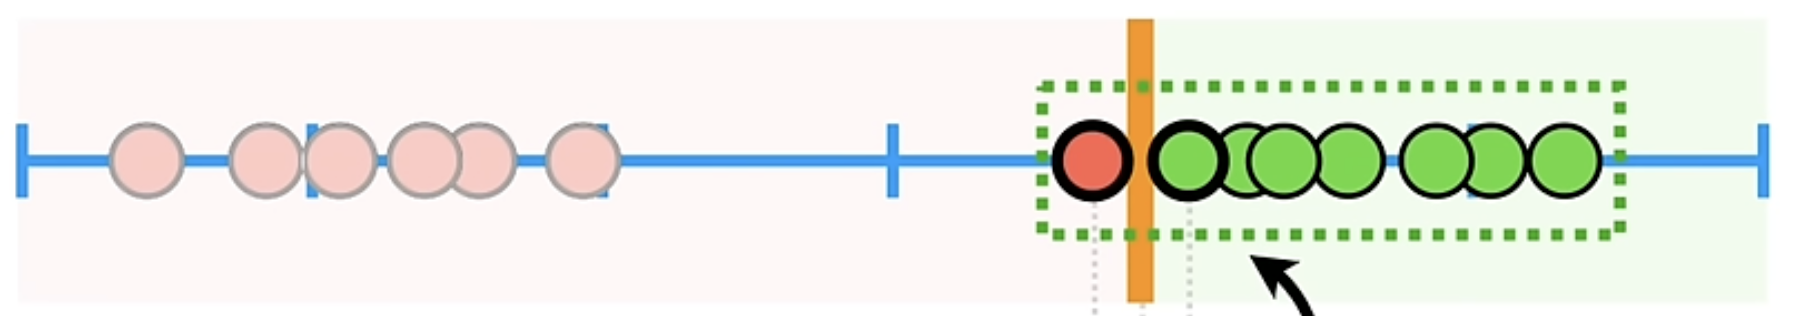

To fix this we must allow misclassification which is know as bias/variance trade-off. We do this by adapting the value for **C**. Normally, the value is 1.0. The margin between the observation and threshhold is called the soft margin. Since they can allow misclassifications it makes it good for datasets with outliers.

**Advantages**




• Effective in high dimensional spaces.






• Uses a subset of training points in the decision function (called support vectors), so it is also memory
efficient in certain cases.


• Versatile: different Kernel functions can be specified for the decision function.

**Disadavantages**


• If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel
functions and regularization term is crucial.


• SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-
validation

### Basic implementation (with kernel RBF)

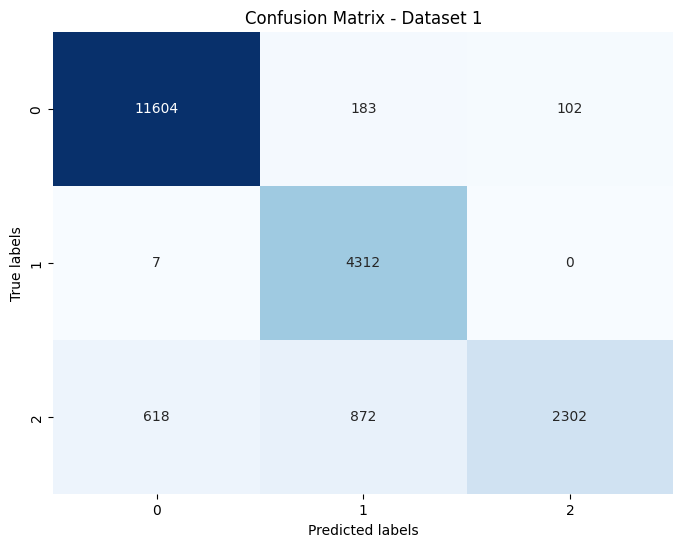

Dataset 1 - Training Accuracy: 96.60%
Dataset 1 - Testing Accuracy: 91.09%
Dataset 1 - Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96     11889
           1       0.80      1.00      0.89      4319
           2       0.96      0.61      0.74      3792

    accuracy                           0.91     20000
   macro avg       0.90      0.86      0.87     20000
weighted avg       0.92      0.91      0.91     20000



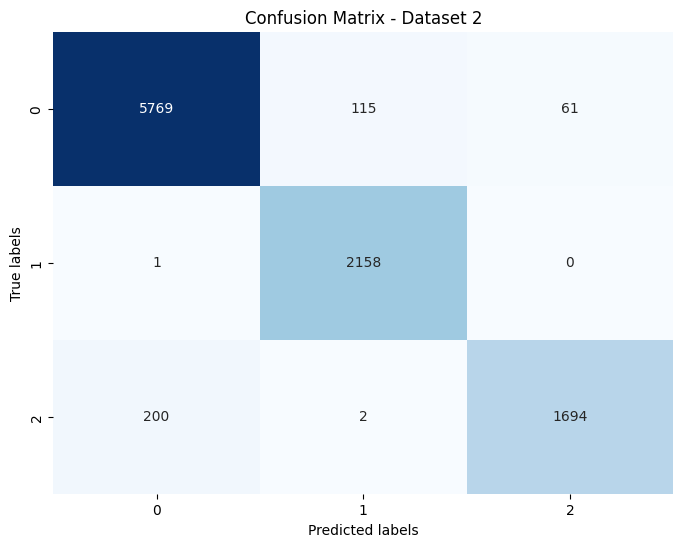

Dataset 2 - Training Accuracy: 96.22%
Dataset 2 - Testing Accuracy: 96.21%
Dataset 2 - Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      5945
           1       0.95      1.00      0.97      2159
           2       0.97      0.89      0.93      1896

    accuracy                           0.96     10000
   macro avg       0.96      0.95      0.96     10000
weighted avg       0.96      0.96      0.96     10000



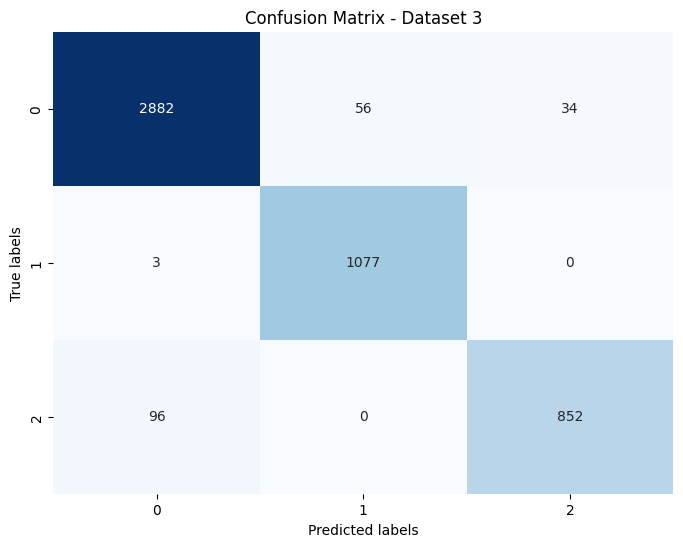

Dataset 3 - Training Accuracy: 96.23%
Dataset 3 - Testing Accuracy: 96.22%
Dataset 3 - Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      2972
           1       0.95      1.00      0.97      1080
           2       0.96      0.90      0.93       948

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



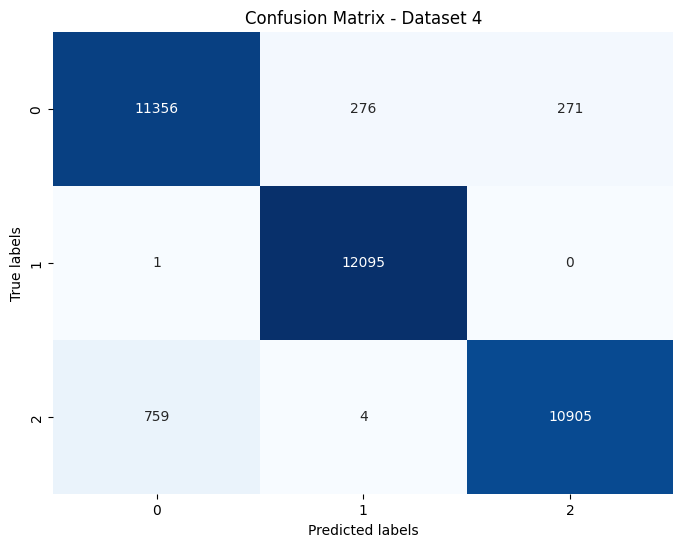

Dataset 4 - Training Accuracy: 96.07%
Dataset 4 - Testing Accuracy: 96.32%
Dataset 4 - Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95     11903
           1       0.98      1.00      0.99     12096
           2       0.98      0.93      0.95     11668

    accuracy                           0.96     35667
   macro avg       0.96      0.96      0.96     35667
weighted avg       0.96      0.96      0.96     35667

dataset_1 - Train Accuracy: 0.9659562728464032
dataset_1 - Test Accuracy: 0.9109
dataset_1 - Cohen's Kappa Score: 0.839685761061127
dataset_1 - Confusion Matrix: 
[[11604   183   102]
 [    7  4312     0]
 [  618   872  2302]]

dataset_2 - Train Accuracy: 0.9621888888888889
dataset_2 - Test Accuracy: 0.9621
dataset_2 - Cohen's Kappa Score: 0.9326451468206954
dataset_2 - Confusion Matrix: 
[[5769  115   61]
 [   1 2158    0]
 [ 200    2 1694]]

dataset_3 - Train Accuracy: 0.9622947368421053
dataset_3 - T

In [ ]:
t0 = time.time()

datasets = [
    (X_tr_80, y_tr_80, X_te_80, y_te_80),
    (X_tr_90, y_tr_90, X_te_90, y_te_90),
    (X_tr_95, y_tr_95, X_te_95, y_te_95),
    (X_tr_smote, y_tr_smote, X_te_smote, y_te_smote)
]

results = {}

for i, (X_train, y_train, X_test, y_test) in enumerate(datasets):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', gamma='scale', C=1.0))
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - Dataset {i+1}')
    plt.show()

    training_accuracy = pipeline.score(X_train, y_train)
    testing_accuracy = pipeline.score(X_test, y_test)

    print(f"Dataset {i+1} - Training Accuracy: {training_accuracy * 100:.2f}%")
    print(f"Dataset {i+1} - Testing Accuracy: {testing_accuracy * 100:.2f}%")
    print(f"Dataset {i+1} - Classification Report:\n", classification_report(y_test, y_pred))

    kappa_score = cohen_kappa_score(y_test, y_pred)

    results[f'dataset_{i+1}'] = {
        'train_accuracy': training_accuracy,
        'test_accuracy': testing_accuracy,
        'kappa_score': kappa_score,
        'confusion_matrix': conf_matrix
    }

for dataset, result in results.items():
    print(f"{dataset} - Train Accuracy: {result['train_accuracy']}")
    print(f"{dataset} - Test Accuracy: {result['test_accuracy']}")
    print(f"{dataset} - Cohen's Kappa Score: {result['kappa_score']}")
    print(f"{dataset} - Confusion Matrix: \n{result['confusion_matrix']}")
    print()
t1 = time.time()
print("elapsed time:", (t1-t0) / 60, "minutes")


dataset_4 had the best performence with 0.963243334174447

### Finding best soft margin using cross validation

Now we can improve this by finding the best soft-margin. This will help us understand how many misclassifications are allowed. This should help in getting the best classification. We would do this using cross-validation.

Fitting 2 folds for each of 8 candidates, totalling 16 fits


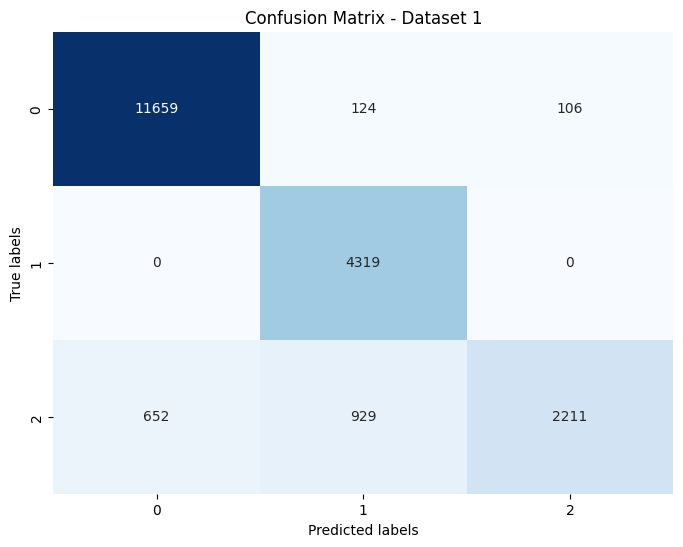

Dataset 1 - Best Parameters: {'pca__n_components': 5, 'svm__C': 100, 'svm__gamma': 'scale'}
Dataset 1 - Training Accuracy: 97.23%
Dataset 1 - Testing Accuracy: 90.94%
Dataset 1 - Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96     11889
           1       0.80      1.00      0.89      4319
           2       0.95      0.58      0.72      3792

    accuracy                           0.91     20000
   macro avg       0.90      0.85      0.86     20000
weighted avg       0.92      0.91      0.90     20000

Fitting 2 folds for each of 8 candidates, totalling 16 fits


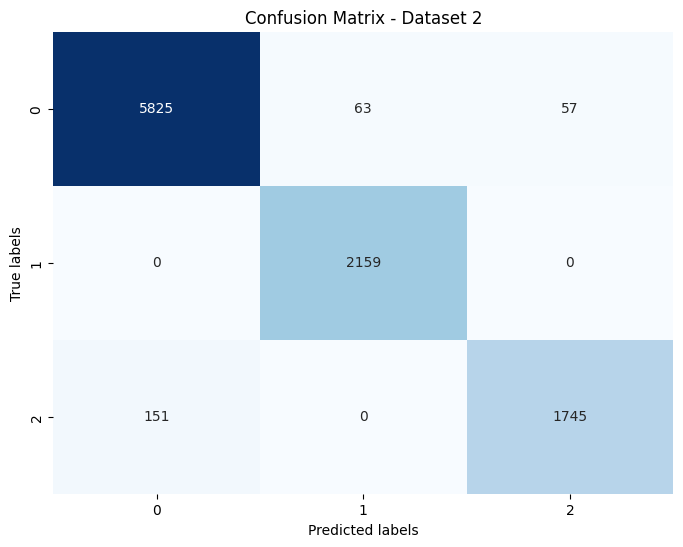

Dataset 2 - Best Parameters: {'pca__n_components': 5, 'svm__C': 100, 'svm__gamma': 'auto'}
Dataset 2 - Training Accuracy: 97.37%
Dataset 2 - Testing Accuracy: 97.29%
Dataset 2 - Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      5945
           1       0.97      1.00      0.99      2159
           2       0.97      0.92      0.94      1896

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Fitting 2 folds for each of 8 candidates, totalling 16 fits


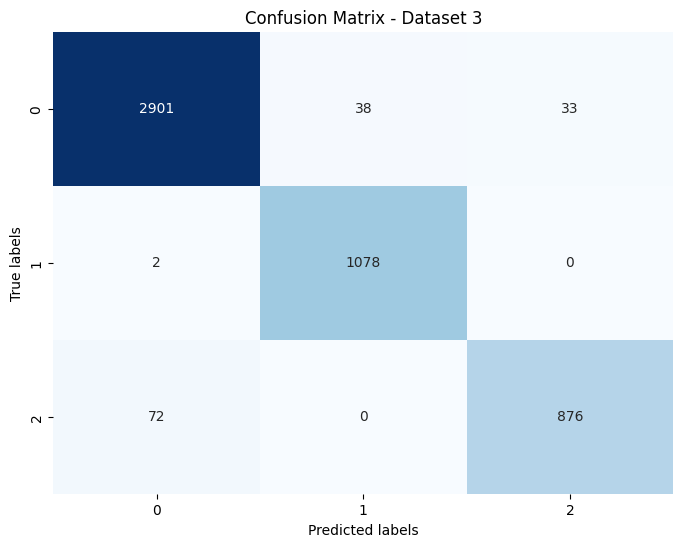

Dataset 3 - Best Parameters: {'pca__n_components': 5, 'svm__C': 100, 'svm__gamma': 'auto'}
Dataset 3 - Training Accuracy: 97.40%
Dataset 3 - Testing Accuracy: 97.10%
Dataset 3 - Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2972
           1       0.97      1.00      0.98      1080
           2       0.96      0.92      0.94       948

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000

Fitting 2 folds for each of 8 candidates, totalling 16 fits


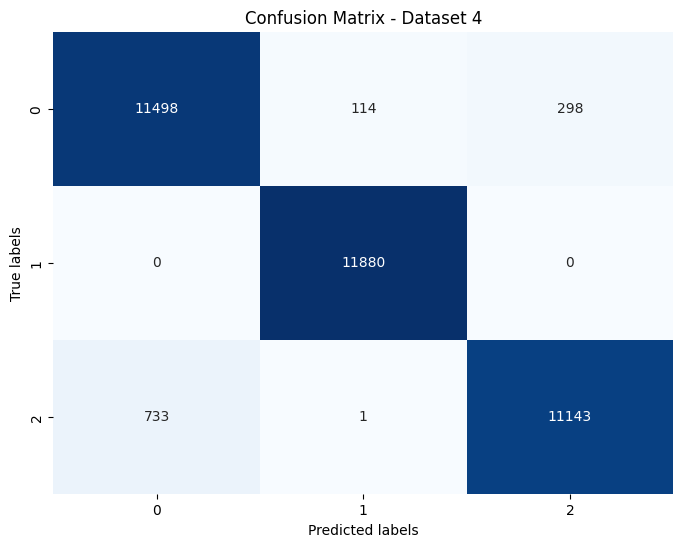

Dataset 4 - Best Parameters: {'pca__n_components': 5, 'svm__C': 100, 'svm__gamma': 'auto'}
Dataset 4 - Training Accuracy: 96.88%
Dataset 4 - Testing Accuracy: 96.79%
Dataset 4 - Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95     11910
           1       0.99      1.00      1.00     11880
           2       0.97      0.94      0.96     11877

    accuracy                           0.97     35667
   macro avg       0.97      0.97      0.97     35667
weighted avg       0.97      0.97      0.97     35667

dataset_1 - Best Parameters: {'pca__n_components': 5, 'svm__C': 100, 'svm__gamma': 'scale'}
dataset_1 - Train Accuracy: 0.9723137590138845
dataset_1 - Test Accuracy: 0.90945
dataset_1 - Cohen's Kappa Score: 0.8365868499001806
dataset_1 - Confusion Matrix: 
[[11659   124   106]
 [    0  4319     0]
 [  652   929  2211]]

dataset_2 - Best Parameters: {'pca__n_components': 5, 'svm__C': 100, 'svm__gamma': 'auto'}
data

In [ ]:
t0 = time.time()

datasets = [
    (X_tr_80, y_tr_80, X_te_80, y_te_80),
    (X_tr_90, y_tr_90, X_te_90, y_te_90),
    (X_tr_95, y_tr_95, X_te_95, y_te_95),
    (X_tr_smote, y_tr_smote, X_te_smote, y_te_smote)
]

min_features = min([X_train.shape[1] for X_train, _, _, _ in datasets])

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('svm', SVC())
])

param_grid = {
    'pca__n_components': [n for n in [5, 7] if n <= min_features],
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto']
}

cv = KFold(n_splits=2, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2, error_score='raise')

results = {}

for i, (X_train, y_train, X_test, y_test) in enumerate(datasets):
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - Dataset {i+1}')
    plt.show()

    training_accuracy = best_model.score(X_train, y_train)
    testing_accuracy = best_model.score(X_test, y_test)

    print(f"Dataset {i+1} - Best Parameters: {grid_search.best_params_}")
    print(f"Dataset {i+1} - Training Accuracy: {training_accuracy * 100:.2f}%")
    print(f"Dataset {i+1} - Testing Accuracy: {testing_accuracy * 100:.2f}%")
    print(f"Dataset {i+1} - Classification Report:\n", classification_report(y_test, y_pred))

    kappa_score = cohen_kappa_score(y_test, y_pred)

    results[f'dataset_{i+1}'] = {
        'best_params': grid_search.best_params_,
        'train_accuracy': training_accuracy,
        'test_accuracy': testing_accuracy,
        'kappa_score': kappa_score,
        'confusion_matrix': conf_matrix
    }

for dataset, result in results.items():
    print(f"{dataset} - Best Parameters: {result['best_params']}")
    print(f"{dataset} - Train Accuracy: {result['train_accuracy']}")
    print(f"{dataset} - Test Accuracy: {result['test_accuracy']}")
    print(f"{dataset} - Cohen's Kappa Score: {result['kappa_score']}")
    print(f"{dataset} - Confusion Matrix: \n{result['confusion_matrix']}")
    print()

t1 = time.time()
print("elapsed time:", (t1 - t0) / 60, "minutes")


As we can see the test accuracy has been improved, and the cross validation was done with 2 folds. I believe that the accuracy would improve even more if we did a 5-fold cross validation, but becasue it takes so much time to execute it didnt make much sense. This is one of the biggest disadvantages of SVM.

Now here we see that there is a significant improvment in classifying between GALAXY and STARS. Also the classification between QUASARS and GALAXY has also significanly improved.

### Optimization using Stochastic Gradient Descent(by minimizing the hinge loss function)

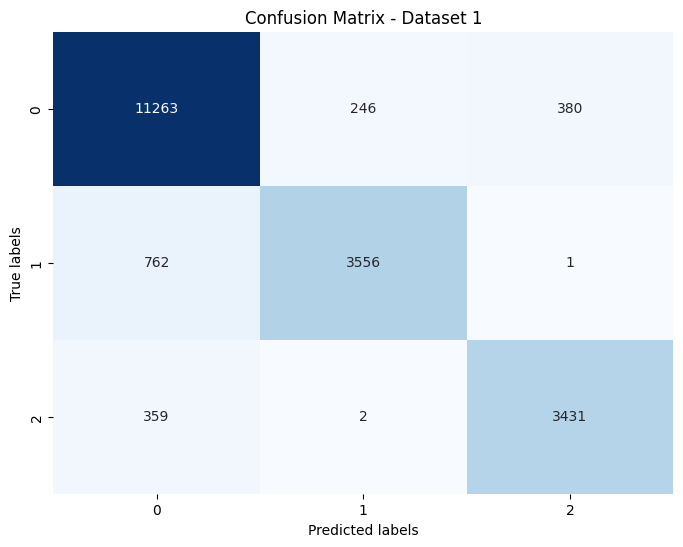

Dataset 1 - Training Accuracy: 90.30%
Dataset 1 - Testing Accuracy: 91.25%
Dataset 1 - Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93     11889
           1       0.93      0.82      0.88      4319
           2       0.90      0.90      0.90      3792

    accuracy                           0.91     20000
   macro avg       0.91      0.89      0.90     20000
weighted avg       0.91      0.91      0.91     20000



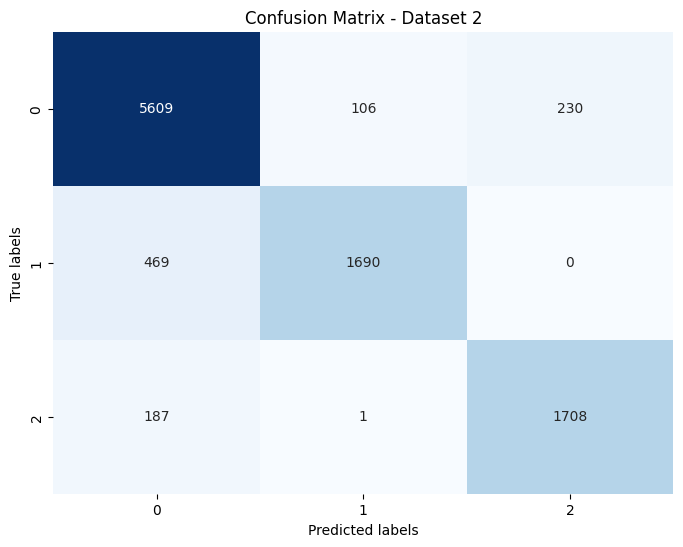

Dataset 2 - Training Accuracy: 90.26%
Dataset 2 - Testing Accuracy: 90.07%
Dataset 2 - Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      5945
           1       0.94      0.78      0.85      2159
           2       0.88      0.90      0.89      1896

    accuracy                           0.90     10000
   macro avg       0.91      0.88      0.89     10000
weighted avg       0.90      0.90      0.90     10000



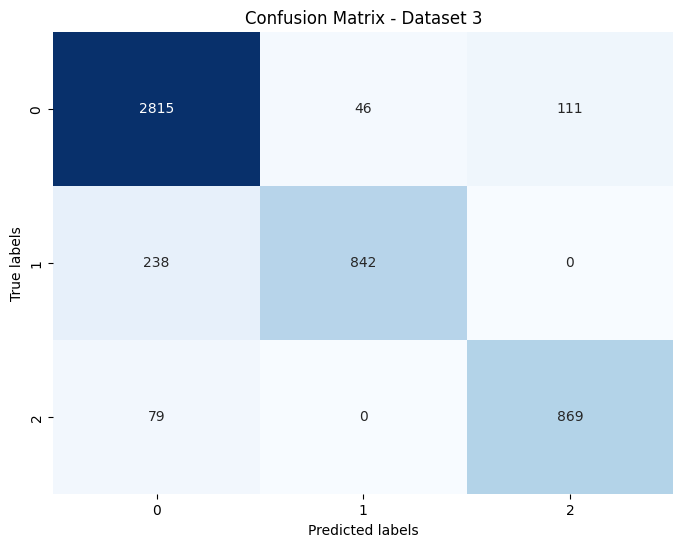

Dataset 3 - Training Accuracy: 89.91%
Dataset 3 - Testing Accuracy: 90.52%
Dataset 3 - Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92      2972
           1       0.95      0.78      0.86      1080
           2       0.89      0.92      0.90       948

    accuracy                           0.91      5000
   macro avg       0.91      0.88      0.89      5000
weighted avg       0.91      0.91      0.90      5000



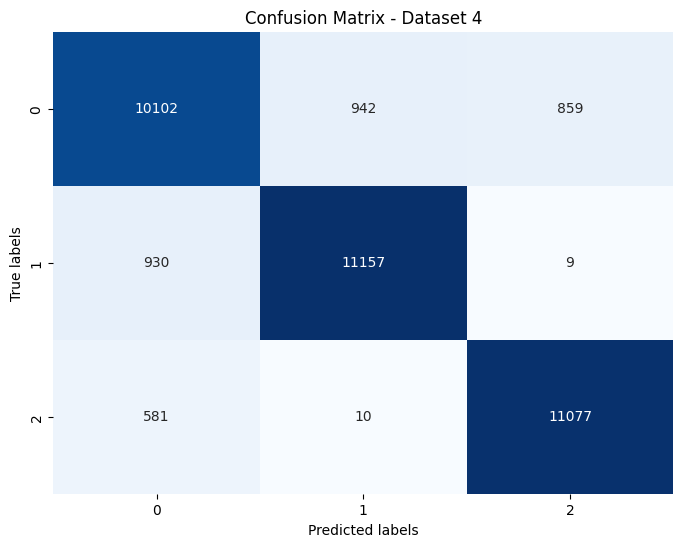

Dataset 4 - Training Accuracy: 90.42%
Dataset 4 - Testing Accuracy: 90.66%
Dataset 4 - Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86     11903
           1       0.92      0.92      0.92     12096
           2       0.93      0.95      0.94     11668

    accuracy                           0.91     35667
   macro avg       0.91      0.91      0.91     35667
weighted avg       0.91      0.91      0.91     35667

dataset_1 - Train Accuracy: 0.9030140009655838
dataset_1 - Test Accuracy: 0.9125
dataset_1 - Cohen's Kappa Score: 0.8422585290407727
dataset_1 - Confusion Matrix: 
[[11263   246   380]
 [  762  3556     1]
 [  359     2  3431]]

dataset_2 - Train Accuracy: 0.9026
dataset_2 - Test Accuracy: 0.9007
dataset_2 - Cohen's Kappa Score: 0.8201100122383163
dataset_2 - Confusion Matrix: 
[[5609  106  230]
 [ 469 1690    0]
 [ 187    1 1708]]

dataset_3 - Train Accuracy: 0.8990526315789473
dataset_3 - Test Accurac

In [ ]:
t0 = time.time()

datasets = [
    (X_tr_80, y_tr_80, X_te_80, y_te_80),
    (X_tr_90, y_tr_90, X_te_90, y_te_90),
    (X_tr_95, y_tr_95, X_te_95, y_te_95),
    (X_tr_smote, y_tr_smote, X_te_smote, y_te_smote)
]

results = {}

for i, (X_train, y_train, X_test, y_test) in enumerate(datasets):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SGDClassifier(loss='hinge', alpha=0.0001, learning_rate='optimal', eta0=0.0, random_state=42))
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - Dataset {i+1}')
    plt.show()

    training_accuracy = pipeline.score(X_train, y_train)
    testing_accuracy = pipeline.score(X_test, y_test)

    print(f"Dataset {i+1} - Training Accuracy: {training_accuracy * 100:.2f}%")
    print(f"Dataset {i+1} - Testing Accuracy: {testing_accuracy * 100:.2f}%")
    print(f"Dataset {i+1} - Classification Report:\n", classification_report(y_test, y_pred))

    kappa_score = cohen_kappa_score(y_test, y_pred)

    results[f'dataset_{i+1}'] = {
        'train_accuracy': training_accuracy,
        'test_accuracy': testing_accuracy,
        'kappa_score': kappa_score,
        'confusion_matrix': conf_matrix
    }

for dataset, result in results.items():
    print(f"{dataset} - Train Accuracy: {result['train_accuracy']}")
    print(f"{dataset} - Test Accuracy: {result['test_accuracy']}")
    print(f"{dataset} - Cohen's Kappa Score: {result['kappa_score']}")
    print(f"{dataset} - Confusion Matrix: \n{result['confusion_matrix']}")
    print()
t1 = time.time()
print("elapsed time:", (t1-t0) / 60, "minutes")


dataset_1 had the best performence, with 0.9125. The overall accuracy of this is lower compared to the others. I think this is because to decrease the execution time, the model makes approximations for each of the next step resulting in a lower accuracy.

### Optimization using Kernel selection (Linear)

To prove the data is linearly seperatable, we use the linear kernel selection and we see there is an improvment in the model accuracy. Other reason why this implementation is useful:

- High-Dimensional Data: In our case we are working with higher dimentional data so, a linear kernel often performs well even if the data isn't perfectly linearly separable.

- Interpretability: Models with linear kernels are easier to interpret compared to non-linear kernels. This results in a lower execution time.

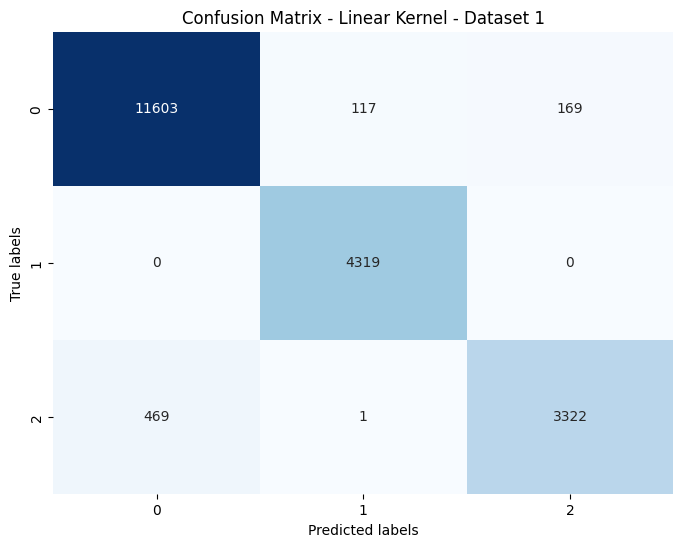

Dataset 1 - Training Accuracy: 95.87%
Dataset 1 - Testing Accuracy: 96.22%
Dataset 1 - Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     11889
           1       0.97      1.00      0.99      4319
           2       0.95      0.88      0.91      3792

    accuracy                           0.96     20000
   macro avg       0.96      0.95      0.96     20000
weighted avg       0.96      0.96      0.96     20000



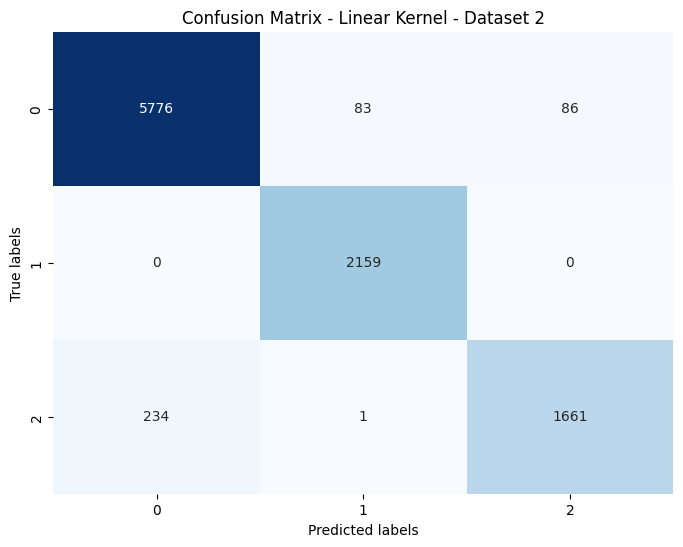

Dataset 2 - Training Accuracy: 95.95%
Dataset 2 - Testing Accuracy: 95.96%
Dataset 2 - Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      5945
           1       0.96      1.00      0.98      2159
           2       0.95      0.88      0.91      1896

    accuracy                           0.96     10000
   macro avg       0.96      0.95      0.95     10000
weighted avg       0.96      0.96      0.96     10000



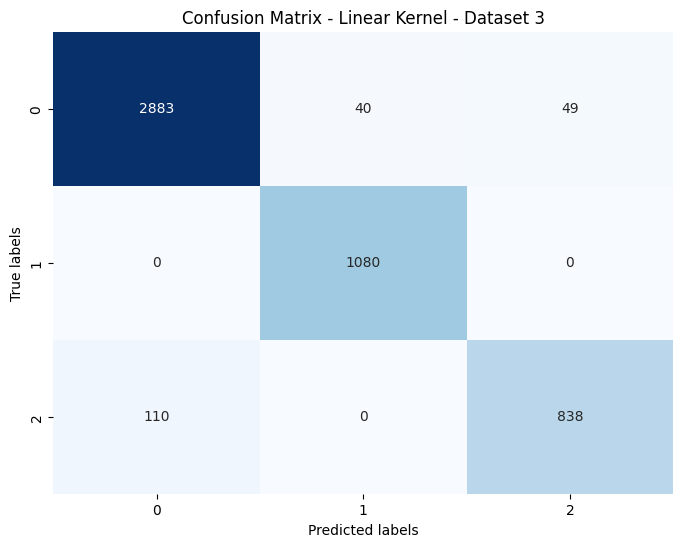

Dataset 3 - Training Accuracy: 95.96%
Dataset 3 - Testing Accuracy: 96.02%
Dataset 3 - Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      2972
           1       0.96      1.00      0.98      1080
           2       0.94      0.88      0.91       948

    accuracy                           0.96      5000
   macro avg       0.96      0.95      0.95      5000
weighted avg       0.96      0.96      0.96      5000



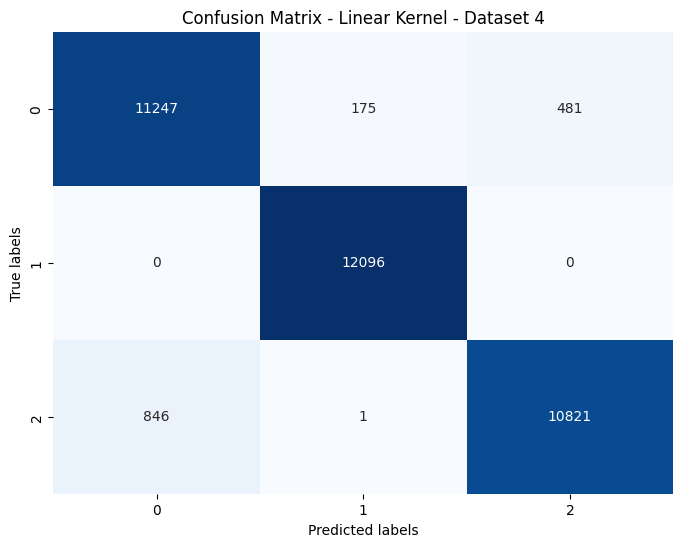

Dataset 4 - Training Accuracy: 95.51%
Dataset 4 - Testing Accuracy: 95.79%
Dataset 4 - Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94     11903
           1       0.99      1.00      0.99     12096
           2       0.96      0.93      0.94     11668

    accuracy                           0.96     35667
   macro avg       0.96      0.96      0.96     35667
weighted avg       0.96      0.96      0.96     35667

dataset_1 - Train Accuracy: 0.9586868059866198
dataset_1 - Test Accuracy: 0.9622
dataset_1 - Cohen's Kappa Score: 0.9325225076597999
dataset_1 - Confusion Matrix: 
[[11603   117   169]
 [    0  4319     0]
 [  469     1  3322]]
dataset_1 - Test F1 Score: 0.9617236789911083

dataset_2 - Train Accuracy: 0.9594888888888888
dataset_2 - Test Accuracy: 0.9596
dataset_2 - Cohen's Kappa Score: 0.9280057608221999
dataset_2 - Confusion Matrix: 
[[5776   83   86]
 [   0 2159    0]
 [ 234    1 1661]]
dataset_2 - Te

In [ ]:
t0 = time.time()

datasets = [
    (X_tr_80, y_tr_80, X_te_80, y_te_80),
    (X_tr_90, y_tr_90, X_te_90, y_te_90),
    (X_tr_95, y_tr_95, X_te_95, y_te_95),
    (X_tr_smote, y_tr_smote, X_te_smote, y_te_smote)
]

results = {}
f1_scores_test = []

for i, (X_train, y_train, X_test, y_test) in enumerate(datasets):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    svm_model = SVC(kernel='linear', C=1.0)
    svm_model.fit(X_train_scaled, y_train)

    y_pred = svm_model.predict(X_test_scaled)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - Linear Kernel - Dataset {i+1}')
    plt.show()

    training_accuracy = svm_model.score(X_train_scaled, y_train)
    testing_accuracy = svm_model.score(X_test_scaled, y_test)
    f1_score_test = f1_score(y_test, y_pred, average='weighted')

    print(f"Dataset {i+1} - Training Accuracy: {training_accuracy * 100:.2f}%")
    print(f"Dataset {i+1} - Testing Accuracy: {testing_accuracy * 100:.2f}%")
    print(f"Dataset {i+1} - Classification Report:\n", classification_report(y_test, y_pred))

    kappa_score = cohen_kappa_score(y_test, y_pred)

    results[f'dataset_{i+1}'] = {
        'train_accuracy': training_accuracy,
        'test_accuracy': testing_accuracy,
        'kappa_score': kappa_score,
        'confusion_matrix': cm,
        'f1_score_test': f1_score_test
    }

    f1_scores_test.append(f1_score_test)

for dataset, result in results.items():
    print(f"{dataset} - Train Accuracy: {result['train_accuracy']}")
    print(f"{dataset} - Test Accuracy: {result['test_accuracy']}")
    print(f"{dataset} - Cohen's Kappa Score: {result['kappa_score']}")
    print(f"{dataset} - Confusion Matrix: \n{result['confusion_matrix']}")
    print(f"{dataset} - Test F1 Score: {result['f1_score_test']}")
    print()

t1 = time.time()
print("elapsed time:", (t1-t0) / 60, "minutes")




The best testset is Dataset 1 with an accuracy of 0.9622

We also tried with a polynomial kernel selection, but it performed very poorly about 56% test accuracy. This means that the data is linearly separable. And the hyperplane that seperates the data  plot visually looks like this:


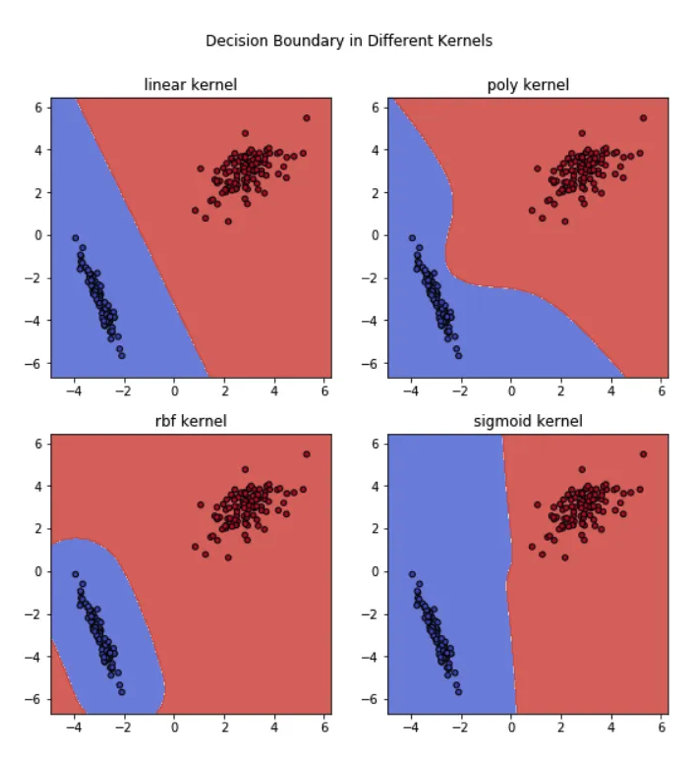

A quick visual on the best f1 score:

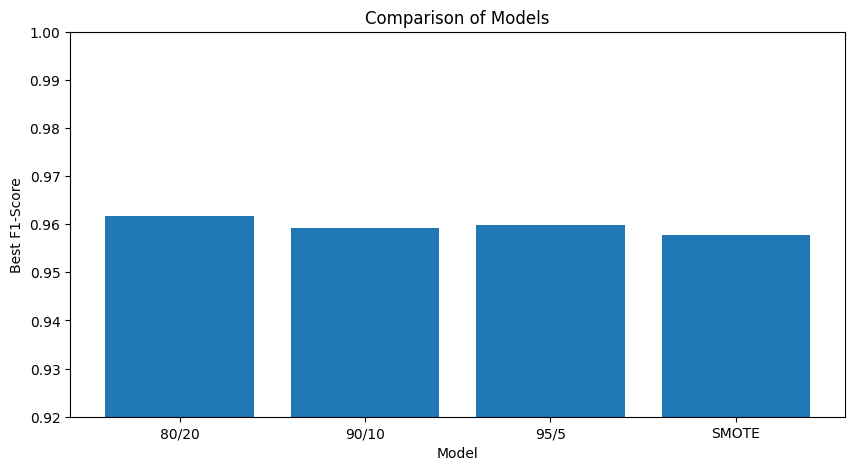

In [ ]:
model_names = ['80/20', '90/10', '95/5', 'SMOTE']
plt.figure(figsize=(10, 5))
plt.bar(range(len(f1_scores_test)), f1_scores_test)
plt.xlabel('Model')
plt.ylabel('Best F1-Score')
plt.ylim(0.92, 1)
plt.title('Comparison of Models')
plt.xticks(range(len(f1_scores_test)), model_names)
plt.show()


We see 80/20 and 95/5 performed slightly better than 90/10 and SMOTE

In SVM you cannot directly measure which feature was the best but rather provides coefficents for each feature which indicate the contribution of each feature to the decision boundary.

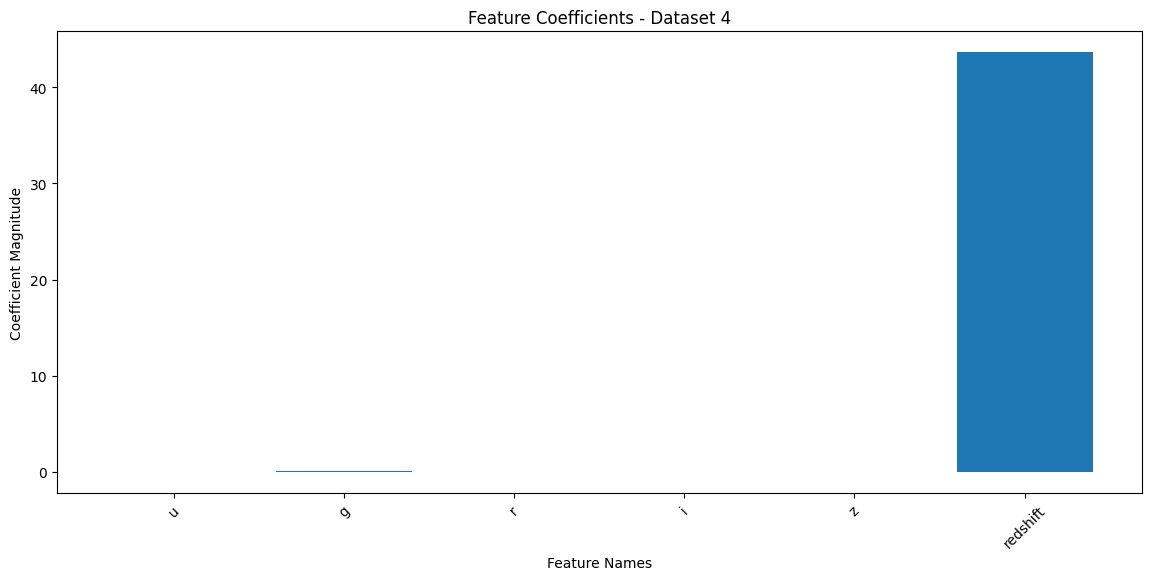

In [ ]:
  plt.figure(figsize=(14, 6))
  plt.bar(range(len(X_train.columns)), svm_model.coef_[0])
  plt.xlabel("Feature Names")
  plt.ylabel("Coefficient Magnitude")
  plt.title(f'Feature Coefficients - Dataset {i+1}')
  plt.xticks(range(len(X_train.columns)), X_train.columns, rotation=45)
  plt.show()


And here we see only the redshift was used to find the optimal decistion boundary.

Overall we see that

##**The (Gaussian) Naive Bayes algorithm**

For the data set we can only use GaussianNB, not MultinomialNB as we have negative values for some samples and in general it is not very good fitted. Thats why also Complement NB is out of the race as it is a specified Multinomial NB. We also don´t have Categorical features and binary-valued ones. That´s why Categorical NB and Bernoulli NB is also out of the race.There is only Gaussian NB left.
Gaussian NB doesn´t have typical hyperparameters to tune such as other algorithms. That is because it just assumes that the features are independet and Gaussian distributed, there is no need for any hyperparameter. However, we can add "var_smoothing". This parameter artificially adds a user-defined value to the variances for stability and to account for features not seen during training. It is typically a very small value.

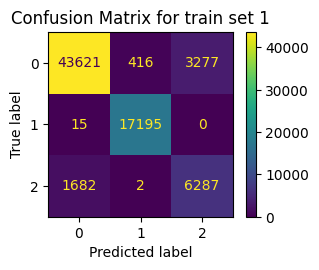

Best parameters for split 1: {'gnb__var_smoothing': 1e-05}
Train set f1-score for split 1: 92.5595%
Test set f1-score for split 1: 93.365%

--------


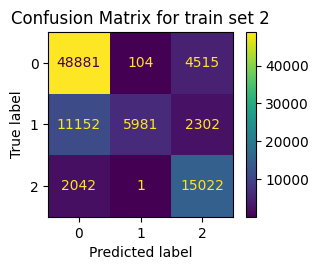

Best parameters for split 2: {'gnb__var_smoothing': 0}
Train set f1-score for split 2: 74.3978%
Test set f1-score for split 2: 74.06%

--------


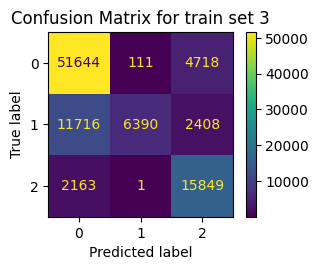

Best parameters for split 3: {'gnb__var_smoothing': 0}
Train set f1-score for split 3: 74.5084%
Test set f1-score for split 3: 74.32%

--------


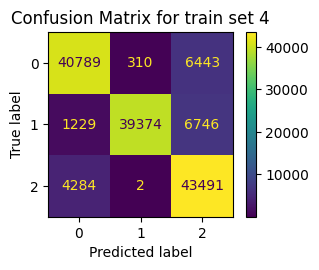

Best parameters for split 4: {'gnb__var_smoothing': 0}
Train set f1-score for split 4: 86.3263%
Test set f1-score for split 4: 86.2113%

--------
Elapsed time: 8.214630126953125 seconds


In [ ]:
t0 = time.time()

param_grids = [
    # 80/20 split
    {'gnb__var_smoothing': [1e-6, 5e-6, 1e-5,5e-5, 1e-4]},  # very small,choose intervals with plot of next cell
    # 90/10 split
    {'gnb__var_smoothing': [0, 1e-25, 1e-20,1e-15, 1e-10]},
    # 95/5 split
    {'gnb__var_smoothing': [0, 1e-25, 1e-20,1e-15, 1e-10]},
    # SMOTE split
    {'gnb__var_smoothing': [0, 1e-20, 1e-15,1e-12, 1e-11]}
    ]
trainsets = [
    (X_tr_80, y_tr_80),
    (X_tr_90, y_tr_90),
    (X_tr_95, y_tr_95),
    (X_tr_smote, y_tr_smote)]

testsets = [
    (X_te_80, y_te_80),
    (X_te_90, y_te_90),
    (X_te_95, y_te_95),
    (X_te_smote, y_te_smote)]

mean_test_scores = []
pipe = Pipeline([('scaler', StandardScaler()), ('gnb', GaussianNB())])

for i, param_grid in enumerate(param_grids):
    if i < len(trainsets):
        grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_weighted')
        grid_search.fit(trainsets[i][0], trainsets[i][1])
        mean_test_scores.append(grid_search.cv_results_['mean_test_score'])
        pipe.set_params(**grid_search.best_params_)
        pipe.fit(trainsets[i][0], trainsets[i][1])
        predictions = cross_val_predict(pipe,trainsets[i][0], trainsets[i][1], cv=5)
        cm = confusion_matrix(trainsets[i][1], predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=plt.subplot(2, 2, i + 1))
        plt.title(f"Confusion Matrix for train set {i+1}")
        plt.tight_layout()
        plt.show()
        print(f"Best parameters for split {i+1}: {grid_search.best_params_}")
        pipe.predict(trainsets[i][0])
        print(f"Train set f1-score for split {i+1}: {round(pipe.score(trainsets[i][0], trainsets[i][1]) * 100, 4)}%")
        pipe.predict(testsets[i][0])
        print(f"Test set f1-score for split {i+1}: {round(pipe.score(testsets[i][0], testsets[i][1]) * 100, 4)}%\n")
        print("--------")

t1 = time.time()
print("Elapsed time:", t1-t0, "seconds")

As we can see, Naive Bayes did not perform well on any but the first test set. Also the confusion matrices are not particullary good, we can see that GNB did misclassify a lot of samples of stars as quasars, which makes very few sense from a physicall point of view. This also matches its description in the scikit-learn description about Naive Bayes, where it is being statet that Naive Bayes is not known as a good estimator. This might also explain this weird behavior with the different splits. However, the math behind it is nice.

Still it is quite weird that the 80/20 train split performs that well. We will implement a naive small code that prints the score once for 80/20 and once for 90/10 to check whether we had a mistake in our previous code.

In [ ]:
pipe = Pipeline ([('scaler', StandardScaler()), ('gnb', GaussianNB(var_smoothing =1e-05))])
pipe.fit(X_tr_80, y_tr_80)
pipe.predict(X_te_80)
print(pipe.score(X_te_80, y_te_80))

pipe_90 = Pipeline ([('scaler', StandardScaler()), ('gnb', GaussianNB(var_smoothing =0))])
pipe_90.fit(X_tr_90, y_tr_90)
pipe_90.predict(X_te_90)
print(pipe_90.score(X_te_90, y_te_90))

0.93365
0.7406


Apparently it is just as it is, the 80/20 split performs apparently better than the others. This is quite weird, but may also be a coincidence. As the Naive Bayes won´t be the best classifier anyways, this should not be too much of a problem.

We should also visualize how we have choosen the param_grid intervals:

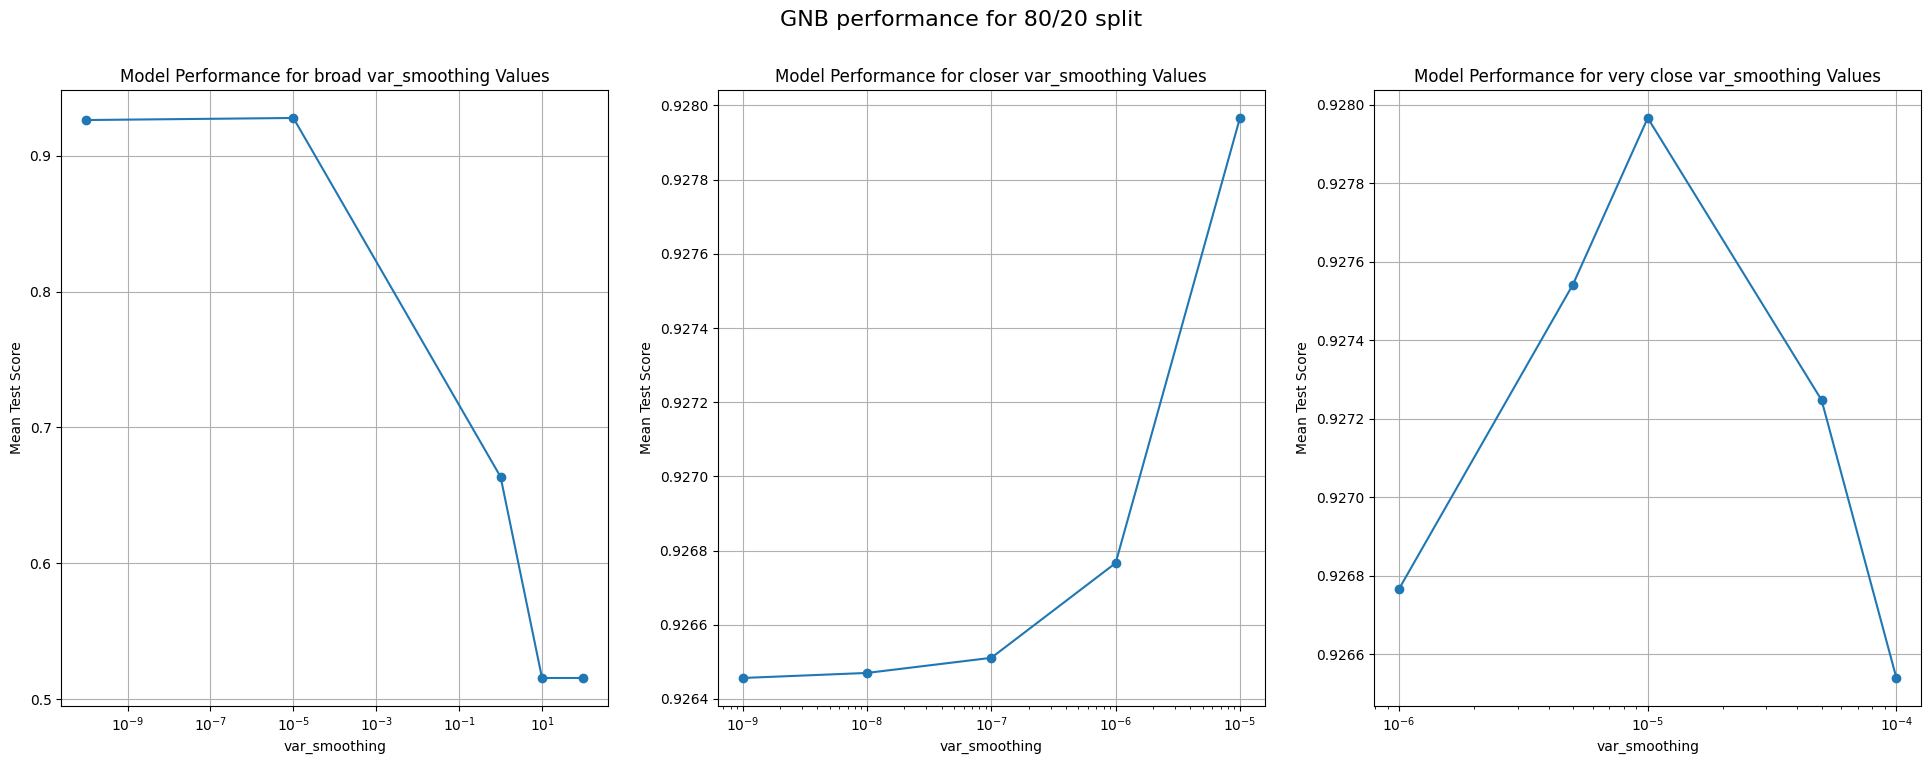

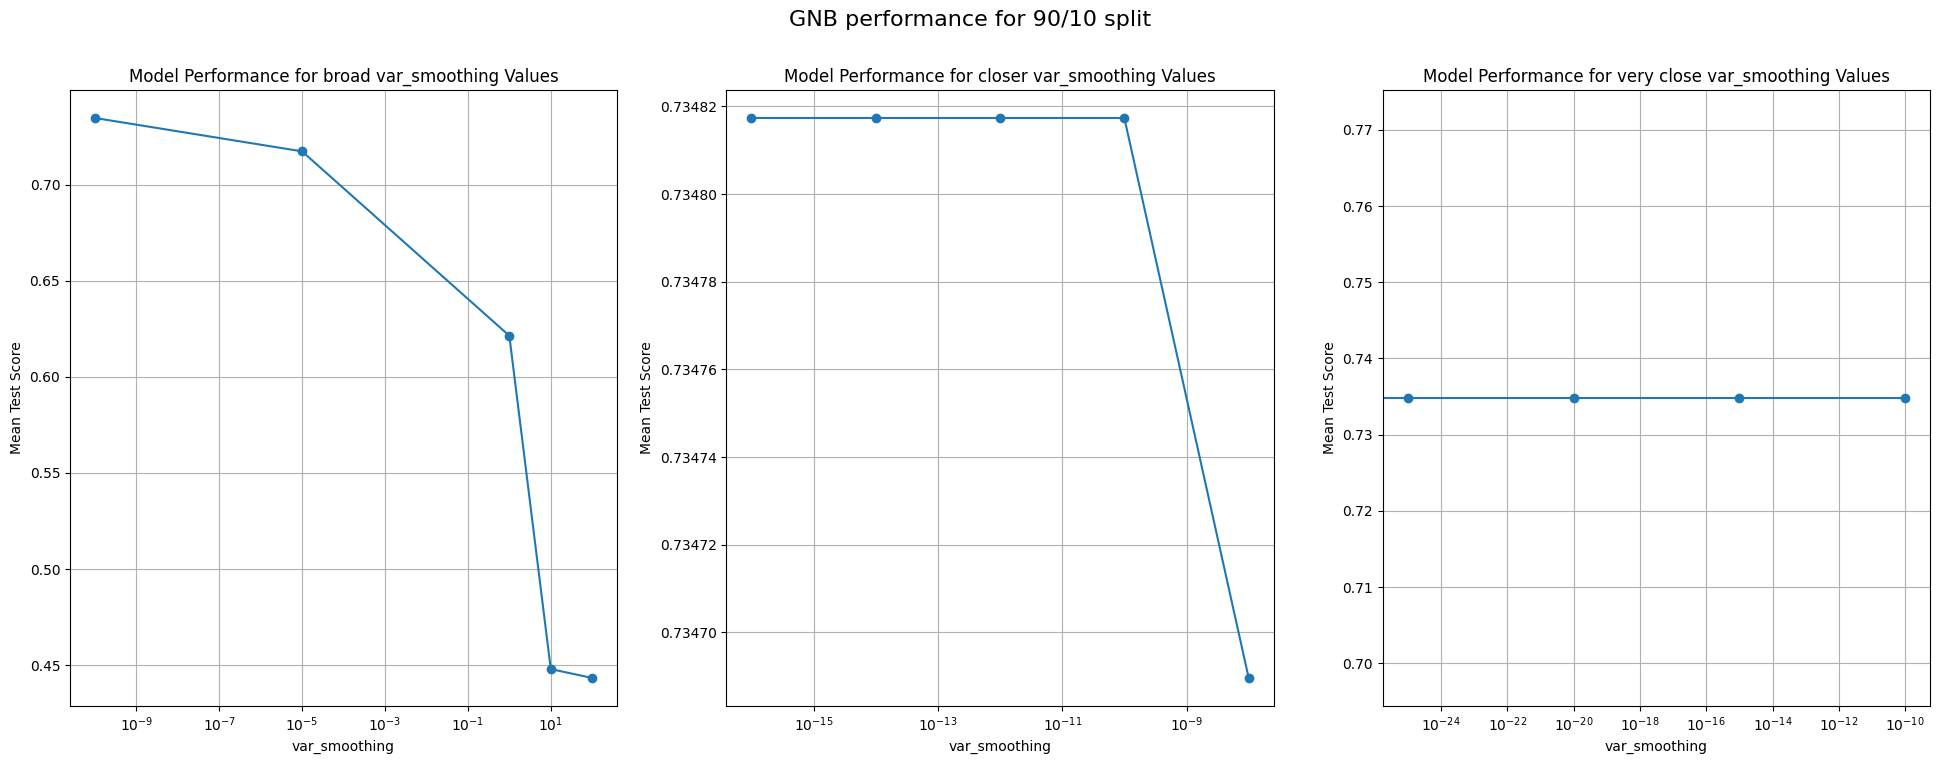

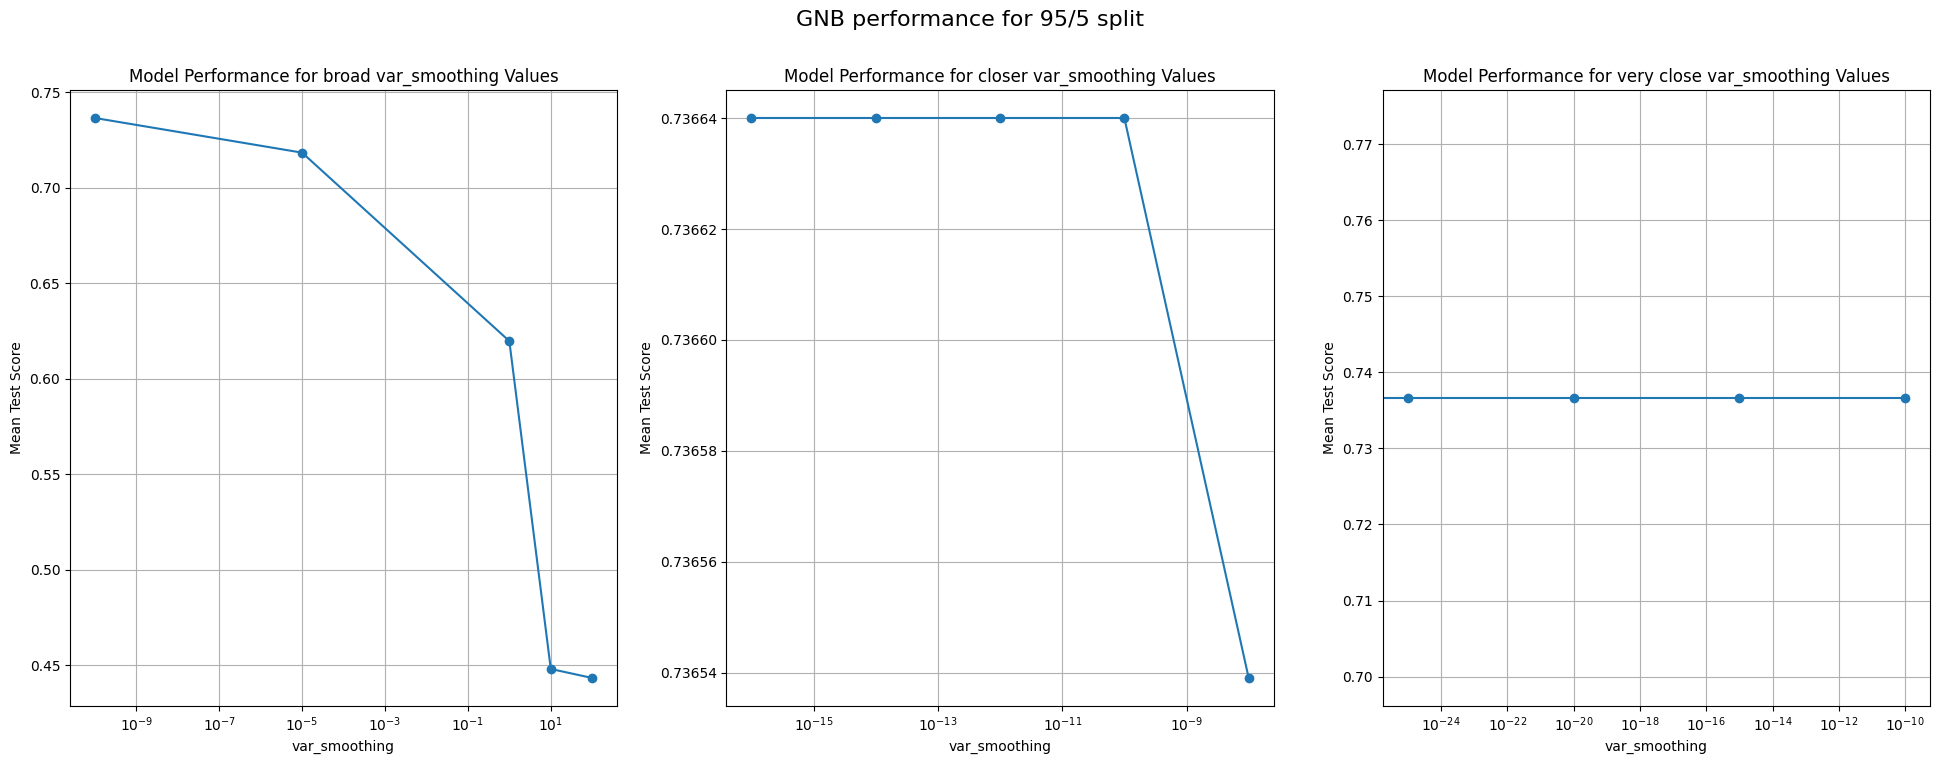

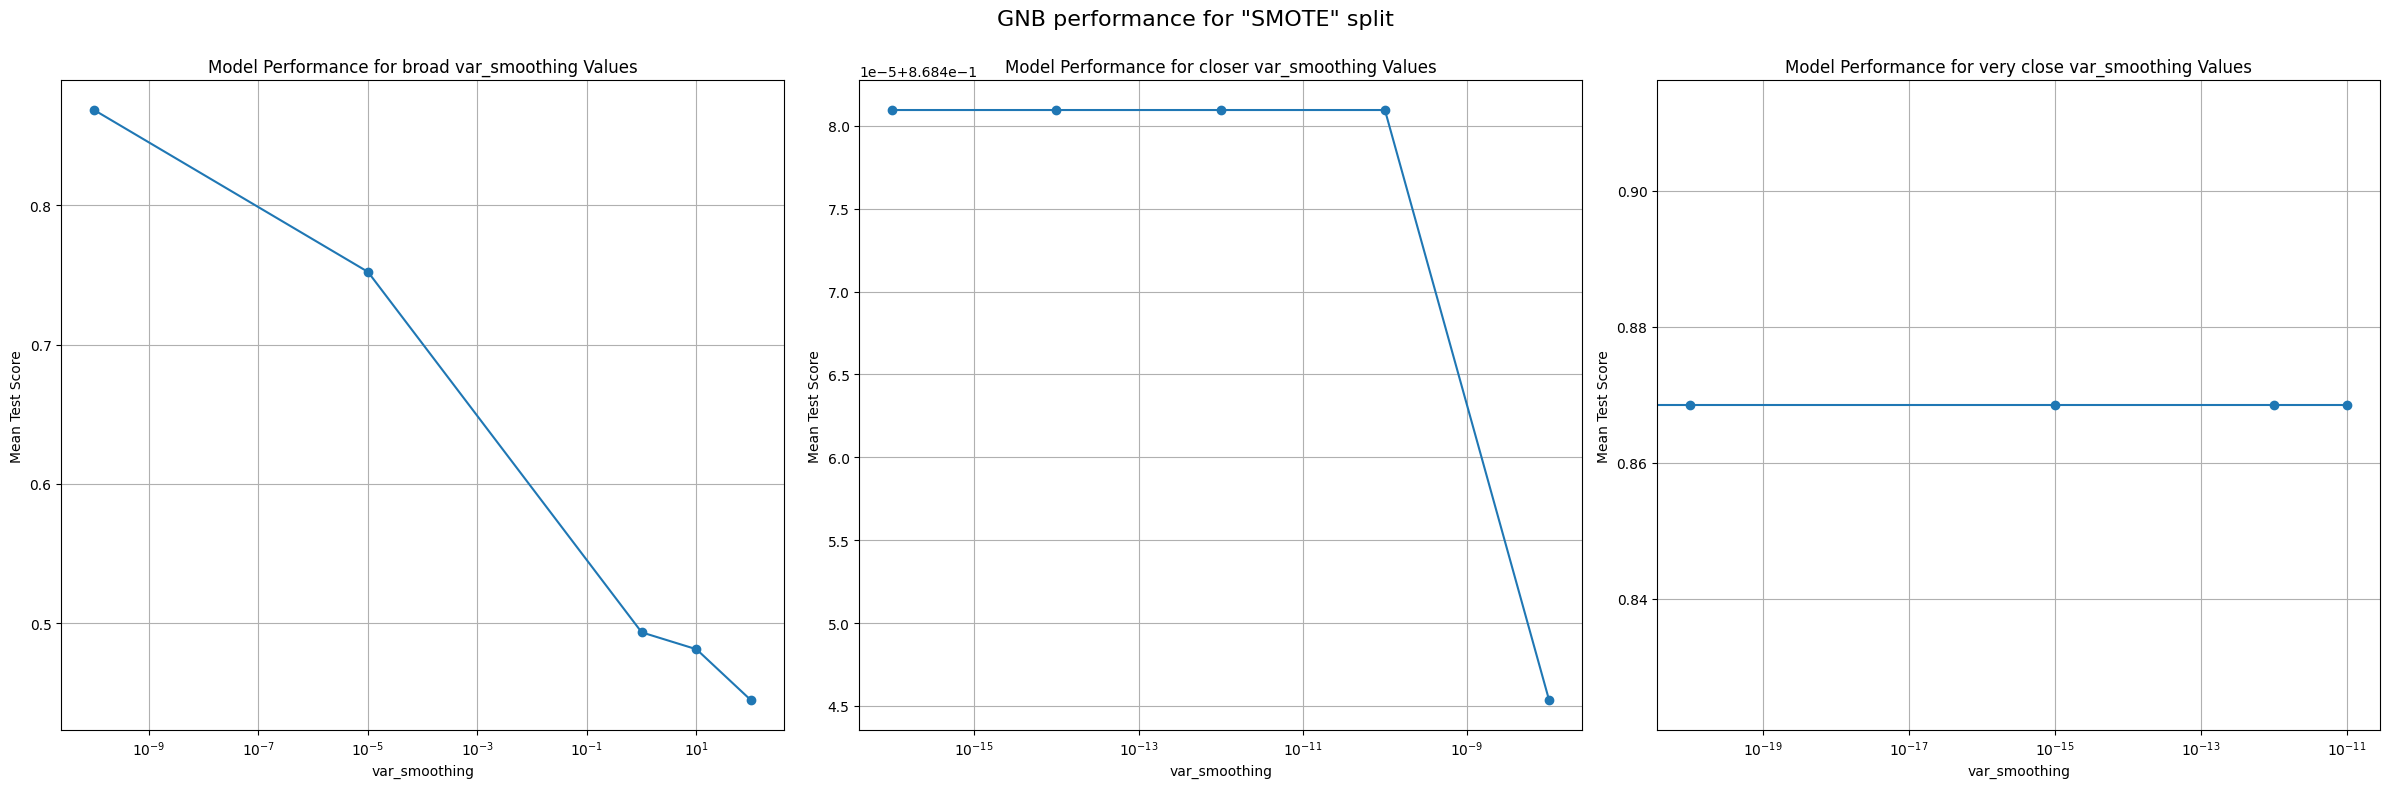

In [ ]:
#@title **Naive, but it works**
pipe = Pipeline([('scaler', StandardScaler()), ('gnb', GaussianNB())])
###
param_grid_80_1 = {'gnb__var_smoothing': [1e-10, 1e-5, 1, 10, 100]} #wide
param_grid_80_2= {'gnb__var_smoothing': [1e-9, 1e-8, 1e-7,1e-6, 1e-5]} #small
param_grid_80_3 ={'gnb__var_smoothing': [1e-6, 5e-6, 1e-5,5e-5, 1e-4]}  #very small

param_grid_90_1 = {'gnb__var_smoothing': [1e-10, 1e-5, 1, 10, 100]}
param_grid_90_2= {'gnb__var_smoothing': [1e-16, 1e-14, 1e-12,1e-10, 1e-8]}
param_grid_90_3 ={'gnb__var_smoothing': [0, 1e-25, 1e-20,1e-15, 1e-10]}

param_grid_95_1 = {'gnb__var_smoothing': [1e-10, 1e-5, 1, 10, 100]}
param_grid_95_2= {'gnb__var_smoothing': [1e-16, 1e-14, 1e-12,1e-10, 1e-8]}
param_grid_95_3 ={'gnb__var_smoothing': [0, 1e-25, 1e-20,1e-15, 1e-10]}

param_grid_SMOTE_1 = {'gnb__var_smoothing': [1e-10, 1e-5, 1, 10, 100]}
param_grid_SMOTE_2= {'gnb__var_smoothing': [1e-16, 1e-14, 1e-12,1e-10, 1e-8]}
param_grid_SMOTE_3 ={'gnb__var_smoothing': [0, 1e-20, 1e-15,1e-12, 1e-11]}
####
grid_search_80_1 = GridSearchCV(pipe, param_grid_80_1, cv=5,scoring='f1_weighted')
grid_search_80_2 = GridSearchCV(pipe, param_grid_80_2, cv=5,scoring='f1_weighted')
grid_search_80_3 = GridSearchCV(pipe, param_grid_80_3, cv=5,scoring='f1_weighted')

grid_search_90_1 = GridSearchCV(pipe, param_grid_90_1, cv=5,scoring='f1_weighted')
grid_search_90_2 = GridSearchCV(pipe, param_grid_90_2, cv=5,scoring='f1_weighted')
grid_search_90_3 = GridSearchCV(pipe, param_grid_90_3, cv=5,scoring='f1_weighted')

grid_search_95_1 = GridSearchCV(pipe, param_grid_95_1, cv=5,scoring='f1_weighted')
grid_search_95_2 = GridSearchCV(pipe, param_grid_95_2, cv=5,scoring='f1_weighted')
grid_search_95_3 = GridSearchCV(pipe, param_grid_95_3, cv=5,scoring='f1_weighted')

grid_search_SMOTE_1 = GridSearchCV(pipe, param_grid_SMOTE_1, cv=5,scoring='f1_weighted')
grid_search_SMOTE_2 = GridSearchCV(pipe, param_grid_SMOTE_2, cv=5,scoring='f1_weighted')
grid_search_SMOTE_3 = GridSearchCV(pipe, param_grid_SMOTE_3, cv=5,scoring='f1_weighted')
#####
grid_search_80_1.fit(X_tr_80, y_tr_80)
grid_search_80_2.fit(X_tr_80, y_tr_80)
grid_search_80_3.fit(X_tr_80, y_tr_80)

grid_search_90_1.fit(X_tr_90, y_tr_90)
grid_search_90_2.fit(X_tr_90, y_tr_90)
grid_search_90_3.fit(X_tr_90, y_tr_90)

grid_search_95_1.fit(X_tr_95, y_tr_95)
grid_search_95_2.fit(X_tr_95, y_tr_95)
grid_search_95_3.fit(X_tr_95, y_tr_95)

grid_search_SMOTE_1.fit(X_tr_smote, y_tr_smote)
grid_search_SMOTE_2.fit(X_tr_smote, y_tr_smote)
grid_search_SMOTE_3.fit(X_tr_smote, y_tr_smote)

mean_test_scores_80_1 = grid_search_80_1.cv_results_['mean_test_score']
mean_test_scores_80_2 = grid_search_80_2.cv_results_['mean_test_score']
mean_test_scores_80_3 = grid_search_80_3.cv_results_['mean_test_score']

mean_test_scores_90_1 = grid_search_90_1.cv_results_['mean_test_score']
mean_test_scores_90_2 = grid_search_90_2.cv_results_['mean_test_score']
mean_test_scores_90_3 = grid_search_90_3.cv_results_['mean_test_score']

mean_test_scores_95_1 = grid_search_95_1.cv_results_['mean_test_score']
mean_test_scores_95_2 = grid_search_95_2.cv_results_['mean_test_score']
mean_test_scores_95_3 = grid_search_95_3.cv_results_['mean_test_score']

mean_test_scores_SMOTE_1 = grid_search_SMOTE_1.cv_results_['mean_test_score']
mean_test_scores_SMOTE_2 = grid_search_SMOTE_2.cv_results_['mean_test_score']
mean_test_scores_SMOTE_3 = grid_search_SMOTE_3.cv_results_['mean_test_score']

fig, axs = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('GNB performance for 80/20 split', fontsize=16)
axs[0].plot(param_grid_80_1['gnb__var_smoothing'], mean_test_scores_80_1, marker='o')
axs[0].set_xscale('log')
axs[0].set_title('Model Performance for broad var_smoothing Values')
axs[0].set_xlabel('var_smoothing')
axs[0].set_ylabel('Mean Test Score')
axs[0].grid(True)
axs[1].plot(param_grid_80_2['gnb__var_smoothing'], mean_test_scores_80_2, marker='o')
axs[1].set_xscale('log')
axs[1].set_title('Model Performance for closer var_smoothing Values')
axs[1].set_xlabel('var_smoothing')
axs[1].set_ylabel('Mean Test Score')
axs[1].grid(True)
axs[2].plot(param_grid_80_3['gnb__var_smoothing'], mean_test_scores_80_3, marker='o')
axs[2].set_xscale('log')
axs[2].set_title('Model Performance for very close var_smoothing Values')
axs[2].set_xlabel('var_smoothing')
axs[2].set_ylabel('Mean Test Score')
axs[2].grid(True)

fig, axs = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('GNB performance for 90/10 split', fontsize=16)
axs[0].plot(param_grid_90_1['gnb__var_smoothing'], mean_test_scores_90_1, marker='o')
axs[0].set_xscale('log')
axs[0].set_title('Model Performance for broad var_smoothing Values')
axs[0].set_xlabel('var_smoothing')
axs[0].set_ylabel('Mean Test Score')
axs[0].grid(True)
axs[1].plot(param_grid_90_2['gnb__var_smoothing'], mean_test_scores_90_2, marker='o')
axs[1].set_xscale('log')
axs[1].set_title('Model Performance for closer var_smoothing Values')
axs[1].set_xlabel('var_smoothing')
axs[1].set_ylabel('Mean Test Score')
axs[1].grid(True)
axs[2].plot(param_grid_90_3['gnb__var_smoothing'], mean_test_scores_90_3, marker='o')
axs[2].set_xscale('log')
axs[2].set_title('Model Performance for very close var_smoothing Values')
axs[2].set_xlabel('var_smoothing')
axs[2].set_ylabel('Mean Test Score')
axs[2].grid(True)

fig, axs = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('GNB performance for 95/5 split', fontsize=16)
axs[0].plot(param_grid_95_1['gnb__var_smoothing'], mean_test_scores_95_1, marker='o')
axs[0].set_xscale('log')
axs[0].set_title('Model Performance for broad var_smoothing Values')
axs[0].set_xlabel('var_smoothing')
axs[0].set_ylabel('Mean Test Score')
axs[0].grid(True)
axs[1].plot(param_grid_95_2['gnb__var_smoothing'], mean_test_scores_95_2, marker='o')
axs[1].set_xscale('log')
axs[1].set_title('Model Performance for closer var_smoothing Values')
axs[1].set_xlabel('var_smoothing')
axs[1].set_ylabel('Mean Test Score')
axs[1].grid(True)
axs[2].plot(param_grid_95_3['gnb__var_smoothing'], mean_test_scores_95_3, marker='o')
axs[2].set_xscale('log')
axs[2].set_title('Model Performance for very close var_smoothing Values')
axs[2].set_xlabel('var_smoothing')
axs[2].set_ylabel('Mean Test Score')
axs[2].grid(True)

fig, axs = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('GNB performance for "SMOTE" split', fontsize=16)
axs[0].plot(param_grid_SMOTE_1['gnb__var_smoothing'], mean_test_scores_SMOTE_1, marker='o')
axs[0].set_xscale('log')
axs[0].set_title('Model Performance for broad var_smoothing Values')
axs[0].set_xlabel('var_smoothing')
axs[0].set_ylabel('Mean Test Score')
axs[0].grid(True)
axs[1].plot(param_grid_SMOTE_2['gnb__var_smoothing'], mean_test_scores_SMOTE_2, marker='o')
axs[1].set_xscale('log')
axs[1].set_title('Model Performance for closer var_smoothing Values')
axs[1].set_xlabel('var_smoothing')
axs[1].set_ylabel('Mean Test Score')
axs[1].grid(True)
axs[2].plot(param_grid_SMOTE_3['gnb__var_smoothing'], mean_test_scores_SMOTE_3, marker='o')
axs[2].set_xscale('log')
axs[2].set_title('Model Performance for very close var_smoothing Values')
axs[2].set_xlabel('var_smoothing')
axs[2].set_ylabel('Mean Test Score')
axs[2].grid(True)
plt.tight_layout()
plt.show()

As we can see, the first split still suggests a very tiny var-smoothing whereas the other train/test-splits perform best -if we can use the term "best"- without var smoothing.

However, we can conclude that GNB is certainly not the best classifier in the repertoire. We should focus on other classifiers.

##**Neural Network - Multi-layer Perception**

Multi-Layer Perceptron (MLP) is a type of artificial neural network used for classification and regression tasks. It consists of multiple layers of neurons, including an input layer, one or more hidden layers, and an output layer. Each neuron in one layer is connected to every neuron in the next layer, and the network learns by adjusting the weights of these connections to minimize the error in its predictions.

Since our data set is quite large and Neural Networks are resource-intensive we had to perform a smaller grid search. Even with that limitation it takes approximately 3 hours to find the best parameters.

In [ ]:
datasets = [
    (X_tr_80, y_tr_80, '80/20 split'),
    (X_tr_90, y_tr_90, '90/10 split'),
    (X_tr_95, y_tr_95, '95/5 split'),
    (X_tr_smote, y_tr_smote, 'SMOTE split')
]

pipeline_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier())
])

param_grid_mlp = {
    'mlp__hidden_layer_sizes': [(100,50), (50,30)],
    'mlp__max_iter': [250, 500],
    'mlp__activation': ['relu'],
    'mlp__solver': ['adam'],
    'mlp__alpha': [0.0001, 0.001],
    'mlp__learning_rate': ['constant'],
}


for X, y, split_name in datasets:
    halving_grid_search3 = HalvingGridSearchCV(pipeline_mlp, param_grid_mlp, cv=5, n_jobs=-1)
    halving_grid_search3.fit(X, y)
    print(f"Best parameters for {split_name}:", halving_grid_search3.best_params_)
    print('Best CV score:' , halving_grid_search3.best_score_)

Best parameters for 80/20 split: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__learning_rate': 'constant', 'mlp__max_iter': 250, 'mlp__solver': 'adam'}
Best CV score: 0.9711932369047658
Best parameters for 90/10 split: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__learning_rate': 'constant', 'mlp__max_iter': 500, 'mlp__solver': 'adam'}
Best CV score: 0.9737666666666666
Best parameters for 95/5 split: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__learning_rate': 'constant', 'mlp__max_iter': 500, 'mlp__solver': 'adam'}
Best CV score: 0.9732617506184535
Best parameters for SMOTE split: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__learning_rate': 'constant', 'mlp__max_iter': 500, 'mlp__solver': 'adam'}
Best CV score: 0.9731334228051132


hidden_layer_sizes: This defines the number of neurons in each hidden layer. For example, (100, 50) indicates two hidden layers, the first with 100 neurons and the second with 50 neurons.

max_iter: The maximum number of iterations for the optimization algorithm. More iterations can lead to better training results but may also increase computation time.

activation: The activation function for the hidden layers. 'relu' (rectified linear unit) is commonly used due to its effectiveness in training deep networks.

solver: The optimization algorithm for weight adjustment. 'adam' (adaptive moment estimation) is a popular choice for its efficiency and good performance on a wide range of problems.

alpha: The regularization parameter, which helps prevent overfitting by penalizing large weights. Common values are 0.0001 and 0.001.

learning_rate: The learning rate schedule for weight updates. 'constant' keeps the learning rate fixed throughout training.

After that we can evaluate our MLPClassifiers on our train-test splits.

Model: mlp_80
Cross Validation Scores: [0.97275486 0.97144434 0.97213409 0.97123543 0.97123543]
Average Cross Validation Score: 0.9717608286778321
Train Accuracy: 0.9735266526873414
Test Accuracy: 0.97455


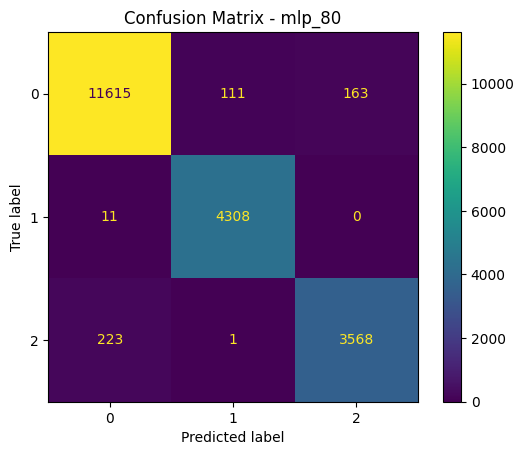

Cohen's Kappa Score: 0.9549336790873416
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11889
           1       0.97      1.00      0.99      4319
           2       0.96      0.94      0.95      3792

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000

----------------------------------------
Model: mlp_90
Cross Validation Scores: [0.97388889 0.97066667 0.97422222 0.97083333 0.97422222]
Average Cross Validation Score: 0.9727666666666666
Train Accuracy: 0.9743888888888889
Test Accuracy: 0.9742


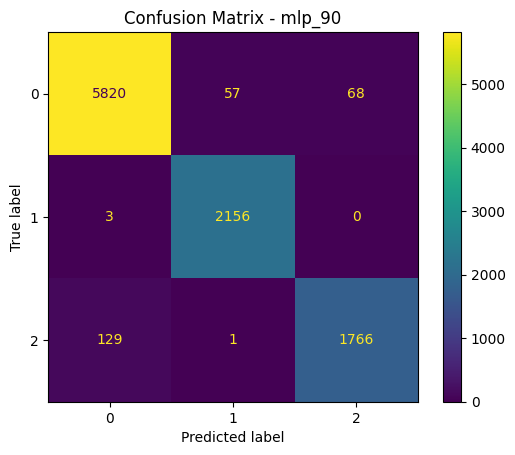

Cohen's Kappa Score: 0.9542212854343664
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5945
           1       0.97      1.00      0.99      2159
           2       0.96      0.93      0.95      1896

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

----------------------------------------
Model: mlp_95
Cross Validation Scores: [0.97110526 0.97189474 0.97584211 0.97394737 0.97284211]
Average Cross Validation Score: 0.9731263157894737
Train Accuracy: 0.9746421052631579
Test Accuracy: 0.9722


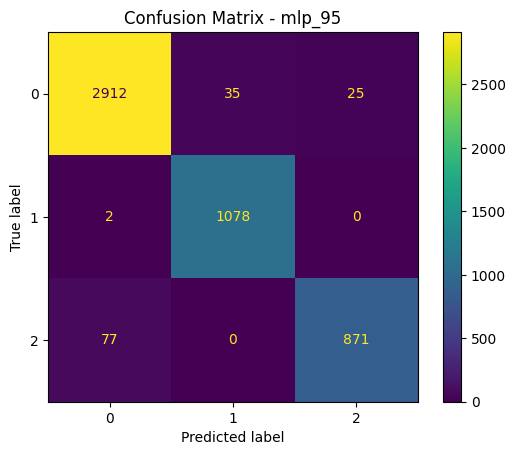

Cohen's Kappa Score: 0.9505665289168024
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2972
           1       0.97      1.00      0.98      1080
           2       0.97      0.92      0.94       948

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000

----------------------------------------
Model: mlp_smote
Cross Validation Scores: [0.97227869 0.97126235 0.97133245 0.97466092 0.97101602]
Average Cross Validation Score: 0.9721100839485208
Train Accuracy: 0.9747876188073009
Test Accuracy: 0.9749067765721816


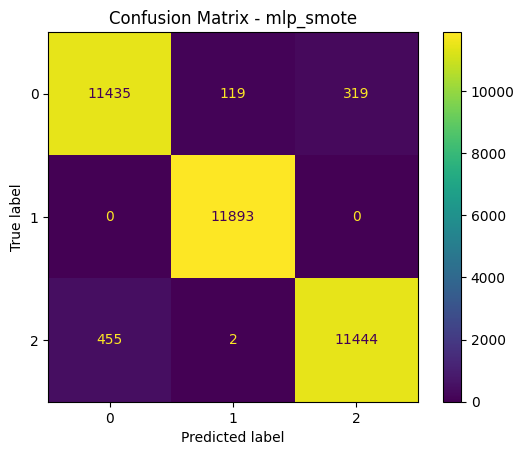

Cohen's Kappa Score: 0.9623602104828016
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     11873
           1       0.99      1.00      0.99     11893
           2       0.97      0.96      0.97     11901

    accuracy                           0.97     35667
   macro avg       0.97      0.97      0.97     35667
weighted avg       0.97      0.97      0.97     35667

----------------------------------------
elapsed time 59.48508054812749 minutes


In [ ]:
t0 = time.time()
models = {
    'mlp_80': MLPClassifier(activation='relu', alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate='constant', max_iter=250, solver='adam'),
    'mlp_90': MLPClassifier(activation='relu', alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate='constant', max_iter=500, solver='adam'),
    'mlp_95': MLPClassifier(activation='relu', alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate='constant', max_iter=500, solver='adam'),
    'mlp_smote': MLPClassifier(activation='relu', alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate='constant', max_iter=500, solver='adam')
}

trained_models = {}

for model_name, model in models.items():
    print(f"Model: {model_name}")

    if model_name == 'mlp_80':
        X_tr, X_te, y_tr, y_te = X_tr_80, X_te_80, y_tr_80, y_te_80
    elif model_name == 'mlp_90':
        X_tr, X_te, y_tr, y_te = X_tr_90, X_te_90, y_tr_90, y_te_90
    elif model_name == 'mlp_95':
        X_tr, X_te, y_tr, y_te = X_tr_95, X_te_95, y_tr_95, y_te_95
    elif model_name == 'mlp_smote':
        X_tr, X_te, y_tr, y_te = X_tr_smote, X_te_smote, y_tr_smote, y_te_smote

    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_te_scaled = scaler.transform(X_te)

    scores = cross_val_score(model, X_tr_scaled, y_tr, cv=5)
    print("Cross Validation Scores:", scores)
    print("Average Cross Validation Score:", scores.mean())

    model.fit(X_tr_scaled, y_tr)
    trained_models[model_name] = model

    train_accuracy = model.score(X_tr_scaled, y_tr)
    print("Train Accuracy:", train_accuracy)

    test_accuracy = model.score(X_te_scaled, y_te)
    print("Test Accuracy:", test_accuracy)

    y_pred = model.predict(X_te_scaled)
    cm = confusion_matrix(y_te, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format='')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    kappa = cohen_kappa_score(y_te, y_pred)
    print(f"Cohen's Kappa Score: {kappa}")

    report = classification_report(y_te, y_pred)
    print("Classification Report:")
    print(report)

    print("----------------------------------------")
t1 = time.time()
print("elapsed time", (t1 - t0)/60, "minutes")

After just an hour we can see that results are quite similar, with Smote being slightly better than other splits.

Unfortunatelly there is no way to show the feature importance for MLP in scikit-learn

##**Histogram Based Gradient Boosting**

As a final classifier we also wanted to try the relatively new Histogram Based Gradient Boosting (HGB). HGB is a slightly different version of Gradient Boosting, but much more efficient for lager datasets (such as ours) than "simple" Gradient Boosting.

In [ ]:
t0 = time.time()
clf = HistGradientBoostingClassifier(max_iter=600,
                                     learning_rate=0.02)
clf.fit(X_tr_80, y_tr_80)
clf.predict(X_te_80)
t1 = time.time()

print("training took", t1-t0, "seconds")
print("stopped after", clf.n_iter_, "steps")
print()
print("train accuracy:", clf.score(X_tr_80, y_tr_80))
print("test  accuracy:", clf.score(X_te_80, y_te_80))

training took 13.270180225372314 seconds
stopped after 313 steps

train accuracy: 0.9806528124439786
test  accuracy: 0.975


With basically default setting we already achieved a stunning test score of almost 98 %. However, we are overfitting a bit and we are also curious whether we could get even better results with some simple hyperparameter tuning.

In [ ]:
t0 = time.time()
param_grid = {
    'learning_rate': [0.002, 0.02, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10]}

clf = HistGradientBoostingClassifier(max_iter=600)

grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_tr_80, y_tr_80)
best_params = grid_search.best_params_
print(best_params)

clf = HistGradientBoostingClassifier(**best_params)
clf.fit(X_tr_80, y_tr_80)
clf.predict(X_te_80)
t1 = time.time()

print("Training took", t1 - t0, "seconds")
print("Stopped after", clf.n_iter_, "steps")
print("Train accuracy:", clf.score(X_tr_80, y_tr_80))
print("Test accuracy:", clf.score(X_te_80, y_te_80))

{'learning_rate': 0.05, 'max_depth': 10}
Training took 575.6010978221893 seconds
Stopped after 100 steps
Train accuracy: 0.9797013114166333
Test accuracy: 0.9755


GridSearching over a few parameters took significantly longer than the previous cell and the test accuracy could not really improve a lot. However, the test scores are still very promising, we will do a gridsearch again with every train/test split:

In [ ]:
t0= time.time()
param_grid = {
    'learning_rate': [0.0002, 0.002, 0.02, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10]}

clf = HistGradientBoostingClassifier(max_iter=600)

trainsets = [(X_tr_80, y_tr_80),
             (X_tr_90, y_tr_90),
             (X_tr_95, y_tr_95),
             (X_tr_smote, y_tr_smote)]

testsets = [(X_te_80, y_te_80),
             (X_te_90, y_te_90),
             (X_te_95, y_te_95),
             (X_te_smote, y_te_smote)]

clf_individual = []

for i, (X_train, y_train) in enumerate(trainsets):
    print(f"Training on split {i + 1}...")
    grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    clf = HistGradientBoostingClassifier(**grid_search.best_params_)
    clf.fit(X_train, y_train)
    clf_individual.append(clf)
    print(f"Stopped after {clf.n_iter_} steps")
    print(f"Train accuracy (split {i + 1}): {clf.score(X_train, y_train):.4f}")
    print("---------")

for i, (X_test, y_test) in enumerate(testsets):
    clf = clf_individual[i]
    clf.predict(X_test)
    print(f"Test accuracy (split {i + 1}): {clf.score(X_test, y_test):.4f}\n")
    print("--------")


t1= time.time()
print("total time elapsed:",(t1-t0)/60,"minutes")

Training on split 1...
Stopped after 100 steps
Train accuracy (split 1): 0.9773
---------
Training on split 2...
Stopped after 92 steps
Train accuracy (split 2): 0.9831
---------
Training on split 3...
Stopped after 31 steps
Train accuracy (split 3): 0.9815
---------
Training on split 4...
Stopped after 100 steps
Train accuracy (split 4): 0.9817
---------
Test accuracy (split 1): 0.9748

--------
Test accuracy (split 2): 0.9763

--------
Test accuracy (split 3): 0.9820

--------
Test accuracy (split 4): 0.9754

--------
total time elapsed: 26.321549932161968 minutes


We were able to boost our test accuracy without any overfitting to 98.2% for the 80/20 trains/test-split. This is a fairly good result,

#**Summary**

As a short summary we are listing the f1-scores for every model and train/test-split in chronological order. The time should only be understood as a rough overview, the exact time that the algorithms take can are provided in the particular cells:

knn: (1 hour)
99.2 (80/20);
99.4 (90/10);
99.3 (95/5);
97.2 (SMOTE);


PCA-knn: (26 minutes)
99.28 (80/20);
99.25 (90/10);
99.18 (95/5);
96.5 (SMOTE)


logistic: (15 min)
96.0 (80/20);
96.0 (90/10);
96.0 (95/5);
96.0 (SMOTE);


decision tree: (7 min)
97.3 (80/20);
97.5 (90/10);
97.4 (95/5);
97.7 (SMOTE);


random forest: (35 min)
97.5  (80/20);
97.8  (90/10);
97.8 (95/5);
97.4 (SMOTE);

extra forest: (5 min)
96.6  (80/20);
95.1  (90/10);
95.5 (95/5);
94.4 (SMOTE);


svm: (20 min)
96.0 (80/20);
96.0 (90/10);
96.0 (95/5);
96.0 (SMOTE);


gaussian NB: (1 min)
93.0 (80/20);
74.0 (90/10);
74.0 (95/5);
86.0 (SMOTE);


neural network: (1 hour)
97.5 (80/20);
97.4 (90/10);
97.2 (95/5);
97.5 (SMOTE);

HGB: (15min)
97.5 (80/20);
97.6 (90/10);
98.2 (95/5);
97.5 (SMOTE)

We systematically evaluated various classification algorithms, including kNN, logisitic regression, decision trees, random forests, Support Vector Machines, Gaussian Naive Bayes and Neural Networks. After a lot of tuning, computing and again tuning we can propose that most of the classifiers did a pretty good job, which can also be explained by the more or less simple dataset. One very suprising instance was the test set performance of the kNN-classifer, which is based on the pure dominance of the redshift-feature importance. The test set scores for kNN are pretty good, but the reduction to more or less solely rely on redshift is not a very good and physically way of thinking about this problem, as we can also see for the lower cross_val_scores that are based on a much larger dataset. For a long term classification with a lot of data, this approach would not be the best, the scores would certainly decrease with increasing data.
Based on that fact and the long computation time, we would not suggest kNN as the best classifier for this problem. We would rather choose Random Forests or even better, Histogram Based Gradient Boosting. Instead of 1 hour of computation time, HGB takes only about 15 minutes. As it is also a more sophisticated algorithm, it will probably also generalize better for huge amounts of data.


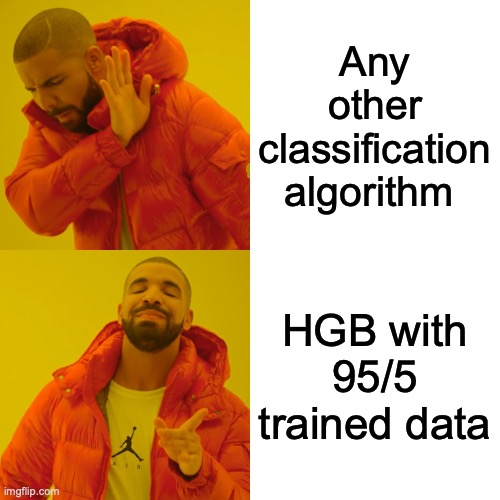

https://i.imgflip.com/8w1uae.jpg